In [1]:
import time
import os
import sys
import ok
from imp import reload
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import dac_control as dac
import adc_control as adc
import spi_control as spi
import wupdate_control as wupdate
import neuron_control as neuron
import matmul
import nn_layers as nn
from tensorflow.keras.layers import BatchNormalization, AveragePooling2D, Input, Flatten
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.datasets import cifar10

sys.path.append('C:\\Users\\Weier Wan\\Dropbox\\cs231n\\cifar10_resnet')
from resnet_model import resnet_v1, resnet_v2
import layers_numpy as nn_np
from layer_utils import *


# Set the matplotlib default settings
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


In [334]:
dev.Close()

In [2]:
# Set the DAC reference voltages
VDD = 5.0
dac.DAC_VREFS[3] = VDD
adc.C_INTEG = 1e-9

# Setup the directories
cwd = os.getcwd()
OK_DIR = os.path.dirname(cwd)
RESULTS_DIR = OK_DIR + '/data/'
PLOT_DIR = OK_DIR + '/plots/'

# Open the front panel API
dev = ok.okCFrontPanel()
print(dev.GetDeviceCount())
print(dev.GetDeviceListSerial(0))
# print(dev.GetDeviceListSerial(1))
status = dev.OpenBySerial("1743000JTJ")
print(status)

1
1743000JTJ
0


In [3]:
status = dev.ConfigureFPGA(OK_DIR + "/HDL/neurram_48core/neurram_top_good.bit")
print(status)

0


In [4]:
# Global reset
dev.SetWireInValue(0x00, 0b11)
dev.UpdateWireIns()
dev.SetWireInValue(0x00, 0b00)
dev.UpdateWireIns()

0

In [5]:
die_info = np.load('die_info.npy', allow_pickle=True).item()
weight_mapping_table = np.load('weight_mapping_table_finetune.npy', allow_pickle=True).item()

In [6]:
for i in range(100):
    inp = np.random.binomial(n=2, p=0.5, size=[1,512])-1
    spi.spi_write(dev, row_addr=[1], forward=True, inputs=inp, shift_multiplier=2, pipe_in_steps=2, is_pipe_in=True)
    out = spi.spi_read(dev, row_addr=[1], num_words=32, forward=False, shift_multiplier=2, pipe_out_steps=2, is_pipe_out=True)
    if not (inp == out).all():
        print(i)
        print(inp)
        print(out)
        break

# Load CIFAR10 Dataset

In [7]:
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# x_train_3bit = quantize_rescale(quantize_unsigned(x_train, 3, 1.0), 3, 1.0)
x_test_4bit = nn_np.quantize_rescale(nn_np.quantize_unsigned(x_test, 4, 0.95), 4, 0.95)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [8]:
del x_train
del x_test

# Load Keras Model

In [9]:
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

activation_bits = 3
model_name = 'filter16_act%db_wnoise0.20' % activation_bits

# Model name, depth and version
model_type = 'ResNet%dv%d_%s' % (depth, version, model_name)
print(model_type)

ResNet20v1_filter16_act3b_wnoise0.20


In [346]:
K.clear_session()
input_shape = (32, 32, 3)

if version == 2:
    model = resnet_v2(input_shape=input_shape,
                      depth=depth,
                      activation_bits=activation_bits,
                      weight_noise=0.00)
else:
    model = resnet_v1(input_shape=input_shape,
                      depth=depth,
                      activation_bits=activation_bits,
                      weight_noise=0.00)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model.summary()
print(model_type)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_noise (conv2d_noise)     (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d_noise[0][0]               
__________________________________________________________________________________________________
activation_quant (activation_qu (None, 32, 32, 16)   1           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
# Prepare model model saving directory.
save_dir = 'C:\\Users\\Weier Wan\\Dropbox\\cs231n\\cifar10_resnet\\model_checkpoint\\%s\\checkpoint' % model_type
latest = tf.train.latest_checkpoint(save_dir)
print(latest)
model.load_weights(latest)

In [1334]:
save_dir = 'C:\\Users\\Weier Wan\\Dropbox\\cs231n\\cifar10_resnet\\model_checkpoint\\%s\\tf_savedmodel\\fwd_finetune_conv2d_noise_4_val' % model_type
model = load_model(save_dir)

In [1335]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 16)]      0         
_________________________________________________________________
input_2 (InputLayer)         [(None, 32, 32, 16)]      0         
_________________________________________________________________
add (Add)                    multiple                  0         
_________________________________________________________________
activation_quant_4 (activati multiple                  1         
_________________________________________________________________
conv2d_noise_5 (conv2d_noise multiple                  2320      
_________________________________________________________________
batch_normalization_5 (Batch multiple                  64        
_________________________________________________________________
activation_quant_5 (activati multiple                  1     

In [1336]:
weights = {}
for layer in model.layers:
    weights[layer.name] = layer.get_weights()

# Forming RRAMs

In [394]:
chip = 5
core_row = 1
core_col = 0
print(die_info[chip][core_row][core_col])

{'unformed': array([ 68,  75, 134, 156, 247, 108]), 'leaky': [], 'bad_cols': []}


In [47]:
core = die_info[chip][core_row][core_col]
bad_rows = np.hstack([core['unformed'], core['leaky']])
# bad_cols = []
# if 'bad_cols' in core:
#     bad_cols = core['bad_cols']
rows = np.delete(np.arange(256), bad_rows)

In [14]:
core = die_info[chip][core_row][core_col]
core['leaky'].append(81)

In [388]:
# Find the leaky cols
leaky_cols = []
adc.adc_setup(dev, vread=1.1, vref=0.9)
for c in range(64, 128):
    spi.enable_single_core(dev, core_row, core_col)
    wupdate.write_reg(dev, 1, c, core_row, core_col)
    reads1 = adc.read_average_resistance(dev, vread=1.1, vref=0.9, t_shld=100, t_delta=200,
                                     read_cycles=3, ignore_cycles=1, verbose=False, output_raw=False)
    print((c, reads1))
    if reads1 < 1e6:
        print('Found leaky col %d' % c)
        leaky_cols.append(c)
print(leaky_cols)

(64, 1302967.344301407)
(65, 30170507.840598483)
(66, 4277894.04973176)
(67, 3451193.1014053915)
(68, 2251177.5692908824)
(69, 11692743.441777484)
(70, 5058375.744711645)
(71, 2968704.1703236043)
(72, 373743.94069004856)
Found leaky col 72
(73, 2089504.4138453265)
(74, 32109504.306220103)
(75, 13790701.650555672)
(76, 3984784.0544186677)
(77, 6235955.991674101)
(78, 117192064.8225762)
(79, 975092.9921142688)
Found leaky col 79
(80, 2161254.817898881)
(81, 2488256.0926413713)
(82, 52271984.047856435)
(83, 7428016.859703184)
(84, 14819291.241211183)
(85, 816877.0060141477)
Found leaky col 85
(86, 6428052.1072796965)
(87, 27665088.054877646)
(88, 52780117.658162154)
(89, 6569201.854404212)
(90, 58626746.33958835)
(91, 1746578.7194350061)
(92, 28420544.789266847)
(93, 4854181.422586395)
(94, 6085757.399883925)
(95, 9012837.09736339)
(96, 4735794.77451844)
(97, 5366991.68266155)
(98, 3511640.9912926992)
(99, 2742307.1893715514)
(100, 3546920.136657309)
(101, 5539228.737453778)
(102, 5753700

In [392]:
chip = 5
core_row = 1
core_col = 0

bad_rows = []
bad_cols = []

core_info = die_info[chip][core_row][core_col]
bad_rows = np.hstack([core_info['unformed'], core_info['leaky']])
if 'bad_cols' in core_info:
    bad_cols = core_info['bad_cols']

rows = [108]
cols = np.delete(np.arange(256), bad_cols)[:11]

wupdate.ramp_up_voltage(dev, 3, 0, 4.2)
wupdate.ramp_up_voltage(dev, 3, 1, 1.5)
adc.adc_setup(dev, vread=1.0, vref=0.9)
spi.enable_single_core(dev, core_row, core_col)
vform = np.zeros([len(rows), len(cols)])
rform = np.zeros([len(rows), len(cols)])
for ri, r in enumerate(rows):
    for ci, c in enumerate(cols):
        vform[ri, ci], rform[ri, ci] = wupdate.find_vset_bl(dev, row=r, col=c, core_row=core_row, core_col=core_col, pulse_first=False,
                                                            vset_wl=1.5, vset_bl_start=4.2, vset_bl_end=4.7, tset=1e-3, r_target=8e5, tread=4000)
        print('finished %d row, %d column' % (r, c))


The RRAM is not SET
finished 108 row, 0 column


KeyboardInterrupt: 

In [391]:
ru = (rows[np.unique(np.where(~((rform>0) & (rform<1e6)))[0])])
print(ru)

[108]


In [393]:
die_info[chip][core_row][core_col]['unformed'] = np.hstack([die_info[chip][core_row][core_col]['unformed'], [108]])

In [937]:
np.where(rows == 194)

(array([144], dtype=int64),)

In [343]:
# Find the leaky row
row_unform = 13
spi.enable_single_core(dev, core_row, core_col)
for ri in range(0, 256):
    wupdate.write_reg(dev, ri, 0, core_row, core_col)
    read1 = adc.read_average_resistance(dev, vread=1.1, vref=0.9, t_shld=100, t_delta=200,
                                         read_cycles=2, ignore_cycles=1, verbose=False)
    wupdate.write_reg(dev, row_unform, 2, core_row, core_col)
    read_unform = adc.read_average_resistance(dev, vread=1.1, vref=0.9, t_shld=100, t_delta=200,
                                         read_cycles=2, ignore_cycles=1, verbose=False)
    if read_unform < 1e8:
        print(read_unform)
        print(ri)

In [638]:
np.where(rows==151)

(array([128], dtype=int64),)

In [692]:
rows_unform = np.arange(256)
rows_leaky = []
core = {'unformed':rows_unform, 'leaky':rows_leaky}
# die_info[4].append([])
die_info[chip][core_row].append(core)

In [395]:
np.save('die_info', die_info)

In [376]:
adc.adc_setup(dev, vread=1.1, vref=0.9)
spi.enable_single_core(dev, core_row, core_col)

rr = np.zeros_like(G)
for ri, r in enumerate(rows):
    for ci, c in enumerate(cols):
        wupdate.write_reg(dev, r, c, core_row, core_col)
#         wupdate.apply_set_pulse(dev, 2.0, 2.5, 1e-6, prep=True)
        rr[ri, ci] = adc.read_average_resistance(dev, vread=1.1, vref=0.9, t_shld=100, t_delta=200,
                                             read_cycles=2, ignore_cycles=1, verbose=False)
#         print(reads1)

In [331]:
adc.adc_setup(dev, vread=1.1, vref=0.9)
spi.enable_single_core(dev, core_row, core_col)
wupdate.write_reg(dev, 146, 6, core_row, core_col)
reads1 = adc.read_average_resistance(dev, vread=1.1, vref=0.9, t_shld=100, t_delta=200,
                                     read_cycles=2, ignore_cycles=1, verbose=False)
print(reads1)

22484743.218612637


# Weight Mapping

In [14]:
g_max = 4e-5
g_min = 1e-6
g_tol = 1e-6

In [1268]:
layer = 'conv2d_noise_4'
bn_layer = 'batch_normalization_4'
relu_layer = 'activation_quant_3'

conv_W, conv_b = weights[layer]
gamma, beta, mean, variance = weights[bn_layer]
relux = weights[relu_layer][0]
conv_W, conv_b = nn.merge_conv_batchnorm(conv_W, conv_b, gamma, beta, mean, variance)

num_bias = 2
W_list = nn.conv_filter_2_matrix(conv_W, conv_b, relux, num_bias=num_bias)

print(len(W_list))

2


In [1174]:
w_index = 1
W = W_list[w_index]
G = nn.weight_mapping(W, g_max, scheme='sign', w_max_percentile=95)

chip = 5
core_row = 0
core_col = 0
core = die_info[chip][core_row][core_col]
bad_rows = np.hstack([core['unformed'], core['leaky']])
bad_cols = []
if 'bad_cols' in core:
    bad_cols = core['bad_cols']
rows = np.delete(np.arange(256), bad_rows)[:2*W.shape[0]]
cols = np.delete(np.arange(256), bad_cols)[:W.shape[1]]


layer_mapping = weight_mapping_table[layer][w_index]
# chip = layer_mapping['chip']
# core_row = layer_mapping['core_row']
# core_col = layer_mapping['core_col']
# rows = layer_mapping['rows']
# cols = layer_mapping['cols']
# print(chip)
# print((core_row, core_col))
# print(len(rows)/2)

C:\Users\Weier Wan\.conda\envs\py36\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  del sys.path[0]


In [996]:
core_row_list = np.array([4, 6, 1, 2, 3, 5])
rows_list = []
cols_list = []
for core_idx in np.sort(core_row_list):
    core = die_info[5][core_idx][0]
    bad_rows = np.hstack([core['unformed'], core['leaky']])
    bad_cols = []
    if 'bad_cols' in core:
        bad_cols = core['bad_cols']
    rows_list.append([np.delete(np.arange(256), bad_rows)[:2*W.shape[0]]])
    cols_list.append([np.delete(np.arange(256), bad_cols)[:W.shape[1]]])

C:\Users\Weier Wan\.conda\envs\py36\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  # Remove the CWD from sys.path while we load stuff.


In [41]:
core_row_2 = core_row
core_col_2 = core_col
rows_2 = rows
cols_2 = cols

In [1983]:
core_row = core_row_1
core_col = core_col_1
rows = rows_1
cols = cols_1
W = W_list[5]
G = nn.weight_mapping(W, g_max, scheme='sign', w_max_percentile=95)

In [570]:
weight_mapping_table[layer] = [{'chip':chip, 'core_row':core_row_0, 'core_col':core_col_0, 'rows':rows_0, 'cols':cols_0},
    {'chip':chip, 'core_row':core_row_1, 'core_col':core_col_1, 'rows':rows_1, 'cols':cols_1}]

In [571]:
np.save('weight_mapping_table_finetune', weight_mapping_table)

In [1269]:
# input_sample_train = nn_np.quantize_unsigned(train_previous_layer, 3, relux)
# input_rescale_train = nn_np.quantize_rescale(input_sample_train, 4, relux)
input_sample = nn_np.quantize_unsigned(out_chip_shift, 3, relux)
# input_rescale_test = nn_np.quantize_rescale(input_sample_test, 4, relux)

# input_sample = np.vstack([input_sample_test, input_sample_train])
# input_rescale = np.vstack([input_rescale_train, input_rescale_test])

In [19]:
del train_current_layer
del test_current_layer

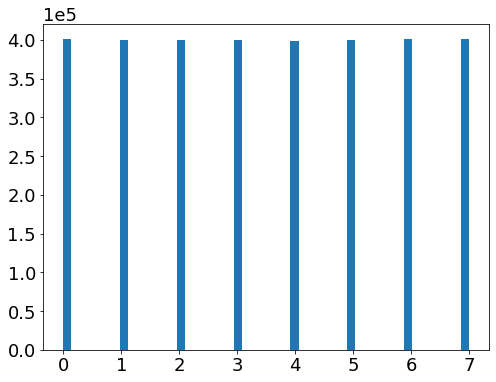

In [327]:
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(np.floor(np.random.uniform(0, 8, input_sample_train.shape)).flatten(), 50);
ax.ticklabel_format(style='sci',scilimits=(-3,4),axis='both')

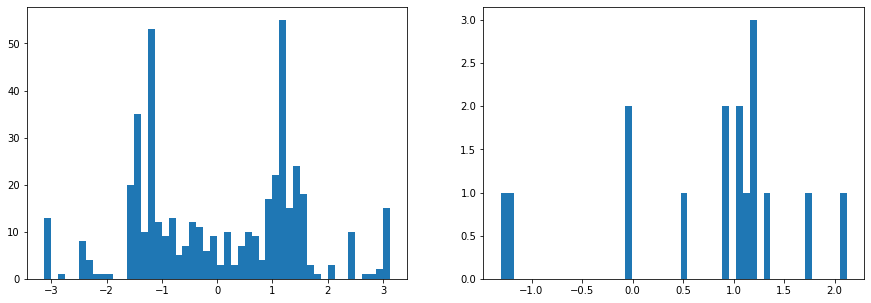

In [69]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.hist(W.flatten(), 50);
plt.subplot(122)
plt.hist(W[-1,:], 50);

In [399]:
adc.adc_setup(dev, vread=1.1, vref=0.9)
wupdate.ramp_up_voltage(dev, 3, 0, 1.5)
wupdate.ramp_up_voltage(dev, 3, 1, 3.0)
wupdate.ramp_up_voltage(dev, 3, 2, 2.5)
spi.enable_single_core(dev, core_row, core_col)

program_sucess, G_program, num_pulses, _ = wupdate.program_array(
    dev, rows, np.arange(16, 64), core_row, core_col, np.zeros([len(rows), 48]), g_min, g_tol, 1, end_voltage=4.0, vread=1.1, vref=0.9, vset_wl=3.0, iteration_limit=20)

RRAM is programmed within the range.
Finished programming 0 row 16 col
RRAM is programmed within the range.
Finished programming 0 row 17 col
RRAM is programmed within the range.
Finished programming 0 row 18 col
RRAM is programmed within the range.
Finished programming 0 row 19 col
RRAM is programmed within the range.
Finished programming 0 row 20 col
RRAM is programmed within the range.
Finished programming 0 row 21 col
RRAM is programmed within the range.
Finished programming 0 row 22 col
RRAM is programmed within the range.
Finished programming 0 row 23 col
RRAM is programmed within the range.
Finished programming 0 row 24 col
RRAM is programmed within the range.
Finished programming 0 row 25 col
RRAM is programmed within the range.
Finished programming 0 row 26 col
RRAM is programmed within the range.
Finished programming 0 row 27 col
RRAM is programmed within the range.
Finished programming 0 row 28 col
RRAM is programmed within the range.
Finished programming 0 row 29 col
RRAM i

RRAM is programmed within the range.
Finished programming 2 row 38 col
RRAM is programmed within the range.
Finished programming 2 row 39 col
RRAM is programmed within the range.
Finished programming 2 row 40 col
RRAM is programmed within the range.
Finished programming 2 row 41 col
RRAM is programmed within the range.
Finished programming 2 row 42 col
RRAM is programmed within the range.
Finished programming 2 row 43 col
RRAM is programmed within the range.
Finished programming 2 row 44 col
RRAM is programmed within the range.
Finished programming 2 row 45 col
RRAM is programmed within the range.
Finished programming 2 row 46 col
RRAM is programmed within the range.
Finished programming 2 row 47 col
RRAM is programmed within the range.
Finished programming 2 row 48 col
RRAM is programmed within the range.
Finished programming 2 row 49 col
RRAM is programmed within the range.
Finished programming 2 row 50 col
RRAM is programmed within the range.
Finished programming 2 row 51 col
RRAM i

RRAM is programmed within the range.
Finished programming 4 row 58 col
RRAM is programmed within the range.
Finished programming 4 row 59 col
RRAM is programmed within the range.
Finished programming 4 row 60 col
RRAM is programmed within the range.
Finished programming 4 row 61 col
RRAM is programmed within the range.
Finished programming 4 row 62 col
RRAM is programmed within the range.
Finished programming 4 row 63 col
RRAM is programmed within the range.
Finished programming 5 row 16 col
RRAM is programmed within the range.
Finished programming 5 row 17 col
RRAM is programmed within the range.
Finished programming 5 row 18 col
RRAM is programmed within the range.
Finished programming 5 row 19 col
Programming exceeds maximum iteration.
Finished programming 5 row 20 col
RRAM is programmed within the range.
Finished programming 5 row 21 col
Programming exceeds maximum iteration.
Finished programming 5 row 22 col
RRAM is programmed within the range.
Finished programming 5 row 23 col
RR

RRAM is programmed within the range.
Finished programming 7 row 31 col
RRAM is programmed within the range.
Finished programming 7 row 32 col
RRAM is programmed within the range.
Finished programming 7 row 33 col
RRAM is programmed within the range.
Finished programming 7 row 34 col
RRAM is programmed within the range.
Finished programming 7 row 35 col
RRAM is programmed within the range.
Finished programming 7 row 36 col
RRAM is programmed within the range.
Finished programming 7 row 37 col
RRAM is programmed within the range.
Finished programming 7 row 38 col
RRAM is programmed within the range.
Finished programming 7 row 39 col
RRAM is programmed within the range.
Finished programming 7 row 40 col
RRAM is programmed within the range.
Finished programming 7 row 41 col
RRAM is programmed within the range.
Finished programming 7 row 42 col
RRAM is programmed within the range.
Finished programming 7 row 43 col
RRAM is programmed within the range.
Finished programming 7 row 44 col
RRAM i

RRAM is programmed within the range.
Finished programming 9 row 51 col
RRAM is programmed within the range.
Finished programming 9 row 52 col
RRAM is programmed within the range.
Finished programming 9 row 53 col
RRAM is programmed within the range.
Finished programming 9 row 54 col
RRAM is programmed within the range.
Finished programming 9 row 55 col
RRAM is programmed within the range.
Finished programming 9 row 56 col
RRAM is programmed within the range.
Finished programming 9 row 57 col
RRAM is programmed within the range.
Finished programming 9 row 58 col
RRAM is programmed within the range.
Finished programming 9 row 59 col
RRAM is programmed within the range.
Finished programming 9 row 60 col
RRAM is programmed within the range.
Finished programming 9 row 61 col
Programming exceeds maximum iteration.
Finished programming 9 row 62 col
RRAM is programmed within the range.
Finished programming 9 row 63 col
RRAM is programmed within the range.
Finished programming 10 row 16 col
RRA

RRAM is programmed within the range.
Finished programming 12 row 21 col
RRAM is programmed within the range.
Finished programming 12 row 22 col
RRAM is programmed within the range.
Finished programming 12 row 23 col
RRAM is programmed within the range.
Finished programming 12 row 24 col
RRAM is programmed within the range.
Finished programming 12 row 25 col
RRAM is programmed within the range.
Finished programming 12 row 26 col
RRAM is programmed within the range.
Finished programming 12 row 27 col
RRAM is programmed within the range.
Finished programming 12 row 28 col
RRAM is programmed within the range.
Finished programming 12 row 29 col
RRAM is programmed within the range.
Finished programming 12 row 30 col
RRAM is programmed within the range.
Finished programming 12 row 31 col
RRAM is programmed within the range.
Finished programming 12 row 32 col
RRAM is programmed within the range.
Finished programming 12 row 33 col
RRAM is programmed within the range.
Finished programming 12 row

RRAM is programmed within the range.
Finished programming 14 row 39 col
RRAM is programmed within the range.
Finished programming 14 row 40 col
RRAM is programmed within the range.
Finished programming 14 row 41 col
RRAM is programmed within the range.
Finished programming 14 row 42 col
RRAM is programmed within the range.
Finished programming 14 row 43 col
RRAM is programmed within the range.
Finished programming 14 row 44 col
RRAM is programmed within the range.
Finished programming 14 row 45 col
RRAM is programmed within the range.
Finished programming 14 row 46 col
RRAM is programmed within the range.
Finished programming 14 row 47 col
RRAM is programmed within the range.
Finished programming 14 row 48 col
RRAM is programmed within the range.
Finished programming 14 row 49 col
RRAM is programmed within the range.
Finished programming 14 row 50 col
RRAM is programmed within the range.
Finished programming 14 row 51 col
RRAM is programmed within the range.
Finished programming 14 row

RRAM is programmed within the range.
Finished programming 16 row 58 col
RRAM is programmed within the range.
Finished programming 16 row 59 col
RRAM is programmed within the range.
Finished programming 16 row 60 col
RRAM is programmed within the range.
Finished programming 16 row 61 col
RRAM is programmed within the range.
Finished programming 16 row 62 col
RRAM is programmed within the range.
Finished programming 16 row 63 col
RRAM is programmed within the range.
Finished programming 17 row 16 col
RRAM is programmed within the range.
Finished programming 17 row 17 col
RRAM is programmed within the range.
Finished programming 17 row 18 col
RRAM is programmed within the range.
Finished programming 17 row 19 col
RRAM is programmed within the range.
Finished programming 17 row 20 col
RRAM is programmed within the range.
Finished programming 17 row 21 col
RRAM is programmed within the range.
Finished programming 17 row 22 col
RRAM is programmed within the range.
Finished programming 17 row

RRAM is programmed within the range.
Finished programming 19 row 29 col
RRAM is programmed within the range.
Finished programming 19 row 30 col
RRAM is programmed within the range.
Finished programming 19 row 31 col
RRAM is programmed within the range.
Finished programming 19 row 32 col
RRAM is programmed within the range.
Finished programming 19 row 33 col
RRAM is programmed within the range.
Finished programming 19 row 34 col
RRAM is programmed within the range.
Finished programming 19 row 35 col
RRAM is programmed within the range.
Finished programming 19 row 36 col
RRAM is programmed within the range.
Finished programming 19 row 37 col
Programming exceeds maximum iteration.
Finished programming 19 row 38 col
RRAM is programmed within the range.
Finished programming 19 row 39 col
RRAM is programmed within the range.
Finished programming 19 row 40 col
RRAM is programmed within the range.
Finished programming 19 row 41 col
RRAM is programmed within the range.
Finished programming 19 r

RRAM is programmed within the range.
Finished programming 21 row 48 col
RRAM is programmed within the range.
Finished programming 21 row 49 col
RRAM is programmed within the range.
Finished programming 21 row 50 col
RRAM is programmed within the range.
Finished programming 21 row 51 col
RRAM is programmed within the range.
Finished programming 21 row 52 col
RRAM is programmed within the range.
Finished programming 21 row 53 col
RRAM is programmed within the range.
Finished programming 21 row 54 col
RRAM is programmed within the range.
Finished programming 21 row 55 col
RRAM is programmed within the range.
Finished programming 21 row 56 col
RRAM is programmed within the range.
Finished programming 21 row 57 col
RRAM is programmed within the range.
Finished programming 21 row 58 col
RRAM is programmed within the range.
Finished programming 21 row 59 col
RRAM is programmed within the range.
Finished programming 21 row 60 col
RRAM is programmed within the range.
Finished programming 21 row

RRAM is programmed within the range.
Finished programming 24 row 20 col
RRAM is programmed within the range.
Finished programming 24 row 21 col
RRAM is programmed within the range.
Finished programming 24 row 22 col
RRAM is programmed within the range.
Finished programming 24 row 23 col
RRAM is programmed within the range.
Finished programming 24 row 24 col
RRAM is programmed within the range.
Finished programming 24 row 25 col
RRAM is programmed within the range.
Finished programming 24 row 26 col
RRAM is programmed within the range.
Finished programming 24 row 27 col
RRAM is programmed within the range.
Finished programming 24 row 28 col
RRAM is programmed within the range.
Finished programming 24 row 29 col
RRAM is programmed within the range.
Finished programming 24 row 30 col
RRAM is programmed within the range.
Finished programming 24 row 31 col
RRAM is programmed within the range.
Finished programming 24 row 32 col
RRAM is programmed within the range.
Finished programming 24 row

RRAM is programmed within the range.
Finished programming 26 row 38 col
RRAM is programmed within the range.
Finished programming 26 row 39 col
RRAM is programmed within the range.
Finished programming 26 row 40 col
RRAM is programmed within the range.
Finished programming 26 row 41 col
RRAM is programmed within the range.
Finished programming 26 row 42 col
RRAM is programmed within the range.
Finished programming 26 row 43 col
RRAM is programmed within the range.
Finished programming 26 row 44 col
RRAM is programmed within the range.
Finished programming 26 row 45 col
RRAM is programmed within the range.
Finished programming 26 row 46 col
RRAM is programmed within the range.
Finished programming 26 row 47 col
RRAM is programmed within the range.
Finished programming 26 row 48 col
RRAM is programmed within the range.
Finished programming 26 row 49 col
RRAM is programmed within the range.
Finished programming 26 row 50 col
RRAM is programmed within the range.
Finished programming 26 row

RRAM is programmed within the range.
Finished programming 28 row 56 col
RRAM is programmed within the range.
Finished programming 28 row 57 col
RRAM is programmed within the range.
Finished programming 28 row 58 col
RRAM is programmed within the range.
Finished programming 28 row 59 col
RRAM is programmed within the range.
Finished programming 28 row 60 col
RRAM is programmed within the range.
Finished programming 28 row 61 col
RRAM is programmed within the range.
Finished programming 28 row 62 col
RRAM is programmed within the range.
Finished programming 28 row 63 col
RRAM is programmed within the range.
Finished programming 29 row 16 col
RRAM is programmed within the range.
Finished programming 29 row 17 col
RRAM is programmed within the range.
Finished programming 29 row 18 col
RRAM is programmed within the range.
Finished programming 29 row 19 col
RRAM is programmed within the range.
Finished programming 29 row 20 col
RRAM is programmed within the range.
Finished programming 29 row

RRAM is programmed within the range.
Finished programming 31 row 26 col
RRAM is programmed within the range.
Finished programming 31 row 27 col
RRAM is programmed within the range.
Finished programming 31 row 28 col
RRAM is programmed within the range.
Finished programming 31 row 29 col
RRAM is programmed within the range.
Finished programming 31 row 30 col
RRAM is programmed within the range.
Finished programming 31 row 31 col
RRAM is programmed within the range.
Finished programming 31 row 32 col
RRAM is programmed within the range.
Finished programming 31 row 33 col
RRAM is programmed within the range.
Finished programming 31 row 34 col
RRAM is programmed within the range.
Finished programming 31 row 35 col
RRAM is programmed within the range.
Finished programming 31 row 36 col
RRAM is programmed within the range.
Finished programming 31 row 37 col
RRAM is programmed within the range.
Finished programming 31 row 38 col
RRAM is programmed within the range.
Finished programming 31 row

RRAM is programmed within the range.
Finished programming 33 row 44 col
RRAM is programmed within the range.
Finished programming 33 row 45 col
RRAM is programmed within the range.
Finished programming 33 row 46 col
RRAM is programmed within the range.
Finished programming 33 row 47 col
RRAM is programmed within the range.
Finished programming 33 row 48 col
RRAM is programmed within the range.
Finished programming 33 row 49 col
RRAM is programmed within the range.
Finished programming 33 row 50 col
RRAM is programmed within the range.
Finished programming 33 row 51 col
RRAM is programmed within the range.
Finished programming 33 row 52 col
RRAM is programmed within the range.
Finished programming 33 row 53 col
RRAM is programmed within the range.
Finished programming 33 row 54 col
RRAM is programmed within the range.
Finished programming 33 row 55 col
RRAM is programmed within the range.
Finished programming 33 row 56 col
RRAM is programmed within the range.
Finished programming 33 row

RRAM is programmed within the range.
Finished programming 35 row 62 col
RRAM is programmed within the range.
Finished programming 35 row 63 col
RRAM is programmed within the range.
Finished programming 36 row 16 col
RRAM is programmed within the range.
Finished programming 36 row 17 col
RRAM is programmed within the range.
Finished programming 36 row 18 col
RRAM is programmed within the range.
Finished programming 36 row 19 col
RRAM is programmed within the range.
Finished programming 36 row 20 col
RRAM is programmed within the range.
Finished programming 36 row 21 col
RRAM is programmed within the range.
Finished programming 36 row 22 col
RRAM is programmed within the range.
Finished programming 36 row 23 col
RRAM is programmed within the range.
Finished programming 36 row 24 col
RRAM is programmed within the range.
Finished programming 36 row 25 col
RRAM is programmed within the range.
Finished programming 36 row 26 col
RRAM is programmed within the range.
Finished programming 36 row

RRAM is programmed within the range.
Finished programming 38 row 32 col
RRAM is programmed within the range.
Finished programming 38 row 33 col
RRAM is programmed within the range.
Finished programming 38 row 34 col
RRAM is programmed within the range.
Finished programming 38 row 35 col
RRAM is programmed within the range.
Finished programming 38 row 36 col
RRAM is programmed within the range.
Finished programming 38 row 37 col
RRAM is programmed within the range.
Finished programming 38 row 38 col
RRAM is programmed within the range.
Finished programming 38 row 39 col
RRAM is programmed within the range.
Finished programming 38 row 40 col
RRAM is programmed within the range.
Finished programming 38 row 41 col
RRAM is programmed within the range.
Finished programming 38 row 42 col
RRAM is programmed within the range.
Finished programming 38 row 43 col
RRAM is programmed within the range.
Finished programming 38 row 44 col
RRAM is programmed within the range.
Finished programming 38 row

RRAM is programmed within the range.
Finished programming 40 row 52 col
RRAM is programmed within the range.
Finished programming 40 row 53 col
RRAM is programmed within the range.
Finished programming 40 row 54 col
RRAM is programmed within the range.
Finished programming 40 row 55 col
RRAM is programmed within the range.
Finished programming 40 row 56 col
RRAM is programmed within the range.
Finished programming 40 row 57 col
RRAM is programmed within the range.
Finished programming 40 row 58 col
RRAM is programmed within the range.
Finished programming 40 row 59 col
RRAM is programmed within the range.
Finished programming 40 row 60 col
RRAM is programmed within the range.
Finished programming 40 row 61 col
RRAM is programmed within the range.
Finished programming 40 row 62 col
RRAM is programmed within the range.
Finished programming 40 row 63 col
RRAM is programmed within the range.
Finished programming 41 row 16 col
RRAM is programmed within the range.
Finished programming 41 row

RRAM is programmed within the range.
Finished programming 43 row 25 col
RRAM is programmed within the range.
Finished programming 43 row 26 col
RRAM is programmed within the range.
Finished programming 43 row 27 col
RRAM is programmed within the range.
Finished programming 43 row 28 col
RRAM is programmed within the range.
Finished programming 43 row 29 col
RRAM is programmed within the range.
Finished programming 43 row 30 col
RRAM is programmed within the range.
Finished programming 43 row 31 col
RRAM is programmed within the range.
Finished programming 43 row 32 col
RRAM is programmed within the range.
Finished programming 43 row 33 col
RRAM is programmed within the range.
Finished programming 43 row 34 col
RRAM is programmed within the range.
Finished programming 43 row 35 col
RRAM is programmed within the range.
Finished programming 43 row 36 col
RRAM is programmed within the range.
Finished programming 43 row 37 col
RRAM is programmed within the range.
Finished programming 43 row

RRAM is programmed within the range.
Finished programming 45 row 44 col
RRAM is programmed within the range.
Finished programming 45 row 45 col
RRAM is programmed within the range.
Finished programming 45 row 46 col
RRAM is programmed within the range.
Finished programming 45 row 47 col
RRAM is programmed within the range.
Finished programming 45 row 48 col
RRAM is programmed within the range.
Finished programming 45 row 49 col
RRAM is programmed within the range.
Finished programming 45 row 50 col
RRAM is programmed within the range.
Finished programming 45 row 51 col
RRAM is programmed within the range.
Finished programming 45 row 52 col
Programming exceeds maximum iteration.
Finished programming 45 row 53 col
RRAM is programmed within the range.
Finished programming 45 row 54 col
RRAM is programmed within the range.
Finished programming 45 row 55 col
RRAM is programmed within the range.
Finished programming 45 row 56 col
RRAM is programmed within the range.
Finished programming 45 r

RRAM is programmed within the range.
Finished programming 48 row 16 col
RRAM is programmed within the range.
Finished programming 48 row 17 col
RRAM is programmed within the range.
Finished programming 48 row 18 col
RRAM is programmed within the range.
Finished programming 48 row 19 col
RRAM is programmed within the range.
Finished programming 48 row 20 col
RRAM is programmed within the range.
Finished programming 48 row 21 col
RRAM is programmed within the range.
Finished programming 48 row 22 col
RRAM is programmed within the range.
Finished programming 48 row 23 col
RRAM is programmed within the range.
Finished programming 48 row 24 col
RRAM is programmed within the range.
Finished programming 48 row 25 col
RRAM is programmed within the range.
Finished programming 48 row 26 col
RRAM is programmed within the range.
Finished programming 48 row 27 col
RRAM is programmed within the range.
Finished programming 48 row 28 col
RRAM is programmed within the range.
Finished programming 48 row

RRAM is programmed within the range.
Finished programming 50 row 34 col
RRAM is programmed within the range.
Finished programming 50 row 35 col
RRAM is programmed within the range.
Finished programming 50 row 36 col
RRAM is programmed within the range.
Finished programming 50 row 37 col
RRAM is programmed within the range.
Finished programming 50 row 38 col
RRAM is programmed within the range.
Finished programming 50 row 39 col
RRAM is programmed within the range.
Finished programming 50 row 40 col
RRAM is programmed within the range.
Finished programming 50 row 41 col
RRAM is programmed within the range.
Finished programming 50 row 42 col
RRAM is programmed within the range.
Finished programming 50 row 43 col
RRAM is programmed within the range.
Finished programming 50 row 44 col
RRAM is programmed within the range.
Finished programming 50 row 45 col
RRAM is programmed within the range.
Finished programming 50 row 46 col
RRAM is programmed within the range.
Finished programming 50 row

RRAM is programmed within the range.
Finished programming 52 row 52 col
RRAM is programmed within the range.
Finished programming 52 row 53 col
RRAM is programmed within the range.
Finished programming 52 row 54 col
RRAM is programmed within the range.
Finished programming 52 row 55 col
RRAM is programmed within the range.
Finished programming 52 row 56 col
RRAM is programmed within the range.
Finished programming 52 row 57 col
RRAM is programmed within the range.
Finished programming 52 row 58 col
RRAM is programmed within the range.
Finished programming 52 row 59 col
RRAM is programmed within the range.
Finished programming 52 row 60 col
RRAM is programmed within the range.
Finished programming 52 row 61 col
RRAM is programmed within the range.
Finished programming 52 row 62 col
RRAM is programmed within the range.
Finished programming 52 row 63 col
RRAM is programmed within the range.
Finished programming 53 row 16 col
RRAM is programmed within the range.
Finished programming 53 row

RRAM is programmed within the range.
Finished programming 55 row 23 col
RRAM is programmed within the range.
Finished programming 55 row 24 col
RRAM is programmed within the range.
Finished programming 55 row 25 col
RRAM is programmed within the range.
Finished programming 55 row 26 col
RRAM is programmed within the range.
Finished programming 55 row 27 col
RRAM is programmed within the range.
Finished programming 55 row 28 col
RRAM is programmed within the range.
Finished programming 55 row 29 col
RRAM is programmed within the range.
Finished programming 55 row 30 col
RRAM is programmed within the range.
Finished programming 55 row 31 col
RRAM is programmed within the range.
Finished programming 55 row 32 col
RRAM is programmed within the range.
Finished programming 55 row 33 col
RRAM is programmed within the range.
Finished programming 55 row 34 col
RRAM is programmed within the range.
Finished programming 55 row 35 col
RRAM is programmed within the range.
Finished programming 55 row

RRAM is programmed within the range.
Finished programming 57 row 42 col
RRAM is programmed within the range.
Finished programming 57 row 43 col
RRAM is programmed within the range.
Finished programming 57 row 44 col
RRAM is programmed within the range.
Finished programming 57 row 45 col
RRAM is programmed within the range.
Finished programming 57 row 46 col
RRAM is programmed within the range.
Finished programming 57 row 47 col
RRAM is programmed within the range.
Finished programming 57 row 48 col
RRAM is programmed within the range.
Finished programming 57 row 49 col
RRAM is programmed within the range.
Finished programming 57 row 50 col
RRAM is programmed within the range.
Finished programming 57 row 51 col
RRAM is programmed within the range.
Finished programming 57 row 52 col
RRAM is programmed within the range.
Finished programming 57 row 53 col
RRAM is programmed within the range.
Finished programming 57 row 54 col
RRAM is programmed within the range.
Finished programming 57 row

RRAM is programmed within the range.
Finished programming 59 row 61 col
RRAM is programmed within the range.
Finished programming 59 row 62 col
RRAM is programmed within the range.
Finished programming 59 row 63 col
RRAM is programmed within the range.
Finished programming 60 row 16 col
RRAM is programmed within the range.
Finished programming 60 row 17 col
RRAM is programmed within the range.
Finished programming 60 row 18 col
RRAM is programmed within the range.
Finished programming 60 row 19 col
RRAM is programmed within the range.
Finished programming 60 row 20 col
RRAM is programmed within the range.
Finished programming 60 row 21 col
Programming exceeds maximum iteration.
Finished programming 60 row 22 col
RRAM is programmed within the range.
Finished programming 60 row 23 col
RRAM is programmed within the range.
Finished programming 60 row 24 col
RRAM is programmed within the range.
Finished programming 60 row 25 col
RRAM is programmed within the range.
Finished programming 60 r

RRAM is programmed within the range.
Finished programming 62 row 32 col
RRAM is programmed within the range.
Finished programming 62 row 33 col
RRAM is programmed within the range.
Finished programming 62 row 34 col
RRAM is programmed within the range.
Finished programming 62 row 35 col
Programming exceeds maximum iteration.
Finished programming 62 row 36 col
RRAM is programmed within the range.
Finished programming 62 row 37 col
RRAM is programmed within the range.
Finished programming 62 row 38 col
RRAM is programmed within the range.
Finished programming 62 row 39 col
RRAM is programmed within the range.
Finished programming 62 row 40 col
RRAM is programmed within the range.
Finished programming 62 row 41 col
RRAM is programmed within the range.
Finished programming 62 row 42 col
RRAM is programmed within the range.
Finished programming 62 row 43 col
RRAM is programmed within the range.
Finished programming 62 row 44 col
RRAM is programmed within the range.
Finished programming 62 r

RRAM is programmed within the range.
Finished programming 64 row 52 col
RRAM is programmed within the range.
Finished programming 64 row 53 col
RRAM is programmed within the range.
Finished programming 64 row 54 col
RRAM is programmed within the range.
Finished programming 64 row 55 col
RRAM is programmed within the range.
Finished programming 64 row 56 col
RRAM is programmed within the range.
Finished programming 64 row 57 col
RRAM is programmed within the range.
Finished programming 64 row 58 col
RRAM is programmed within the range.
Finished programming 64 row 59 col
RRAM is programmed within the range.
Finished programming 64 row 60 col
RRAM is programmed within the range.
Finished programming 64 row 61 col
RRAM is programmed within the range.
Finished programming 64 row 62 col
RRAM is programmed within the range.
Finished programming 64 row 63 col
RRAM is programmed within the range.
Finished programming 65 row 16 col
RRAM is programmed within the range.
Finished programming 65 row

RRAM is programmed within the range.
Finished programming 67 row 22 col
RRAM is programmed within the range.
Finished programming 67 row 23 col
RRAM is programmed within the range.
Finished programming 67 row 24 col
RRAM is programmed within the range.
Finished programming 67 row 25 col
RRAM is programmed within the range.
Finished programming 67 row 26 col
RRAM is programmed within the range.
Finished programming 67 row 27 col
RRAM is programmed within the range.
Finished programming 67 row 28 col
RRAM is programmed within the range.
Finished programming 67 row 29 col
RRAM is programmed within the range.
Finished programming 67 row 30 col
RRAM is programmed within the range.
Finished programming 67 row 31 col
RRAM is programmed within the range.
Finished programming 67 row 32 col
RRAM is programmed within the range.
Finished programming 67 row 33 col
RRAM is programmed within the range.
Finished programming 67 row 34 col
RRAM is programmed within the range.
Finished programming 67 row

RRAM is programmed within the range.
Finished programming 70 row 43 col
RRAM is programmed within the range.
Finished programming 70 row 44 col
RRAM is programmed within the range.
Finished programming 70 row 45 col
RRAM is programmed within the range.
Finished programming 70 row 46 col
RRAM is programmed within the range.
Finished programming 70 row 47 col
RRAM is programmed within the range.
Finished programming 70 row 48 col
RRAM is programmed within the range.
Finished programming 70 row 49 col
RRAM is programmed within the range.
Finished programming 70 row 50 col
RRAM is programmed within the range.
Finished programming 70 row 51 col
RRAM is programmed within the range.
Finished programming 70 row 52 col
RRAM is programmed within the range.
Finished programming 70 row 53 col
RRAM is programmed within the range.
Finished programming 70 row 54 col
RRAM is programmed within the range.
Finished programming 70 row 55 col
RRAM is programmed within the range.
Finished programming 70 row

RRAM is programmed within the range.
Finished programming 72 row 62 col
RRAM is programmed within the range.
Finished programming 72 row 63 col
RRAM is programmed within the range.
Finished programming 73 row 16 col
RRAM is programmed within the range.
Finished programming 73 row 17 col
RRAM is programmed within the range.
Finished programming 73 row 18 col
RRAM is programmed within the range.
Finished programming 73 row 19 col
RRAM is programmed within the range.
Finished programming 73 row 20 col
RRAM is programmed within the range.
Finished programming 73 row 21 col
RRAM is programmed within the range.
Finished programming 73 row 22 col
RRAM is programmed within the range.
Finished programming 73 row 23 col
RRAM is programmed within the range.
Finished programming 73 row 24 col
RRAM is programmed within the range.
Finished programming 73 row 25 col
RRAM is programmed within the range.
Finished programming 73 row 26 col
RRAM is programmed within the range.
Finished programming 73 row

RRAM is programmed within the range.
Finished programming 76 row 33 col
RRAM is programmed within the range.
Finished programming 76 row 34 col
RRAM is programmed within the range.
Finished programming 76 row 35 col
RRAM is programmed within the range.
Finished programming 76 row 36 col
RRAM is programmed within the range.
Finished programming 76 row 37 col
RRAM is programmed within the range.
Finished programming 76 row 38 col
RRAM is programmed within the range.
Finished programming 76 row 39 col
RRAM is programmed within the range.
Finished programming 76 row 40 col
RRAM is programmed within the range.
Finished programming 76 row 41 col
RRAM is programmed within the range.
Finished programming 76 row 42 col
RRAM is programmed within the range.
Finished programming 76 row 43 col
RRAM is programmed within the range.
Finished programming 76 row 44 col
RRAM is programmed within the range.
Finished programming 76 row 45 col
RRAM is programmed within the range.
Finished programming 76 row

RRAM is programmed within the range.
Finished programming 78 row 51 col
RRAM is programmed within the range.
Finished programming 78 row 52 col
RRAM is programmed within the range.
Finished programming 78 row 53 col
RRAM is programmed within the range.
Finished programming 78 row 54 col
RRAM is programmed within the range.
Finished programming 78 row 55 col
RRAM is programmed within the range.
Finished programming 78 row 56 col
RRAM is programmed within the range.
Finished programming 78 row 57 col
RRAM is programmed within the range.
Finished programming 78 row 58 col
RRAM is programmed within the range.
Finished programming 78 row 59 col
RRAM is programmed within the range.
Finished programming 78 row 60 col
RRAM is programmed within the range.
Finished programming 78 row 61 col
RRAM is programmed within the range.
Finished programming 78 row 62 col
RRAM is programmed within the range.
Finished programming 78 row 63 col
RRAM is programmed within the range.
Finished programming 79 row

RRAM is programmed within the range.
Finished programming 81 row 24 col
RRAM is programmed within the range.
Finished programming 81 row 25 col
RRAM is programmed within the range.
Finished programming 81 row 26 col
RRAM is programmed within the range.
Finished programming 81 row 27 col
RRAM is programmed within the range.
Finished programming 81 row 28 col
RRAM is programmed within the range.
Finished programming 81 row 29 col
RRAM is programmed within the range.
Finished programming 81 row 30 col
RRAM is programmed within the range.
Finished programming 81 row 31 col
RRAM is programmed within the range.
Finished programming 81 row 32 col
RRAM is programmed within the range.
Finished programming 81 row 33 col
Programming exceeds maximum iteration.
Finished programming 81 row 34 col
RRAM is programmed within the range.
Finished programming 81 row 35 col
RRAM is programmed within the range.
Finished programming 81 row 36 col
RRAM is programmed within the range.
Finished programming 81 r

RRAM is programmed within the range.
Finished programming 83 row 44 col
RRAM is programmed within the range.
Finished programming 83 row 45 col
RRAM is programmed within the range.
Finished programming 83 row 46 col
RRAM is programmed within the range.
Finished programming 83 row 47 col
RRAM is programmed within the range.
Finished programming 83 row 48 col
RRAM is programmed within the range.
Finished programming 83 row 49 col
RRAM is programmed within the range.
Finished programming 83 row 50 col
RRAM is programmed within the range.
Finished programming 83 row 51 col
RRAM is programmed within the range.
Finished programming 83 row 52 col
RRAM is programmed within the range.
Finished programming 83 row 53 col
RRAM is programmed within the range.
Finished programming 83 row 54 col
RRAM is programmed within the range.
Finished programming 83 row 55 col
RRAM is programmed within the range.
Finished programming 83 row 56 col
RRAM is programmed within the range.
Finished programming 83 row

RRAM is programmed within the range.
Finished programming 85 row 63 col
RRAM is programmed within the range.
Finished programming 86 row 16 col
RRAM is programmed within the range.
Finished programming 86 row 17 col
RRAM is programmed within the range.
Finished programming 86 row 18 col
RRAM is programmed within the range.
Finished programming 86 row 19 col
RRAM is programmed within the range.
Finished programming 86 row 20 col
RRAM is programmed within the range.
Finished programming 86 row 21 col
RRAM is programmed within the range.
Finished programming 86 row 22 col
RRAM is programmed within the range.
Finished programming 86 row 23 col
RRAM is programmed within the range.
Finished programming 86 row 24 col
RRAM is programmed within the range.
Finished programming 86 row 25 col
RRAM is programmed within the range.
Finished programming 86 row 26 col
RRAM is programmed within the range.
Finished programming 86 row 27 col
RRAM is programmed within the range.
Finished programming 86 row

RRAM is programmed within the range.
Finished programming 88 row 34 col
RRAM is programmed within the range.
Finished programming 88 row 35 col
RRAM is programmed within the range.
Finished programming 88 row 36 col
RRAM is programmed within the range.
Finished programming 88 row 37 col
RRAM is programmed within the range.
Finished programming 88 row 38 col
RRAM is programmed within the range.
Finished programming 88 row 39 col
RRAM is programmed within the range.
Finished programming 88 row 40 col
RRAM is programmed within the range.
Finished programming 88 row 41 col
RRAM is programmed within the range.
Finished programming 88 row 42 col
RRAM is programmed within the range.
Finished programming 88 row 43 col
RRAM is programmed within the range.
Finished programming 88 row 44 col
RRAM is programmed within the range.
Finished programming 88 row 45 col
RRAM is programmed within the range.
Finished programming 88 row 46 col
RRAM is programmed within the range.
Finished programming 88 row

RRAM is programmed within the range.
Finished programming 90 row 52 col
RRAM is programmed within the range.
Finished programming 90 row 53 col
RRAM is programmed within the range.
Finished programming 90 row 54 col
RRAM is programmed within the range.
Finished programming 90 row 55 col
RRAM is programmed within the range.
Finished programming 90 row 56 col
RRAM is programmed within the range.
Finished programming 90 row 57 col
RRAM is programmed within the range.
Finished programming 90 row 58 col
RRAM is programmed within the range.
Finished programming 90 row 59 col
RRAM is programmed within the range.
Finished programming 90 row 60 col
RRAM is programmed within the range.
Finished programming 90 row 61 col
RRAM is programmed within the range.
Finished programming 90 row 62 col
RRAM is programmed within the range.
Finished programming 90 row 63 col
RRAM is programmed within the range.
Finished programming 91 row 16 col
RRAM is programmed within the range.
Finished programming 91 row

RRAM is programmed within the range.
Finished programming 93 row 23 col
RRAM is programmed within the range.
Finished programming 93 row 24 col
RRAM is programmed within the range.
Finished programming 93 row 25 col
RRAM is programmed within the range.
Finished programming 93 row 26 col
RRAM is programmed within the range.
Finished programming 93 row 27 col
RRAM is programmed within the range.
Finished programming 93 row 28 col
RRAM is programmed within the range.
Finished programming 93 row 29 col
RRAM is programmed within the range.
Finished programming 93 row 30 col
RRAM is programmed within the range.
Finished programming 93 row 31 col
RRAM is programmed within the range.
Finished programming 93 row 32 col
RRAM is programmed within the range.
Finished programming 93 row 33 col
RRAM is programmed within the range.
Finished programming 93 row 34 col
RRAM is programmed within the range.
Finished programming 93 row 35 col
RRAM is programmed within the range.
Finished programming 93 row

RRAM is programmed within the range.
Finished programming 95 row 44 col
RRAM is programmed within the range.
Finished programming 95 row 45 col
RRAM is programmed within the range.
Finished programming 95 row 46 col
RRAM is programmed within the range.
Finished programming 95 row 47 col
RRAM is programmed within the range.
Finished programming 95 row 48 col
RRAM is programmed within the range.
Finished programming 95 row 49 col
RRAM is programmed within the range.
Finished programming 95 row 50 col
RRAM is programmed within the range.
Finished programming 95 row 51 col
RRAM is programmed within the range.
Finished programming 95 row 52 col
RRAM is programmed within the range.
Finished programming 95 row 53 col
RRAM is programmed within the range.
Finished programming 95 row 54 col
RRAM is programmed within the range.
Finished programming 95 row 55 col
RRAM is programmed within the range.
Finished programming 95 row 56 col
RRAM is programmed within the range.
Finished programming 95 row

RRAM is programmed within the range.
Finished programming 97 row 63 col
RRAM is programmed within the range.
Finished programming 98 row 16 col
RRAM is programmed within the range.
Finished programming 98 row 17 col
RRAM is programmed within the range.
Finished programming 98 row 18 col
RRAM is programmed within the range.
Finished programming 98 row 19 col
RRAM is programmed within the range.
Finished programming 98 row 20 col
RRAM is programmed within the range.
Finished programming 98 row 21 col
RRAM is programmed within the range.
Finished programming 98 row 22 col
RRAM is programmed within the range.
Finished programming 98 row 23 col
RRAM is programmed within the range.
Finished programming 98 row 24 col
RRAM is programmed within the range.
Finished programming 98 row 25 col
RRAM is programmed within the range.
Finished programming 98 row 26 col
RRAM is programmed within the range.
Finished programming 98 row 27 col
RRAM is programmed within the range.
Finished programming 98 row

RRAM is programmed within the range.
Finished programming 100 row 33 col
RRAM is programmed within the range.
Finished programming 100 row 34 col
RRAM is programmed within the range.
Finished programming 100 row 35 col
RRAM is programmed within the range.
Finished programming 100 row 36 col
RRAM is programmed within the range.
Finished programming 100 row 37 col
RRAM is programmed within the range.
Finished programming 100 row 38 col
RRAM is programmed within the range.
Finished programming 100 row 39 col
RRAM is programmed within the range.
Finished programming 100 row 40 col
RRAM is programmed within the range.
Finished programming 100 row 41 col
RRAM is programmed within the range.
Finished programming 100 row 42 col
RRAM is programmed within the range.
Finished programming 100 row 43 col
RRAM is programmed within the range.
Finished programming 100 row 44 col
RRAM is programmed within the range.
Finished programming 100 row 45 col
RRAM is programmed within the range.
Finished progr

RRAM is programmed within the range.
Finished programming 102 row 51 col
RRAM is programmed within the range.
Finished programming 102 row 52 col
RRAM is programmed within the range.
Finished programming 102 row 53 col
RRAM is programmed within the range.
Finished programming 102 row 54 col
RRAM is programmed within the range.
Finished programming 102 row 55 col
RRAM is programmed within the range.
Finished programming 102 row 56 col
RRAM is programmed within the range.
Finished programming 102 row 57 col
RRAM is programmed within the range.
Finished programming 102 row 58 col
RRAM is programmed within the range.
Finished programming 102 row 59 col
RRAM is programmed within the range.
Finished programming 102 row 60 col
RRAM is programmed within the range.
Finished programming 102 row 61 col
RRAM is programmed within the range.
Finished programming 102 row 62 col
RRAM is programmed within the range.
Finished programming 102 row 63 col
RRAM is programmed within the range.
Finished progr

RRAM is programmed within the range.
Finished programming 105 row 20 col
RRAM is programmed within the range.
Finished programming 105 row 21 col
RRAM is programmed within the range.
Finished programming 105 row 22 col
RRAM is programmed within the range.
Finished programming 105 row 23 col
RRAM is programmed within the range.
Finished programming 105 row 24 col
RRAM is programmed within the range.
Finished programming 105 row 25 col
RRAM is programmed within the range.
Finished programming 105 row 26 col
RRAM is programmed within the range.
Finished programming 105 row 27 col
RRAM is programmed within the range.
Finished programming 105 row 28 col
RRAM is programmed within the range.
Finished programming 105 row 29 col
RRAM is programmed within the range.
Finished programming 105 row 30 col
RRAM is programmed within the range.
Finished programming 105 row 31 col
RRAM is programmed within the range.
Finished programming 105 row 32 col
RRAM is programmed within the range.
Finished progr

RRAM is programmed within the range.
Finished programming 107 row 38 col
RRAM is programmed within the range.
Finished programming 107 row 39 col
RRAM is programmed within the range.
Finished programming 107 row 40 col
RRAM is programmed within the range.
Finished programming 107 row 41 col
RRAM is programmed within the range.
Finished programming 107 row 42 col
RRAM is programmed within the range.
Finished programming 107 row 43 col
RRAM is programmed within the range.
Finished programming 107 row 44 col
RRAM is programmed within the range.
Finished programming 107 row 45 col
RRAM is programmed within the range.
Finished programming 107 row 46 col
RRAM is programmed within the range.
Finished programming 107 row 47 col
RRAM is programmed within the range.
Finished programming 107 row 48 col
RRAM is programmed within the range.
Finished programming 107 row 49 col
RRAM is programmed within the range.
Finished programming 107 row 50 col
RRAM is programmed within the range.
Finished progr

RRAM is programmed within the range.
Finished programming 110 row 55 col
RRAM is programmed within the range.
Finished programming 110 row 56 col
RRAM is programmed within the range.
Finished programming 110 row 57 col
RRAM is programmed within the range.
Finished programming 110 row 58 col
RRAM is programmed within the range.
Finished programming 110 row 59 col
RRAM is programmed within the range.
Finished programming 110 row 60 col
RRAM is programmed within the range.
Finished programming 110 row 61 col
RRAM is programmed within the range.
Finished programming 110 row 62 col
RRAM is programmed within the range.
Finished programming 110 row 63 col
RRAM is programmed within the range.
Finished programming 111 row 16 col
RRAM is programmed within the range.
Finished programming 111 row 17 col
RRAM is programmed within the range.
Finished programming 111 row 18 col
RRAM is programmed within the range.
Finished programming 111 row 19 col
RRAM is programmed within the range.
Finished progr

RRAM is programmed within the range.
Finished programming 113 row 25 col
RRAM is programmed within the range.
Finished programming 113 row 26 col
RRAM is programmed within the range.
Finished programming 113 row 27 col
RRAM is programmed within the range.
Finished programming 113 row 28 col
RRAM is programmed within the range.
Finished programming 113 row 29 col
RRAM is programmed within the range.
Finished programming 113 row 30 col
RRAM is programmed within the range.
Finished programming 113 row 31 col
RRAM is programmed within the range.
Finished programming 113 row 32 col
RRAM is programmed within the range.
Finished programming 113 row 33 col
RRAM is programmed within the range.
Finished programming 113 row 34 col
RRAM is programmed within the range.
Finished programming 113 row 35 col
RRAM is programmed within the range.
Finished programming 113 row 36 col
RRAM is programmed within the range.
Finished programming 113 row 37 col
RRAM is programmed within the range.
Finished progr

RRAM is programmed within the range.
Finished programming 115 row 42 col
RRAM is programmed within the range.
Finished programming 115 row 43 col
RRAM is programmed within the range.
Finished programming 115 row 44 col
RRAM is programmed within the range.
Finished programming 115 row 45 col
RRAM is programmed within the range.
Finished programming 115 row 46 col
RRAM is programmed within the range.
Finished programming 115 row 47 col
RRAM is programmed within the range.
Finished programming 115 row 48 col
RRAM is programmed within the range.
Finished programming 115 row 49 col
RRAM is programmed within the range.
Finished programming 115 row 50 col
RRAM is programmed within the range.
Finished programming 115 row 51 col
RRAM is programmed within the range.
Finished programming 115 row 52 col
RRAM is programmed within the range.
Finished programming 115 row 53 col
RRAM is programmed within the range.
Finished programming 115 row 54 col
RRAM is programmed within the range.
Finished progr

RRAM is programmed within the range.
Finished programming 117 row 60 col
RRAM is programmed within the range.
Finished programming 117 row 61 col
RRAM is programmed within the range.
Finished programming 117 row 62 col
RRAM is programmed within the range.
Finished programming 117 row 63 col
RRAM is programmed within the range.
Finished programming 118 row 16 col
RRAM is programmed within the range.
Finished programming 118 row 17 col
RRAM is programmed within the range.
Finished programming 118 row 18 col
RRAM is programmed within the range.
Finished programming 118 row 19 col
RRAM is programmed within the range.
Finished programming 118 row 20 col
RRAM is programmed within the range.
Finished programming 118 row 21 col
RRAM is programmed within the range.
Finished programming 118 row 22 col
RRAM is programmed within the range.
Finished programming 118 row 23 col
RRAM is programmed within the range.
Finished programming 118 row 24 col
RRAM is programmed within the range.
Finished progr

RRAM is programmed within the range.
Finished programming 120 row 31 col
RRAM is programmed within the range.
Finished programming 120 row 32 col
RRAM is programmed within the range.
Finished programming 120 row 33 col
RRAM is programmed within the range.
Finished programming 120 row 34 col
RRAM is programmed within the range.
Finished programming 120 row 35 col
RRAM is programmed within the range.
Finished programming 120 row 36 col
RRAM is programmed within the range.
Finished programming 120 row 37 col
RRAM is programmed within the range.
Finished programming 120 row 38 col
RRAM is programmed within the range.
Finished programming 120 row 39 col
RRAM is programmed within the range.
Finished programming 120 row 40 col
RRAM is programmed within the range.
Finished programming 120 row 41 col
RRAM is programmed within the range.
Finished programming 120 row 42 col
RRAM is programmed within the range.
Finished programming 120 row 43 col
RRAM is programmed within the range.
Finished progr

RRAM is programmed within the range.
Finished programming 122 row 48 col
RRAM is programmed within the range.
Finished programming 122 row 49 col
RRAM is programmed within the range.
Finished programming 122 row 50 col
RRAM is programmed within the range.
Finished programming 122 row 51 col
RRAM is programmed within the range.
Finished programming 122 row 52 col
RRAM is programmed within the range.
Finished programming 122 row 53 col
RRAM is programmed within the range.
Finished programming 122 row 54 col
RRAM is programmed within the range.
Finished programming 122 row 55 col
RRAM is programmed within the range.
Finished programming 122 row 56 col
RRAM is programmed within the range.
Finished programming 122 row 57 col
RRAM is programmed within the range.
Finished programming 122 row 58 col
RRAM is programmed within the range.
Finished programming 122 row 59 col
RRAM is programmed within the range.
Finished programming 122 row 60 col
RRAM is programmed within the range.
Finished progr

RRAM is programmed within the range.
Finished programming 125 row 17 col
RRAM is programmed within the range.
Finished programming 125 row 18 col
RRAM is programmed within the range.
Finished programming 125 row 19 col
RRAM is programmed within the range.
Finished programming 125 row 20 col
RRAM is programmed within the range.
Finished programming 125 row 21 col
RRAM is programmed within the range.
Finished programming 125 row 22 col
RRAM is programmed within the range.
Finished programming 125 row 23 col
RRAM is programmed within the range.
Finished programming 125 row 24 col
RRAM is programmed within the range.
Finished programming 125 row 25 col
RRAM is programmed within the range.
Finished programming 125 row 26 col
RRAM is programmed within the range.
Finished programming 125 row 27 col
RRAM is programmed within the range.
Finished programming 125 row 28 col
RRAM is programmed within the range.
Finished programming 125 row 29 col
RRAM is programmed within the range.
Finished progr

RRAM is programmed within the range.
Finished programming 127 row 35 col
RRAM is programmed within the range.
Finished programming 127 row 36 col
RRAM is programmed within the range.
Finished programming 127 row 37 col
RRAM is programmed within the range.
Finished programming 127 row 38 col
RRAM is programmed within the range.
Finished programming 127 row 39 col
RRAM is programmed within the range.
Finished programming 127 row 40 col
RRAM is programmed within the range.
Finished programming 127 row 41 col
RRAM is programmed within the range.
Finished programming 127 row 42 col
RRAM is programmed within the range.
Finished programming 127 row 43 col
RRAM is programmed within the range.
Finished programming 127 row 44 col
RRAM is programmed within the range.
Finished programming 127 row 45 col
RRAM is programmed within the range.
Finished programming 127 row 46 col
RRAM is programmed within the range.
Finished programming 127 row 47 col
RRAM is programmed within the range.
Finished progr

RRAM is programmed within the range.
Finished programming 129 row 52 col
RRAM is programmed within the range.
Finished programming 129 row 53 col
RRAM is programmed within the range.
Finished programming 129 row 54 col
RRAM is programmed within the range.
Finished programming 129 row 55 col
RRAM is programmed within the range.
Finished programming 129 row 56 col
RRAM is programmed within the range.
Finished programming 129 row 57 col
RRAM is programmed within the range.
Finished programming 129 row 58 col
RRAM is programmed within the range.
Finished programming 129 row 59 col
RRAM is programmed within the range.
Finished programming 129 row 60 col
RRAM is programmed within the range.
Finished programming 129 row 61 col
RRAM is programmed within the range.
Finished programming 129 row 62 col
RRAM is programmed within the range.
Finished programming 129 row 63 col
RRAM is programmed within the range.
Finished programming 130 row 16 col
RRAM is programmed within the range.
Finished progr

RRAM is programmed within the range.
Finished programming 132 row 23 col
RRAM is programmed within the range.
Finished programming 132 row 24 col
RRAM is programmed within the range.
Finished programming 132 row 25 col
RRAM is programmed within the range.
Finished programming 132 row 26 col
RRAM is programmed within the range.
Finished programming 132 row 27 col
RRAM is programmed within the range.
Finished programming 132 row 28 col
RRAM is programmed within the range.
Finished programming 132 row 29 col
RRAM is programmed within the range.
Finished programming 132 row 30 col
RRAM is programmed within the range.
Finished programming 132 row 31 col
RRAM is programmed within the range.
Finished programming 132 row 32 col
RRAM is programmed within the range.
Finished programming 132 row 33 col
RRAM is programmed within the range.
Finished programming 132 row 34 col
RRAM is programmed within the range.
Finished programming 132 row 35 col
RRAM is programmed within the range.
Finished progr

RRAM is programmed within the range.
Finished programming 135 row 42 col
RRAM is programmed within the range.
Finished programming 135 row 43 col
RRAM is programmed within the range.
Finished programming 135 row 44 col
RRAM is programmed within the range.
Finished programming 135 row 45 col
RRAM is programmed within the range.
Finished programming 135 row 46 col
RRAM is programmed within the range.
Finished programming 135 row 47 col
RRAM is programmed within the range.
Finished programming 135 row 48 col
RRAM is programmed within the range.
Finished programming 135 row 49 col
RRAM is programmed within the range.
Finished programming 135 row 50 col
RRAM is programmed within the range.
Finished programming 135 row 51 col
RRAM is programmed within the range.
Finished programming 135 row 52 col
RRAM is programmed within the range.
Finished programming 135 row 53 col
RRAM is programmed within the range.
Finished programming 135 row 54 col
RRAM is programmed within the range.
Finished progr

RRAM is programmed within the range.
Finished programming 137 row 59 col
RRAM is programmed within the range.
Finished programming 137 row 60 col
RRAM is programmed within the range.
Finished programming 137 row 61 col
RRAM is programmed within the range.
Finished programming 137 row 62 col
RRAM is programmed within the range.
Finished programming 137 row 63 col
RRAM is programmed within the range.
Finished programming 138 row 16 col
RRAM is programmed within the range.
Finished programming 138 row 17 col
RRAM is programmed within the range.
Finished programming 138 row 18 col
RRAM is programmed within the range.
Finished programming 138 row 19 col
RRAM is programmed within the range.
Finished programming 138 row 20 col
RRAM is programmed within the range.
Finished programming 138 row 21 col
RRAM is programmed within the range.
Finished programming 138 row 22 col
RRAM is programmed within the range.
Finished programming 138 row 23 col
RRAM is programmed within the range.
Finished progr

RRAM is programmed within the range.
Finished programming 140 row 28 col
RRAM is programmed within the range.
Finished programming 140 row 29 col
RRAM is programmed within the range.
Finished programming 140 row 30 col
RRAM is programmed within the range.
Finished programming 140 row 31 col
RRAM is programmed within the range.
Finished programming 140 row 32 col
RRAM is programmed within the range.
Finished programming 140 row 33 col
RRAM is programmed within the range.
Finished programming 140 row 34 col
RRAM is programmed within the range.
Finished programming 140 row 35 col
RRAM is programmed within the range.
Finished programming 140 row 36 col
RRAM is programmed within the range.
Finished programming 140 row 37 col
RRAM is programmed within the range.
Finished programming 140 row 38 col
RRAM is programmed within the range.
Finished programming 140 row 39 col
RRAM is programmed within the range.
Finished programming 140 row 40 col
RRAM is programmed within the range.
Finished progr

RRAM is programmed within the range.
Finished programming 142 row 45 col
RRAM is programmed within the range.
Finished programming 142 row 46 col
RRAM is programmed within the range.
Finished programming 142 row 47 col
RRAM is programmed within the range.
Finished programming 142 row 48 col
RRAM is programmed within the range.
Finished programming 142 row 49 col
RRAM is programmed within the range.
Finished programming 142 row 50 col
RRAM is programmed within the range.
Finished programming 142 row 51 col
RRAM is programmed within the range.
Finished programming 142 row 52 col
RRAM is programmed within the range.
Finished programming 142 row 53 col
RRAM is programmed within the range.
Finished programming 142 row 54 col
RRAM is programmed within the range.
Finished programming 142 row 55 col
RRAM is programmed within the range.
Finished programming 142 row 56 col
RRAM is programmed within the range.
Finished programming 142 row 57 col
RRAM is programmed within the range.
Finished progr

RRAM is programmed within the range.
Finished programming 144 row 62 col
RRAM is programmed within the range.
Finished programming 144 row 63 col
RRAM is programmed within the range.
Finished programming 145 row 16 col
RRAM is programmed within the range.
Finished programming 145 row 17 col
RRAM is programmed within the range.
Finished programming 145 row 18 col
RRAM is programmed within the range.
Finished programming 145 row 19 col
RRAM is programmed within the range.
Finished programming 145 row 20 col
RRAM is programmed within the range.
Finished programming 145 row 21 col
RRAM is programmed within the range.
Finished programming 145 row 22 col
RRAM is programmed within the range.
Finished programming 145 row 23 col
RRAM is programmed within the range.
Finished programming 145 row 24 col
RRAM is programmed within the range.
Finished programming 145 row 25 col
RRAM is programmed within the range.
Finished programming 145 row 26 col
RRAM is programmed within the range.
Finished progr

RRAM is programmed within the range.
Finished programming 147 row 31 col
RRAM is programmed within the range.
Finished programming 147 row 32 col
RRAM is programmed within the range.
Finished programming 147 row 33 col
RRAM is programmed within the range.
Finished programming 147 row 34 col
RRAM is programmed within the range.
Finished programming 147 row 35 col
RRAM is programmed within the range.
Finished programming 147 row 36 col
RRAM is programmed within the range.
Finished programming 147 row 37 col
RRAM is programmed within the range.
Finished programming 147 row 38 col
RRAM is programmed within the range.
Finished programming 147 row 39 col
RRAM is programmed within the range.
Finished programming 147 row 40 col
RRAM is programmed within the range.
Finished programming 147 row 41 col
RRAM is programmed within the range.
Finished programming 147 row 42 col
RRAM is programmed within the range.
Finished programming 147 row 43 col
RRAM is programmed within the range.
Finished progr

RRAM is programmed within the range.
Finished programming 152 row 16 col
RRAM is programmed within the range.
Finished programming 152 row 17 col
RRAM is programmed within the range.
Finished programming 152 row 18 col
RRAM is programmed within the range.
Finished programming 152 row 19 col
RRAM is programmed within the range.
Finished programming 152 row 20 col
RRAM is programmed within the range.
Finished programming 152 row 21 col
RRAM is programmed within the range.
Finished programming 152 row 22 col
RRAM is programmed within the range.
Finished programming 152 row 23 col
RRAM is programmed within the range.
Finished programming 152 row 24 col
RRAM is programmed within the range.
Finished programming 152 row 25 col
RRAM is programmed within the range.
Finished programming 152 row 26 col
RRAM is programmed within the range.
Finished programming 152 row 27 col
RRAM is programmed within the range.
Finished programming 152 row 28 col
RRAM is programmed within the range.
Finished progr

In [1201]:
adc.adc_setup(dev, vread=1.1, vref=0.9)
wupdate.ramp_up_voltage(dev, 3, 0, 1.5)
wupdate.ramp_up_voltage(dev, 3, 1, 3.0)
wupdate.ramp_up_voltage(dev, 3, 2, 2.5)
spi.enable_single_core(dev, core_row, core_col)

program_sucess, G_program, num_pulses, _ = wupdate.program_array(
    dev, rows, cols, core_row, core_col, G, g_min, g_tol, 3, end_voltage=4.0, vread=1.1, vref=0.9, vset_wl=3.0, iteration_limit=20)

RRAM is programmed within the range.
Finished programming 0 row 0 col
RRAM is programmed within the range.
Finished programming 0 row 1 col
RRAM is programmed within the range.
Finished programming 0 row 2 col
RRAM is programmed within the range.
Finished programming 0 row 3 col
RRAM is programmed within the range.
Finished programming 0 row 4 col
RRAM is programmed within the range.
Finished programming 0 row 5 col
RRAM is programmed within the range.
Finished programming 0 row 6 col
RRAM is programmed within the range.
Finished programming 0 row 7 col
RRAM is programmed within the range.
Finished programming 0 row 8 col
RRAM is programmed within the range.
Finished programming 0 row 9 col
RRAM is programmed within the range.
Finished programming 0 row 10 col
RRAM is programmed within the range.
Finished programming 0 row 11 col
RRAM is programmed within the range.
Finished programming 0 row 12 col
RRAM is programmed within the range.
Finished programming 0 row 13 col
RRAM is programm

RRAM is programmed within the range.
Finished programming 7 row 6 col
RRAM is programmed within the range.
Finished programming 7 row 7 col
RRAM is programmed within the range.
Finished programming 7 row 8 col
RRAM is programmed within the range.
Finished programming 7 row 9 col
RRAM is programmed within the range.
Finished programming 7 row 10 col
RRAM is programmed within the range.
Finished programming 7 row 11 col
RRAM is programmed within the range.
Finished programming 7 row 12 col
RRAM is programmed within the range.
Finished programming 7 row 13 col
RRAM is programmed within the range.
Finished programming 7 row 14 col
RRAM is programmed within the range.
Finished programming 7 row 15 col
RRAM is programmed within the range.
Finished programming 8 row 0 col
RRAM is programmed within the range.
Finished programming 8 row 1 col
RRAM is programmed within the range.
Finished programming 8 row 2 col
RRAM is programmed within the range.
Finished programming 8 row 3 col
RRAM is progra

RRAM is programmed within the range.
Finished programming 14 row 15 col
RRAM is programmed within the range.
Finished programming 15 row 0 col
RRAM is programmed within the range.
Finished programming 15 row 1 col
RRAM is programmed within the range.
Finished programming 15 row 2 col
RRAM is programmed within the range.
Finished programming 15 row 3 col
RRAM is programmed within the range.
Finished programming 15 row 4 col
RRAM is programmed within the range.
Finished programming 15 row 5 col
RRAM is programmed within the range.
Finished programming 15 row 6 col
RRAM is programmed within the range.
Finished programming 15 row 7 col
RRAM is programmed within the range.
Finished programming 15 row 8 col
RRAM is programmed within the range.
Finished programming 15 row 9 col
RRAM is programmed within the range.
Finished programming 15 row 10 col
RRAM is programmed within the range.
Finished programming 15 row 11 col
RRAM is programmed within the range.
Finished programming 15 row 12 col
RR

RRAM is programmed within the range.
Finished programming 22 row 2 col
RRAM is programmed within the range.
Finished programming 22 row 3 col
RRAM is programmed within the range.
Finished programming 22 row 4 col
RRAM is programmed within the range.
Finished programming 22 row 5 col
RRAM is programmed within the range.
Finished programming 22 row 6 col
RRAM is programmed within the range.
Finished programming 22 row 7 col
RRAM is programmed within the range.
Finished programming 22 row 8 col
RRAM is programmed within the range.
Finished programming 22 row 9 col
RRAM is programmed within the range.
Finished programming 22 row 10 col
RRAM is programmed within the range.
Finished programming 22 row 11 col
RRAM is programmed within the range.
Finished programming 22 row 12 col
RRAM is programmed within the range.
Finished programming 22 row 13 col
RRAM is programmed within the range.
Finished programming 22 row 14 col
RRAM is programmed within the range.
Finished programming 22 row 15 col


RRAM is programmed within the range.
Finished programming 30 row 7 col
RRAM is programmed within the range.
Finished programming 30 row 8 col
RRAM is programmed within the range.
Finished programming 30 row 9 col
RRAM is programmed within the range.
Finished programming 30 row 10 col
RRAM is programmed within the range.
Finished programming 30 row 11 col
RRAM is programmed within the range.
Finished programming 30 row 12 col
RRAM is programmed within the range.
Finished programming 30 row 13 col
RRAM is programmed within the range.
Finished programming 30 row 14 col
RRAM is programmed within the range.
Finished programming 30 row 15 col
RRAM is programmed within the range.
Finished programming 31 row 0 col
RRAM is programmed within the range.
Finished programming 31 row 1 col
RRAM is programmed within the range.
Finished programming 31 row 2 col
RRAM is programmed within the range.
Finished programming 31 row 3 col
RRAM is programmed within the range.
Finished programming 31 row 4 col


RRAM is programmed within the range.
Finished programming 39 row 11 col
RRAM is programmed within the range.
Finished programming 39 row 12 col
RRAM is programmed within the range.
Finished programming 39 row 13 col
RRAM is programmed within the range.
Finished programming 39 row 14 col
RRAM is programmed within the range.
Finished programming 39 row 15 col
RRAM is programmed within the range.
Finished programming 40 row 0 col
RRAM is programmed within the range.
Finished programming 40 row 1 col
RRAM is programmed within the range.
Finished programming 40 row 2 col
RRAM is programmed within the range.
Finished programming 40 row 3 col
RRAM is programmed within the range.
Finished programming 40 row 4 col
RRAM is programmed within the range.
Finished programming 40 row 5 col
RRAM is programmed within the range.
Finished programming 40 row 6 col
RRAM is programmed within the range.
Finished programming 40 row 7 col
RRAM is programmed within the range.
Finished programming 40 row 8 col
R

Programming exceeds maximum iteration.
Finished programming 46 row 14 col
RRAM is programmed within the range.
Finished programming 46 row 15 col
RRAM is programmed within the range.
Finished programming 47 row 0 col
RRAM is programmed within the range.
Finished programming 47 row 1 col
RRAM is programmed within the range.
Finished programming 47 row 2 col
RRAM is programmed within the range.
Finished programming 47 row 3 col
RRAM is programmed within the range.
Finished programming 47 row 4 col
RRAM is programmed within the range.
Finished programming 47 row 5 col
RRAM is programmed within the range.
Finished programming 47 row 6 col
RRAM is programmed within the range.
Finished programming 47 row 7 col
RRAM is programmed within the range.
Finished programming 47 row 8 col
RRAM is programmed within the range.
Finished programming 47 row 9 col
RRAM is programmed within the range.
Finished programming 47 row 10 col
RRAM is programmed within the range.
Finished programming 47 row 11 col


RRAM is programmed within the range.
Finished programming 54 row 2 col
RRAM is programmed within the range.
Finished programming 54 row 3 col
RRAM is programmed within the range.
Finished programming 54 row 4 col
RRAM is programmed within the range.
Finished programming 54 row 5 col
RRAM is programmed within the range.
Finished programming 54 row 6 col
RRAM is programmed within the range.
Finished programming 54 row 7 col
RRAM is programmed within the range.
Finished programming 54 row 8 col
RRAM is programmed within the range.
Finished programming 54 row 9 col
RRAM is programmed within the range.
Finished programming 54 row 10 col
RRAM is programmed within the range.
Finished programming 54 row 11 col
RRAM is programmed within the range.
Finished programming 54 row 12 col
RRAM is programmed within the range.
Finished programming 54 row 13 col
RRAM is programmed within the range.
Finished programming 54 row 14 col
RRAM is programmed within the range.
Finished programming 54 row 15 col


RRAM is programmed within the range.
Finished programming 64 row 6 col
RRAM is programmed within the range.
Finished programming 64 row 7 col
RRAM is programmed within the range.
Finished programming 64 row 8 col
RRAM is programmed within the range.
Finished programming 64 row 9 col
RRAM is programmed within the range.
Finished programming 64 row 10 col
RRAM is programmed within the range.
Finished programming 64 row 11 col
RRAM is programmed within the range.
Finished programming 64 row 12 col
RRAM is programmed within the range.
Finished programming 64 row 13 col
RRAM is programmed within the range.
Finished programming 64 row 14 col
RRAM is programmed within the range.
Finished programming 64 row 15 col
RRAM is programmed within the range.
Finished programming 65 row 0 col
RRAM is programmed within the range.
Finished programming 65 row 1 col
RRAM is programmed within the range.
Finished programming 65 row 2 col
RRAM is programmed within the range.
Finished programming 65 row 3 col


RRAM is programmed within the range.
Finished programming 72 row 9 col
RRAM is programmed within the range.
Finished programming 72 row 10 col
RRAM is programmed within the range.
Finished programming 72 row 11 col
RRAM is programmed within the range.
Finished programming 72 row 12 col
RRAM is programmed within the range.
Finished programming 72 row 13 col
RRAM is programmed within the range.
Finished programming 72 row 14 col
RRAM is programmed within the range.
Finished programming 72 row 15 col
RRAM is programmed within the range.
Finished programming 73 row 0 col
RRAM is programmed within the range.
Finished programming 73 row 1 col
RRAM is programmed within the range.
Finished programming 73 row 2 col
RRAM is programmed within the range.
Finished programming 73 row 3 col
RRAM is programmed within the range.
Finished programming 73 row 4 col
RRAM is programmed within the range.
Finished programming 73 row 5 col
RRAM is programmed within the range.
Finished programming 73 row 6 col


RRAM is programmed within the range.
Finished programming 79 row 12 col
RRAM is programmed within the range.
Finished programming 79 row 13 col
RRAM is programmed within the range.
Finished programming 79 row 14 col
RRAM is programmed within the range.
Finished programming 79 row 15 col
RRAM is programmed within the range.
Finished programming 80 row 0 col
RRAM is programmed within the range.
Finished programming 80 row 1 col
RRAM is programmed within the range.
Finished programming 80 row 2 col
RRAM is programmed within the range.
Finished programming 80 row 3 col
RRAM is programmed within the range.
Finished programming 80 row 4 col
RRAM is programmed within the range.
Finished programming 80 row 5 col
RRAM is programmed within the range.
Finished programming 80 row 6 col
RRAM is programmed within the range.
Finished programming 80 row 7 col
RRAM is programmed within the range.
Finished programming 80 row 8 col
RRAM is programmed within the range.
Finished programming 80 row 9 col
RR

RRAM is programmed within the range.
Finished programming 87 row 1 col
RRAM is programmed within the range.
Finished programming 87 row 2 col
RRAM is programmed within the range.
Finished programming 87 row 3 col
RRAM is programmed within the range.
Finished programming 87 row 4 col
RRAM is programmed within the range.
Finished programming 87 row 5 col
RRAM is programmed within the range.
Finished programming 87 row 6 col
RRAM is programmed within the range.
Finished programming 87 row 7 col
RRAM is programmed within the range.
Finished programming 87 row 8 col
RRAM is programmed within the range.
Finished programming 87 row 9 col
RRAM is programmed within the range.
Finished programming 87 row 10 col
RRAM is programmed within the range.
Finished programming 87 row 11 col
RRAM is programmed within the range.
Finished programming 87 row 12 col
RRAM is programmed within the range.
Finished programming 87 row 13 col
RRAM is programmed within the range.
Finished programming 87 row 14 col
R

RRAM is programmed within the range.
Finished programming 94 row 4 col
RRAM is programmed within the range.
Finished programming 94 row 5 col
RRAM is programmed within the range.
Finished programming 94 row 6 col
RRAM is programmed within the range.
Finished programming 94 row 7 col
RRAM is programmed within the range.
Finished programming 94 row 8 col
RRAM is programmed within the range.
Finished programming 94 row 9 col
RRAM is programmed within the range.
Finished programming 94 row 10 col
RRAM is programmed within the range.
Finished programming 94 row 11 col
RRAM is programmed within the range.
Finished programming 94 row 12 col
RRAM is programmed within the range.
Finished programming 94 row 13 col
RRAM is programmed within the range.
Finished programming 94 row 14 col
RRAM is programmed within the range.
Finished programming 94 row 15 col
RRAM is programmed within the range.
Finished programming 95 row 0 col
RRAM is programmed within the range.
Finished programming 95 row 1 col


RRAM is programmed within the range.
Finished programming 101 row 10 col
RRAM is programmed within the range.
Finished programming 101 row 11 col
RRAM is programmed within the range.
Finished programming 101 row 12 col
RRAM is programmed within the range.
Finished programming 101 row 13 col
RRAM is programmed within the range.
Finished programming 101 row 14 col
RRAM is programmed within the range.
Finished programming 101 row 15 col
RRAM is programmed within the range.
Finished programming 102 row 0 col
RRAM is programmed within the range.
Finished programming 102 row 1 col
RRAM is programmed within the range.
Finished programming 102 row 2 col
RRAM is programmed within the range.
Finished programming 102 row 3 col
RRAM is programmed within the range.
Finished programming 102 row 4 col
RRAM is programmed within the range.
Finished programming 102 row 5 col
RRAM is programmed within the range.
Finished programming 102 row 6 col
RRAM is programmed within the range.
Finished programming 

RRAM is programmed within the range.
Finished programming 109 row 13 col
RRAM is programmed within the range.
Finished programming 109 row 14 col
RRAM is programmed within the range.
Finished programming 109 row 15 col
RRAM is programmed within the range.
Finished programming 110 row 0 col
RRAM is programmed within the range.
Finished programming 110 row 1 col
RRAM is programmed within the range.
Finished programming 110 row 2 col
RRAM is programmed within the range.
Finished programming 110 row 3 col
RRAM is programmed within the range.
Finished programming 110 row 4 col
RRAM is programmed within the range.
Finished programming 110 row 5 col
RRAM is programmed within the range.
Finished programming 110 row 6 col
RRAM is programmed within the range.
Finished programming 110 row 7 col
RRAM is programmed within the range.
Finished programming 110 row 8 col
RRAM is programmed within the range.
Finished programming 110 row 9 col
RRAM is programmed within the range.
Finished programming 110

RRAM is programmed within the range.
Finished programming 119 row 1 col
RRAM is programmed within the range.
Finished programming 119 row 2 col
RRAM is programmed within the range.
Finished programming 119 row 3 col
RRAM is programmed within the range.
Finished programming 119 row 4 col
RRAM is programmed within the range.
Finished programming 119 row 5 col
RRAM is programmed within the range.
Finished programming 119 row 6 col
RRAM is programmed within the range.
Finished programming 119 row 7 col
RRAM is programmed within the range.
Finished programming 119 row 8 col
RRAM is programmed within the range.
Finished programming 119 row 9 col
RRAM is programmed within the range.
Finished programming 119 row 10 col
RRAM is programmed within the range.
Finished programming 119 row 11 col
RRAM is programmed within the range.
Finished programming 119 row 12 col
RRAM is programmed within the range.
Finished programming 119 row 13 col
RRAM is programmed within the range.
Finished programming 11

RRAM is programmed within the range.
Finished programming 126 row 5 col
RRAM is programmed within the range.
Finished programming 126 row 6 col
RRAM is programmed within the range.
Finished programming 126 row 7 col
RRAM is programmed within the range.
Finished programming 126 row 8 col
RRAM is programmed within the range.
Finished programming 126 row 9 col
RRAM is programmed within the range.
Finished programming 126 row 10 col
RRAM is programmed within the range.
Finished programming 126 row 11 col
RRAM is programmed within the range.
Finished programming 126 row 12 col
RRAM is programmed within the range.
Finished programming 126 row 13 col
RRAM is programmed within the range.
Finished programming 126 row 14 col
RRAM is programmed within the range.
Finished programming 126 row 15 col
RRAM is programmed within the range.
Finished programming 127 row 0 col
RRAM is programmed within the range.
Finished programming 127 row 1 col
RRAM is programmed within the range.
Finished programming 

RRAM is programmed within the range.
Finished programming 133 row 9 col
RRAM is programmed within the range.
Finished programming 133 row 10 col
RRAM is programmed within the range.
Finished programming 133 row 11 col
RRAM is programmed within the range.
Finished programming 133 row 12 col
RRAM is programmed within the range.
Finished programming 133 row 13 col
RRAM is programmed within the range.
Finished programming 133 row 14 col
RRAM is programmed within the range.
Finished programming 133 row 15 col
RRAM is programmed within the range.
Finished programming 134 row 0 col
RRAM is programmed within the range.
Finished programming 134 row 1 col
RRAM is programmed within the range.
Finished programming 134 row 2 col
RRAM is programmed within the range.
Finished programming 134 row 3 col
RRAM is programmed within the range.
Finished programming 134 row 4 col
RRAM is programmed within the range.
Finished programming 134 row 5 col
RRAM is programmed within the range.
Finished programming 

RRAM is programmed within the range.
Finished programming 140 row 12 col
RRAM is programmed within the range.
Finished programming 140 row 13 col
RRAM is programmed within the range.
Finished programming 140 row 14 col
RRAM is programmed within the range.
Finished programming 140 row 15 col
RRAM is programmed within the range.
Finished programming 141 row 0 col
RRAM is programmed within the range.
Finished programming 141 row 1 col
RRAM is programmed within the range.
Finished programming 141 row 2 col
RRAM is programmed within the range.
Finished programming 141 row 3 col
RRAM is programmed within the range.
Finished programming 141 row 4 col
RRAM is programmed within the range.
Finished programming 141 row 5 col
RRAM is programmed within the range.
Finished programming 141 row 6 col
RRAM is programmed within the range.
Finished programming 141 row 7 col
RRAM is programmed within the range.
Finished programming 141 row 8 col
RRAM is programmed within the range.
Finished programming 14

RRAM is programmed within the range.
Finished programming 147 row 14 col
RRAM is programmed within the range.
Finished programming 147 row 15 col
RRAM is programmed within the range.
Finished programming 148 row 0 col
RRAM is programmed within the range.
Finished programming 148 row 1 col
RRAM is programmed within the range.
Finished programming 148 row 2 col
RRAM is programmed within the range.
Finished programming 148 row 3 col
RRAM is programmed within the range.
Finished programming 148 row 4 col
RRAM is programmed within the range.
Finished programming 148 row 5 col
RRAM is programmed within the range.
Finished programming 148 row 6 col
RRAM is programmed within the range.
Finished programming 148 row 7 col
RRAM is programmed within the range.
Finished programming 148 row 8 col
RRAM is programmed within the range.
Finished programming 148 row 9 col
RRAM is programmed within the range.
Finished programming 148 row 10 col
RRAM is programmed within the range.
Finished programming 148

RRAM is programmed within the range.
Finished programming 155 row 0 col
RRAM is programmed within the range.
Finished programming 155 row 1 col
RRAM is programmed within the range.
Finished programming 155 row 2 col
RRAM is programmed within the range.
Finished programming 155 row 3 col
RRAM is programmed within the range.
Finished programming 155 row 4 col
RRAM is programmed within the range.
Finished programming 155 row 5 col
RRAM is programmed within the range.
Finished programming 155 row 6 col
RRAM is programmed within the range.
Finished programming 155 row 7 col
RRAM is programmed within the range.
Finished programming 155 row 8 col
RRAM is programmed within the range.
Finished programming 155 row 9 col
RRAM is programmed within the range.
Finished programming 155 row 10 col
RRAM is programmed within the range.
Finished programming 155 row 11 col
RRAM is programmed within the range.
Finished programming 155 row 12 col
RRAM is programmed within the range.
Finished programming 155

RRAM is programmed within the range.
Finished programming 4 row 3 col
RRAM is programmed within the range.
Finished programming 4 row 4 col
RRAM is programmed within the range.
Finished programming 4 row 5 col
RRAM is programmed within the range.
Finished programming 4 row 6 col
RRAM is programmed within the range.
Finished programming 4 row 7 col
RRAM is programmed within the range.
Finished programming 4 row 8 col
RRAM is programmed within the range.
Finished programming 4 row 9 col
Programming exceeds maximum iteration.
Finished programming 4 row 10 col
RRAM is programmed within the range.
Finished programming 4 row 11 col
RRAM is programmed within the range.
Finished programming 4 row 12 col
RRAM is programmed within the range.
Finished programming 4 row 13 col
RRAM is programmed within the range.
Finished programming 4 row 14 col
RRAM is programmed within the range.
Finished programming 4 row 15 col
RRAM is programmed within the range.
Finished programming 5 row 0 col
RRAM is prog

RRAM is programmed within the range.
Finished programming 11 row 8 col
RRAM is programmed within the range.
Finished programming 11 row 9 col
RRAM is programmed within the range.
Finished programming 11 row 10 col
RRAM is programmed within the range.
Finished programming 11 row 11 col
RRAM is programmed within the range.
Finished programming 11 row 12 col
RRAM is programmed within the range.
Finished programming 11 row 13 col
RRAM is programmed within the range.
Finished programming 11 row 14 col
RRAM is programmed within the range.
Finished programming 11 row 15 col
RRAM is programmed within the range.
Finished programming 12 row 0 col
RRAM is programmed within the range.
Finished programming 12 row 1 col
RRAM is programmed within the range.
Finished programming 12 row 2 col
RRAM is programmed within the range.
Finished programming 12 row 3 col
RRAM is programmed within the range.
Finished programming 12 row 4 col
RRAM is programmed within the range.
Finished programming 12 row 5 col


RRAM is programmed within the range.
Finished programming 18 row 12 col
RRAM is programmed within the range.
Finished programming 18 row 13 col
RRAM is programmed within the range.
Finished programming 18 row 14 col
RRAM is programmed within the range.
Finished programming 18 row 15 col
RRAM is programmed within the range.
Finished programming 19 row 0 col
RRAM is programmed within the range.
Finished programming 19 row 1 col
RRAM is programmed within the range.
Finished programming 19 row 2 col
RRAM is programmed within the range.
Finished programming 19 row 3 col
RRAM is programmed within the range.
Finished programming 19 row 4 col
RRAM is programmed within the range.
Finished programming 19 row 5 col
RRAM is programmed within the range.
Finished programming 19 row 6 col
RRAM is programmed within the range.
Finished programming 19 row 7 col
RRAM is programmed within the range.
Finished programming 19 row 8 col
Programming exceeds maximum iteration.
Finished programming 19 row 9 col


RRAM is programmed within the range.
Finished programming 26 row 15 col
RRAM is programmed within the range.
Finished programming 27 row 0 col
RRAM is programmed within the range.
Finished programming 27 row 1 col
RRAM is programmed within the range.
Finished programming 27 row 2 col
RRAM is programmed within the range.
Finished programming 27 row 3 col
RRAM is programmed within the range.
Finished programming 27 row 4 col
RRAM is programmed within the range.
Finished programming 27 row 5 col
RRAM is programmed within the range.
Finished programming 27 row 6 col
RRAM is programmed within the range.
Finished programming 27 row 7 col
RRAM is programmed within the range.
Finished programming 27 row 8 col
RRAM is programmed within the range.
Finished programming 27 row 9 col
RRAM is programmed within the range.
Finished programming 27 row 10 col
RRAM is programmed within the range.
Finished programming 27 row 11 col
RRAM is programmed within the range.
Finished programming 27 row 12 col
RR

RRAM is programmed within the range.
Finished programming 35 row 5 col
RRAM is programmed within the range.
Finished programming 35 row 6 col
RRAM is programmed within the range.
Finished programming 35 row 7 col
RRAM is programmed within the range.
Finished programming 35 row 8 col
RRAM is programmed within the range.
Finished programming 35 row 9 col
RRAM is programmed within the range.
Finished programming 35 row 10 col
RRAM is programmed within the range.
Finished programming 35 row 11 col
RRAM is programmed within the range.
Finished programming 35 row 12 col
RRAM is programmed within the range.
Finished programming 35 row 13 col
RRAM is programmed within the range.
Finished programming 35 row 14 col
RRAM is programmed within the range.
Finished programming 35 row 15 col
RRAM is programmed within the range.
Finished programming 36 row 0 col
RRAM is programmed within the range.
Finished programming 36 row 1 col
RRAM is programmed within the range.
Finished programming 36 row 2 col


RRAM is programmed within the range.
Finished programming 43 row 10 col
RRAM is programmed within the range.
Finished programming 43 row 11 col
RRAM is programmed within the range.
Finished programming 43 row 12 col
RRAM is programmed within the range.
Finished programming 43 row 13 col
RRAM is programmed within the range.
Finished programming 43 row 14 col
RRAM is programmed within the range.
Finished programming 43 row 15 col
RRAM is programmed within the range.
Finished programming 44 row 0 col
RRAM is programmed within the range.
Finished programming 44 row 1 col
RRAM is programmed within the range.
Finished programming 44 row 2 col
RRAM is programmed within the range.
Finished programming 44 row 3 col
RRAM is programmed within the range.
Finished programming 44 row 4 col
RRAM is programmed within the range.
Finished programming 44 row 5 col
RRAM is programmed within the range.
Finished programming 44 row 6 col
RRAM is programmed within the range.
Finished programming 44 row 7 col


RRAM is programmed within the range.
Finished programming 50 row 13 col
RRAM is programmed within the range.
Finished programming 50 row 14 col
RRAM is programmed within the range.
Finished programming 50 row 15 col
RRAM is programmed within the range.
Finished programming 51 row 0 col
RRAM is programmed within the range.
Finished programming 51 row 1 col
RRAM is programmed within the range.
Finished programming 51 row 2 col
RRAM is programmed within the range.
Finished programming 51 row 3 col
RRAM is programmed within the range.
Finished programming 51 row 4 col
RRAM is programmed within the range.
Finished programming 51 row 5 col
RRAM is programmed within the range.
Finished programming 51 row 6 col
RRAM is programmed within the range.
Finished programming 51 row 7 col
Programming exceeds maximum iteration.
Finished programming 51 row 8 col
RRAM is programmed within the range.
Finished programming 51 row 9 col
RRAM is programmed within the range.
Finished programming 51 row 10 col


RRAM is programmed within the range.
Finished programming 61 row 1 col
RRAM is programmed within the range.
Finished programming 61 row 2 col
RRAM is programmed within the range.
Finished programming 61 row 3 col
RRAM is programmed within the range.
Finished programming 61 row 4 col
RRAM is programmed within the range.
Finished programming 61 row 5 col
RRAM is programmed within the range.
Finished programming 61 row 6 col
RRAM is programmed within the range.
Finished programming 61 row 7 col
RRAM is programmed within the range.
Finished programming 61 row 8 col
RRAM is programmed within the range.
Finished programming 61 row 9 col
RRAM is programmed within the range.
Finished programming 61 row 10 col
RRAM is programmed within the range.
Finished programming 61 row 11 col
RRAM is programmed within the range.
Finished programming 61 row 12 col
RRAM is programmed within the range.
Finished programming 61 row 13 col
RRAM is programmed within the range.
Finished programming 61 row 14 col
R

RRAM is programmed within the range.
Finished programming 68 row 5 col
RRAM is programmed within the range.
Finished programming 68 row 6 col
RRAM is programmed within the range.
Finished programming 68 row 7 col
RRAM is programmed within the range.
Finished programming 68 row 8 col
RRAM is programmed within the range.
Finished programming 68 row 9 col
RRAM is programmed within the range.
Finished programming 68 row 10 col
RRAM is programmed within the range.
Finished programming 68 row 11 col
RRAM is programmed within the range.
Finished programming 68 row 12 col
RRAM is programmed within the range.
Finished programming 68 row 13 col
Programming exceeds maximum iteration.
Finished programming 68 row 14 col
RRAM is programmed within the range.
Finished programming 68 row 15 col
RRAM is programmed within the range.
Finished programming 69 row 0 col
RRAM is programmed within the range.
Finished programming 69 row 1 col
RRAM is programmed within the range.
Finished programming 69 row 2 co

RRAM is programmed within the range.
Finished programming 76 row 8 col
RRAM is programmed within the range.
Finished programming 76 row 9 col
RRAM is programmed within the range.
Finished programming 76 row 10 col
RRAM is programmed within the range.
Finished programming 76 row 11 col
RRAM is programmed within the range.
Finished programming 76 row 12 col
RRAM is programmed within the range.
Finished programming 76 row 13 col
RRAM is programmed within the range.
Finished programming 76 row 14 col
RRAM is programmed within the range.
Finished programming 76 row 15 col
RRAM is programmed within the range.
Finished programming 77 row 0 col
RRAM is programmed within the range.
Finished programming 77 row 1 col
Programming exceeds maximum iteration.
Finished programming 77 row 2 col
RRAM is programmed within the range.
Finished programming 77 row 3 col
RRAM is programmed within the range.
Finished programming 77 row 4 col
RRAM is programmed within the range.
Finished programming 77 row 5 co

RRAM is programmed within the range.
Finished programming 83 row 12 col
RRAM is programmed within the range.
Finished programming 83 row 13 col
RRAM is programmed within the range.
Finished programming 83 row 14 col
RRAM is programmed within the range.
Finished programming 83 row 15 col
RRAM is programmed within the range.
Finished programming 84 row 0 col
RRAM is programmed within the range.
Finished programming 84 row 1 col
RRAM is programmed within the range.
Finished programming 84 row 2 col
RRAM is programmed within the range.
Finished programming 84 row 3 col
RRAM is programmed within the range.
Finished programming 84 row 4 col
RRAM is programmed within the range.
Finished programming 84 row 5 col
RRAM is programmed within the range.
Finished programming 84 row 6 col
RRAM is programmed within the range.
Finished programming 84 row 7 col
RRAM is programmed within the range.
Finished programming 84 row 8 col
RRAM is programmed within the range.
Finished programming 84 row 9 col
RR

RRAM is programmed within the range.
Finished programming 90 row 15 col
RRAM is programmed within the range.
Finished programming 91 row 0 col
RRAM is programmed within the range.
Finished programming 91 row 1 col
RRAM is programmed within the range.
Finished programming 91 row 2 col
RRAM is programmed within the range.
Finished programming 91 row 3 col
RRAM is programmed within the range.
Finished programming 91 row 4 col
RRAM is programmed within the range.
Finished programming 91 row 5 col
RRAM is programmed within the range.
Finished programming 91 row 6 col
RRAM is programmed within the range.
Finished programming 91 row 7 col
RRAM is programmed within the range.
Finished programming 91 row 8 col
RRAM is programmed within the range.
Finished programming 91 row 9 col
RRAM is programmed within the range.
Finished programming 91 row 10 col
RRAM is programmed within the range.
Finished programming 91 row 11 col
RRAM is programmed within the range.
Finished programming 91 row 12 col
RR

RRAM is programmed within the range.
Finished programming 98 row 6 col
RRAM is programmed within the range.
Finished programming 98 row 7 col
RRAM is programmed within the range.
Finished programming 98 row 8 col
RRAM is programmed within the range.
Finished programming 98 row 9 col
RRAM is programmed within the range.
Finished programming 98 row 10 col
RRAM is programmed within the range.
Finished programming 98 row 11 col
RRAM is programmed within the range.
Finished programming 98 row 12 col
RRAM is programmed within the range.
Finished programming 98 row 13 col
RRAM is programmed within the range.
Finished programming 98 row 14 col
RRAM is programmed within the range.
Finished programming 98 row 15 col
RRAM is programmed within the range.
Finished programming 99 row 0 col
RRAM is programmed within the range.
Finished programming 99 row 1 col
RRAM is programmed within the range.
Finished programming 99 row 2 col
RRAM is programmed within the range.
Finished programming 99 row 3 col


RRAM is programmed within the range.
Finished programming 105 row 8 col
RRAM is programmed within the range.
Finished programming 105 row 9 col
RRAM is programmed within the range.
Finished programming 105 row 10 col
RRAM is programmed within the range.
Finished programming 105 row 11 col
RRAM is programmed within the range.
Finished programming 105 row 12 col
RRAM is programmed within the range.
Finished programming 105 row 13 col
RRAM is programmed within the range.
Finished programming 105 row 14 col
RRAM is programmed within the range.
Finished programming 105 row 15 col
RRAM is programmed within the range.
Finished programming 107 row 0 col
RRAM is programmed within the range.
Finished programming 107 row 1 col
RRAM is programmed within the range.
Finished programming 107 row 2 col
RRAM is programmed within the range.
Finished programming 107 row 3 col
RRAM is programmed within the range.
Finished programming 107 row 4 col
RRAM is programmed within the range.
Finished programming 

RRAM is programmed within the range.
Finished programming 115 row 11 col
RRAM is programmed within the range.
Finished programming 115 row 12 col
RRAM is programmed within the range.
Finished programming 115 row 13 col
RRAM is programmed within the range.
Finished programming 115 row 14 col
RRAM is programmed within the range.
Finished programming 115 row 15 col
RRAM is programmed within the range.
Finished programming 116 row 0 col
RRAM is programmed within the range.
Finished programming 116 row 1 col
RRAM is programmed within the range.
Finished programming 116 row 2 col
RRAM is programmed within the range.
Finished programming 116 row 3 col
RRAM is programmed within the range.
Finished programming 116 row 4 col
RRAM is programmed within the range.
Finished programming 116 row 5 col
RRAM is programmed within the range.
Finished programming 116 row 6 col
RRAM is programmed within the range.
Finished programming 116 row 7 col
RRAM is programmed within the range.
Finished programming 1

RRAM is programmed within the range.
Finished programming 122 row 15 col
RRAM is programmed within the range.
Finished programming 123 row 0 col
RRAM is programmed within the range.
Finished programming 123 row 1 col
RRAM is programmed within the range.
Finished programming 123 row 2 col
RRAM is programmed within the range.
Finished programming 123 row 3 col
RRAM is programmed within the range.
Finished programming 123 row 4 col
RRAM is programmed within the range.
Finished programming 123 row 5 col
RRAM is programmed within the range.
Finished programming 123 row 6 col
RRAM is programmed within the range.
Finished programming 123 row 7 col
RRAM is programmed within the range.
Finished programming 123 row 8 col
RRAM is programmed within the range.
Finished programming 123 row 9 col
RRAM is programmed within the range.
Finished programming 123 row 10 col
RRAM is programmed within the range.
Finished programming 123 row 11 col
RRAM is programmed within the range.
Finished programming 123

RRAM is programmed within the range.
Finished programming 130 row 3 col
RRAM is programmed within the range.
Finished programming 130 row 4 col
RRAM is programmed within the range.
Finished programming 130 row 5 col
RRAM is programmed within the range.
Finished programming 130 row 6 col
RRAM is programmed within the range.
Finished programming 130 row 7 col
RRAM is programmed within the range.
Finished programming 130 row 8 col
RRAM is programmed within the range.
Finished programming 130 row 9 col
RRAM is programmed within the range.
Finished programming 130 row 10 col
RRAM is programmed within the range.
Finished programming 130 row 11 col
RRAM is programmed within the range.
Finished programming 130 row 12 col
RRAM is programmed within the range.
Finished programming 130 row 13 col
RRAM is programmed within the range.
Finished programming 130 row 14 col
RRAM is programmed within the range.
Finished programming 130 row 15 col
RRAM is programmed within the range.
Finished programming 

RRAM is programmed within the range.
Finished programming 137 row 5 col
RRAM is programmed within the range.
Finished programming 137 row 6 col
RRAM is programmed within the range.
Finished programming 137 row 7 col
RRAM is programmed within the range.
Finished programming 137 row 8 col
RRAM is programmed within the range.
Finished programming 137 row 9 col
RRAM is programmed within the range.
Finished programming 137 row 10 col
RRAM is programmed within the range.
Finished programming 137 row 11 col
RRAM is programmed within the range.
Finished programming 137 row 12 col
RRAM is programmed within the range.
Finished programming 137 row 13 col
RRAM is programmed within the range.
Finished programming 137 row 14 col
RRAM is programmed within the range.
Finished programming 137 row 15 col
RRAM is programmed within the range.
Finished programming 138 row 0 col
RRAM is programmed within the range.
Finished programming 138 row 1 col
RRAM is programmed within the range.
Finished programming 

RRAM is programmed within the range.
Finished programming 144 row 9 col
RRAM is programmed within the range.
Finished programming 144 row 10 col
RRAM is programmed within the range.
Finished programming 144 row 11 col
RRAM is programmed within the range.
Finished programming 144 row 12 col
RRAM is programmed within the range.
Finished programming 144 row 13 col
RRAM is programmed within the range.
Finished programming 144 row 14 col
RRAM is programmed within the range.
Finished programming 144 row 15 col
RRAM is programmed within the range.
Finished programming 145 row 0 col
RRAM is programmed within the range.
Finished programming 145 row 1 col
RRAM is programmed within the range.
Finished programming 145 row 2 col
RRAM is programmed within the range.
Finished programming 145 row 3 col
RRAM is programmed within the range.
Finished programming 145 row 4 col
RRAM is programmed within the range.
Finished programming 145 row 5 col
RRAM is programmed within the range.
Finished programming 

RRAM is programmed within the range.
Finished programming 151 row 12 col
RRAM is programmed within the range.
Finished programming 151 row 13 col
RRAM is programmed within the range.
Finished programming 151 row 14 col
RRAM is programmed within the range.
Finished programming 151 row 15 col
RRAM is programmed within the range.
Finished programming 152 row 0 col
RRAM is programmed within the range.
Finished programming 152 row 1 col
RRAM is programmed within the range.
Finished programming 152 row 2 col
RRAM is programmed within the range.
Finished programming 152 row 3 col
RRAM is programmed within the range.
Finished programming 152 row 4 col
RRAM is programmed within the range.
Finished programming 152 row 5 col
Programming exceeds maximum iteration.
Finished programming 152 row 6 col
RRAM is programmed within the range.
Finished programming 152 row 7 col
RRAM is programmed within the range.
Finished programming 152 row 8 col
RRAM is programmed within the range.
Finished programming 

RRAM is programmed within the range.
Finished programming 0 row 15 col
RRAM is programmed within the range.
Finished programming 1 row 0 col
RRAM is programmed within the range.
Finished programming 1 row 1 col
RRAM is programmed within the range.
Finished programming 1 row 2 col
RRAM is programmed within the range.
Finished programming 1 row 3 col
RRAM is programmed within the range.
Finished programming 1 row 4 col
RRAM is programmed within the range.
Finished programming 1 row 5 col
RRAM is programmed within the range.
Finished programming 1 row 6 col
RRAM is programmed within the range.
Finished programming 1 row 7 col
RRAM is programmed within the range.
Finished programming 1 row 8 col
RRAM is programmed within the range.
Finished programming 1 row 9 col
RRAM is programmed within the range.
Finished programming 1 row 10 col
RRAM is programmed within the range.
Finished programming 1 row 11 col
RRAM is programmed within the range.
Finished programming 1 row 12 col
RRAM is programm

RRAM is programmed within the range.
Finished programming 8 row 9 col
RRAM is programmed within the range.
Finished programming 8 row 10 col
RRAM is programmed within the range.
Finished programming 8 row 11 col
RRAM is programmed within the range.
Finished programming 8 row 12 col
RRAM is programmed within the range.
Finished programming 8 row 13 col
RRAM is programmed within the range.
Finished programming 8 row 14 col
RRAM is programmed within the range.
Finished programming 8 row 15 col
RRAM is programmed within the range.
Finished programming 9 row 0 col
RRAM is programmed within the range.
Finished programming 9 row 1 col
RRAM is programmed within the range.
Finished programming 9 row 2 col
RRAM is programmed within the range.
Finished programming 9 row 3 col
RRAM is programmed within the range.
Finished programming 9 row 4 col
RRAM is programmed within the range.
Finished programming 9 row 5 col
RRAM is programmed within the range.
Finished programming 9 row 6 col
RRAM is progra

RRAM is programmed within the range.
Finished programming 15 row 14 col
RRAM is programmed within the range.
Finished programming 15 row 15 col
RRAM is programmed within the range.
Finished programming 16 row 0 col
RRAM is programmed within the range.
Finished programming 16 row 1 col
RRAM is programmed within the range.
Finished programming 16 row 2 col
RRAM is programmed within the range.
Finished programming 16 row 3 col
RRAM is programmed within the range.
Finished programming 16 row 4 col
RRAM is programmed within the range.
Finished programming 16 row 5 col
RRAM is programmed within the range.
Finished programming 16 row 6 col
RRAM is programmed within the range.
Finished programming 16 row 7 col
RRAM is programmed within the range.
Finished programming 16 row 8 col
RRAM is programmed within the range.
Finished programming 16 row 9 col
RRAM is programmed within the range.
Finished programming 16 row 10 col
RRAM is programmed within the range.
Finished programming 16 row 11 col
RR

RRAM is programmed within the range.
Finished programming 23 row 4 col
RRAM is programmed within the range.
Finished programming 23 row 5 col
RRAM is programmed within the range.
Finished programming 23 row 6 col
RRAM is programmed within the range.
Finished programming 23 row 7 col
RRAM is programmed within the range.
Finished programming 23 row 8 col
RRAM is programmed within the range.
Finished programming 23 row 9 col
RRAM is programmed within the range.
Finished programming 23 row 10 col
RRAM is programmed within the range.
Finished programming 23 row 11 col
RRAM is programmed within the range.
Finished programming 23 row 12 col
RRAM is programmed within the range.
Finished programming 23 row 13 col
RRAM is programmed within the range.
Finished programming 23 row 14 col
RRAM is programmed within the range.
Finished programming 23 row 15 col
RRAM is programmed within the range.
Finished programming 25 row 0 col
Programming exceeds maximum iteration.
Finished programming 25 row 1 co

RRAM is programmed within the range.
Finished programming 31 row 9 col
RRAM is programmed within the range.
Finished programming 31 row 10 col
RRAM is programmed within the range.
Finished programming 31 row 11 col
RRAM is programmed within the range.
Finished programming 31 row 12 col
RRAM is programmed within the range.
Finished programming 31 row 13 col
RRAM is programmed within the range.
Finished programming 31 row 14 col
RRAM is programmed within the range.
Finished programming 31 row 15 col
RRAM is programmed within the range.
Finished programming 32 row 0 col
RRAM is programmed within the range.
Finished programming 32 row 1 col
RRAM is programmed within the range.
Finished programming 32 row 2 col
RRAM is programmed within the range.
Finished programming 32 row 3 col
RRAM is programmed within the range.
Finished programming 32 row 4 col
RRAM is programmed within the range.
Finished programming 32 row 5 col
RRAM is programmed within the range.
Finished programming 32 row 6 col


RRAM is programmed within the range.
Finished programming 41 row 0 col
RRAM is programmed within the range.
Finished programming 41 row 1 col
RRAM is programmed within the range.
Finished programming 41 row 2 col
RRAM is programmed within the range.
Finished programming 41 row 3 col
RRAM is programmed within the range.
Finished programming 41 row 4 col
RRAM is programmed within the range.
Finished programming 41 row 5 col
RRAM is programmed within the range.
Finished programming 41 row 6 col
RRAM is programmed within the range.
Finished programming 41 row 7 col
RRAM is programmed within the range.
Finished programming 41 row 8 col
RRAM is programmed within the range.
Finished programming 41 row 9 col
RRAM is programmed within the range.
Finished programming 41 row 10 col
RRAM is programmed within the range.
Finished programming 41 row 11 col
RRAM is programmed within the range.
Finished programming 41 row 12 col
RRAM is programmed within the range.
Finished programming 41 row 13 col
RR

RRAM is programmed within the range.
Finished programming 48 row 3 col
RRAM is programmed within the range.
Finished programming 48 row 4 col
RRAM is programmed within the range.
Finished programming 48 row 5 col
RRAM is programmed within the range.
Finished programming 48 row 6 col
Programming exceeds maximum iteration.
Finished programming 48 row 7 col
RRAM is programmed within the range.
Finished programming 48 row 8 col
RRAM is programmed within the range.
Finished programming 48 row 9 col
RRAM is programmed within the range.
Finished programming 48 row 10 col
RRAM is programmed within the range.
Finished programming 48 row 11 col
RRAM is programmed within the range.
Finished programming 48 row 12 col
RRAM is programmed within the range.
Finished programming 48 row 13 col
RRAM is programmed within the range.
Finished programming 48 row 14 col
RRAM is programmed within the range.
Finished programming 48 row 15 col
RRAM is programmed within the range.
Finished programming 49 row 0 co

RRAM is programmed within the range.
Finished programming 56 row 7 col
RRAM is programmed within the range.
Finished programming 56 row 8 col
RRAM is programmed within the range.
Finished programming 56 row 9 col
RRAM is programmed within the range.
Finished programming 56 row 10 col
RRAM is programmed within the range.
Finished programming 56 row 11 col
RRAM is programmed within the range.
Finished programming 56 row 12 col
RRAM is programmed within the range.
Finished programming 56 row 13 col
RRAM is programmed within the range.
Finished programming 56 row 14 col
RRAM is programmed within the range.
Finished programming 56 row 15 col
RRAM is programmed within the range.
Finished programming 57 row 0 col
RRAM is programmed within the range.
Finished programming 57 row 1 col
RRAM is programmed within the range.
Finished programming 57 row 2 col
RRAM is programmed within the range.
Finished programming 57 row 3 col
RRAM is programmed within the range.
Finished programming 57 row 4 col


RRAM is programmed within the range.
Finished programming 65 row 10 col
RRAM is programmed within the range.
Finished programming 65 row 11 col
RRAM is programmed within the range.
Finished programming 65 row 12 col
RRAM is programmed within the range.
Finished programming 65 row 13 col
RRAM is programmed within the range.
Finished programming 65 row 14 col
RRAM is programmed within the range.
Finished programming 65 row 15 col
RRAM is programmed within the range.
Finished programming 66 row 0 col
RRAM is programmed within the range.
Finished programming 66 row 1 col
RRAM is programmed within the range.
Finished programming 66 row 2 col
RRAM is programmed within the range.
Finished programming 66 row 3 col
RRAM is programmed within the range.
Finished programming 66 row 4 col
RRAM is programmed within the range.
Finished programming 66 row 5 col
RRAM is programmed within the range.
Finished programming 66 row 6 col
RRAM is programmed within the range.
Finished programming 66 row 7 col


RRAM is programmed within the range.
Finished programming 73 row 14 col
RRAM is programmed within the range.
Finished programming 73 row 15 col
RRAM is programmed within the range.
Finished programming 74 row 0 col
RRAM is programmed within the range.
Finished programming 74 row 1 col
RRAM is programmed within the range.
Finished programming 74 row 2 col
RRAM is programmed within the range.
Finished programming 74 row 3 col
RRAM is programmed within the range.
Finished programming 74 row 4 col
RRAM is programmed within the range.
Finished programming 74 row 5 col
RRAM is programmed within the range.
Finished programming 74 row 6 col
RRAM is programmed within the range.
Finished programming 74 row 7 col
RRAM is programmed within the range.
Finished programming 74 row 8 col
RRAM is programmed within the range.
Finished programming 74 row 9 col
RRAM is programmed within the range.
Finished programming 74 row 10 col
RRAM is programmed within the range.
Finished programming 74 row 11 col
RR

RRAM is programmed within the range.
Finished programming 81 row 2 col
RRAM is programmed within the range.
Finished programming 81 row 3 col
RRAM is programmed within the range.
Finished programming 81 row 4 col
RRAM is programmed within the range.
Finished programming 81 row 5 col
RRAM is programmed within the range.
Finished programming 81 row 6 col
RRAM is programmed within the range.
Finished programming 81 row 7 col
RRAM is programmed within the range.
Finished programming 81 row 8 col
RRAM is programmed within the range.
Finished programming 81 row 9 col
RRAM is programmed within the range.
Finished programming 81 row 10 col
RRAM is programmed within the range.
Finished programming 81 row 11 col
RRAM is programmed within the range.
Finished programming 81 row 12 col
RRAM is programmed within the range.
Finished programming 81 row 13 col
RRAM is programmed within the range.
Finished programming 81 row 14 col
RRAM is programmed within the range.
Finished programming 81 row 15 col


RRAM is programmed within the range.
Finished programming 88 row 5 col
RRAM is programmed within the range.
Finished programming 88 row 6 col
RRAM is programmed within the range.
Finished programming 88 row 7 col
RRAM is programmed within the range.
Finished programming 88 row 8 col
RRAM is programmed within the range.
Finished programming 88 row 9 col
RRAM is programmed within the range.
Finished programming 88 row 10 col
RRAM is programmed within the range.
Finished programming 88 row 11 col
RRAM is programmed within the range.
Finished programming 88 row 12 col
RRAM is programmed within the range.
Finished programming 88 row 13 col
RRAM is programmed within the range.
Finished programming 88 row 14 col
RRAM is programmed within the range.
Finished programming 88 row 15 col
RRAM is programmed within the range.
Finished programming 89 row 0 col
RRAM is programmed within the range.
Finished programming 89 row 1 col
RRAM is programmed within the range.
Finished programming 89 row 2 col


RRAM is programmed within the range.
Finished programming 95 row 10 col
RRAM is programmed within the range.
Finished programming 95 row 11 col
RRAM is programmed within the range.
Finished programming 95 row 12 col
RRAM is programmed within the range.
Finished programming 95 row 13 col
RRAM is programmed within the range.
Finished programming 95 row 14 col
RRAM is programmed within the range.
Finished programming 95 row 15 col
RRAM is programmed within the range.
Finished programming 96 row 0 col
RRAM is programmed within the range.
Finished programming 96 row 1 col
RRAM is programmed within the range.
Finished programming 96 row 2 col
RRAM is programmed within the range.
Finished programming 96 row 3 col
RRAM is programmed within the range.
Finished programming 96 row 4 col
RRAM is programmed within the range.
Finished programming 96 row 5 col
RRAM is programmed within the range.
Finished programming 96 row 6 col
RRAM is programmed within the range.
Finished programming 96 row 7 col


RRAM is programmed within the range.
Finished programming 102 row 15 col
RRAM is programmed within the range.
Finished programming 103 row 0 col
RRAM is programmed within the range.
Finished programming 103 row 1 col
RRAM is programmed within the range.
Finished programming 103 row 2 col
RRAM is programmed within the range.
Finished programming 103 row 3 col
RRAM is programmed within the range.
Finished programming 103 row 4 col
RRAM is programmed within the range.
Finished programming 103 row 5 col
RRAM is programmed within the range.
Finished programming 103 row 6 col
RRAM is programmed within the range.
Finished programming 103 row 7 col
RRAM is programmed within the range.
Finished programming 103 row 8 col
RRAM is programmed within the range.
Finished programming 103 row 9 col
RRAM is programmed within the range.
Finished programming 103 row 10 col
RRAM is programmed within the range.
Finished programming 103 row 11 col
RRAM is programmed within the range.
Finished programming 103

RRAM is programmed within the range.
Finished programming 112 row 1 col
RRAM is programmed within the range.
Finished programming 112 row 2 col
RRAM is programmed within the range.
Finished programming 112 row 3 col
RRAM is programmed within the range.
Finished programming 112 row 4 col
RRAM is programmed within the range.
Finished programming 112 row 5 col
RRAM is programmed within the range.
Finished programming 112 row 6 col
RRAM is programmed within the range.
Finished programming 112 row 7 col
RRAM is programmed within the range.
Finished programming 112 row 8 col
RRAM is programmed within the range.
Finished programming 112 row 9 col
RRAM is programmed within the range.
Finished programming 112 row 10 col
RRAM is programmed within the range.
Finished programming 112 row 11 col
RRAM is programmed within the range.
Finished programming 112 row 12 col
RRAM is programmed within the range.
Finished programming 112 row 13 col
RRAM is programmed within the range.
Finished programming 11

RRAM is programmed within the range.
Finished programming 120 row 7 col
RRAM is programmed within the range.
Finished programming 120 row 8 col
RRAM is programmed within the range.
Finished programming 120 row 9 col
RRAM is programmed within the range.
Finished programming 120 row 10 col
RRAM is programmed within the range.
Finished programming 120 row 11 col
RRAM is programmed within the range.
Finished programming 120 row 12 col
RRAM is programmed within the range.
Finished programming 120 row 13 col
RRAM is programmed within the range.
Finished programming 120 row 14 col
RRAM is programmed within the range.
Finished programming 120 row 15 col
RRAM is programmed within the range.
Finished programming 121 row 0 col
RRAM is programmed within the range.
Finished programming 121 row 1 col
RRAM is programmed within the range.
Finished programming 121 row 2 col
RRAM is programmed within the range.
Finished programming 121 row 3 col
RRAM is programmed within the range.
Finished programming 

RRAM is programmed within the range.
Finished programming 127 row 11 col
RRAM is programmed within the range.
Finished programming 127 row 12 col
RRAM is programmed within the range.
Finished programming 127 row 13 col
RRAM is programmed within the range.
Finished programming 127 row 14 col
RRAM is programmed within the range.
Finished programming 127 row 15 col
RRAM is programmed within the range.
Finished programming 128 row 0 col
RRAM is programmed within the range.
Finished programming 128 row 1 col
RRAM is programmed within the range.
Finished programming 128 row 2 col
RRAM is programmed within the range.
Finished programming 128 row 3 col
RRAM is programmed within the range.
Finished programming 128 row 4 col
RRAM is programmed within the range.
Finished programming 128 row 5 col
RRAM is programmed within the range.
Finished programming 128 row 6 col
RRAM is programmed within the range.
Finished programming 128 row 7 col
RRAM is programmed within the range.
Finished programming 1

RRAM is programmed within the range.
Finished programming 134 row 14 col
RRAM is programmed within the range.
Finished programming 134 row 15 col
RRAM is programmed within the range.
Finished programming 135 row 0 col
RRAM is programmed within the range.
Finished programming 135 row 1 col
RRAM is programmed within the range.
Finished programming 135 row 2 col
RRAM is programmed within the range.
Finished programming 135 row 3 col
RRAM is programmed within the range.
Finished programming 135 row 4 col
RRAM is programmed within the range.
Finished programming 135 row 5 col
RRAM is programmed within the range.
Finished programming 135 row 6 col
RRAM is programmed within the range.
Finished programming 135 row 7 col
RRAM is programmed within the range.
Finished programming 135 row 8 col
RRAM is programmed within the range.
Finished programming 135 row 9 col
RRAM is programmed within the range.
Finished programming 135 row 10 col
RRAM is programmed within the range.
Finished programming 135

RRAM is programmed within the range.
Finished programming 142 row 0 col
RRAM is programmed within the range.
Finished programming 142 row 1 col
RRAM is programmed within the range.
Finished programming 142 row 2 col
RRAM is programmed within the range.
Finished programming 142 row 3 col
RRAM is programmed within the range.
Finished programming 142 row 4 col
RRAM is programmed within the range.
Finished programming 142 row 5 col
RRAM is programmed within the range.
Finished programming 142 row 6 col
RRAM is programmed within the range.
Finished programming 142 row 7 col
RRAM is programmed within the range.
Finished programming 142 row 8 col
RRAM is programmed within the range.
Finished programming 142 row 9 col
RRAM is programmed within the range.
Finished programming 142 row 10 col
RRAM is programmed within the range.
Finished programming 142 row 11 col
RRAM is programmed within the range.
Finished programming 142 row 12 col
RRAM is programmed within the range.
Finished programming 142

RRAM is programmed within the range.
Finished programming 149 row 4 col
RRAM is programmed within the range.
Finished programming 149 row 5 col
RRAM is programmed within the range.
Finished programming 149 row 6 col
RRAM is programmed within the range.
Finished programming 149 row 7 col
RRAM is programmed within the range.
Finished programming 149 row 8 col
RRAM is programmed within the range.
Finished programming 149 row 9 col
RRAM is programmed within the range.
Finished programming 149 row 10 col
RRAM is programmed within the range.
Finished programming 149 row 11 col
RRAM is programmed within the range.
Finished programming 149 row 12 col
RRAM is programmed within the range.
Finished programming 149 row 13 col
RRAM is programmed within the range.
Finished programming 149 row 14 col
RRAM is programmed within the range.
Finished programming 149 row 15 col
RRAM is programmed within the range.
Finished programming 150 row 0 col
RRAM is programmed within the range.
Finished programming 

RRAM is programmed within the range.
Finished programming 157 row 7 col
RRAM is programmed within the range.
Finished programming 157 row 8 col
RRAM is programmed within the range.
Finished programming 157 row 9 col
RRAM is programmed within the range.
Finished programming 157 row 10 col
RRAM is programmed within the range.
Finished programming 157 row 11 col
RRAM is programmed within the range.
Finished programming 157 row 12 col
RRAM is programmed within the range.
Finished programming 157 row 13 col
RRAM is programmed within the range.
Finished programming 157 row 14 col
RRAM is programmed within the range.
Finished programming 157 row 15 col
RRAM is programmed within the range.
Finished programming 158 row 0 col
RRAM is programmed within the range.
Finished programming 158 row 1 col
RRAM is programmed within the range.
Finished programming 158 row 2 col
RRAM is programmed within the range.
Finished programming 158 row 3 col
RRAM is programmed within the range.
Finished programming 

In [1202]:
print((core_row, core_col))
print(np.sum(~program_sucess)/program_sucess.size)
print(np.argwhere(~program_sucess))
print(G[~program_sucess])
print(G_program[~program_sucess])

(0, 0)
0.013513513513513514
[[  4  10]
 [ 12   6]
 [ 19   9]
 [ 24   1]
 [ 27  12]
 [ 32   0]
 [ 32  13]
 [ 32  15]
 [ 34  11]
 [ 43  13]
 [ 43  14]
 [ 45   7]
 [ 46   6]
 [ 48   8]
 [ 50  10]
 [ 57   6]
 [ 59   7]
 [ 62  14]
 [ 64  12]
 [ 65   0]
 [ 68   6]
 [ 70   2]
 [ 71   8]
 [ 76   5]
 [ 93  13]
 [105  14]
 [119   2]
 [124  12]
 [133   6]
 [134  11]
 [136   5]
 [145   7]]
[-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  3.71667170e-07
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  4.18907366e-05 -0.00000000e+00  1.83198008e-05
 -0.00000000e+00  1.51935074e-05  1.06856078e-05  1.82364329e-05]
[5.13134003e-06 3.23390961e-06 1.00090027e-05 4.22372818e-06
 5.14926910e-06 4.72555161e-06 5.4101

In [1374]:
adc.adc_setup(dev, vread=1.1, vref=0.9)
spi.enable_single_core(dev, core_row, core_col)

G_read = wupdate.read_array(dev, rows, cols, core_row, core_col, read_cycle=10, ignore_cycle=2, vread=1.1, vref=0.9, verbose=1)

Finished reading 0 row 0 col
Finished reading 0 row 1 col
Finished reading 0 row 2 col
Finished reading 0 row 3 col
Finished reading 0 row 4 col
Finished reading 0 row 5 col
Finished reading 0 row 6 col
Finished reading 0 row 7 col
Finished reading 0 row 8 col
Finished reading 0 row 9 col
Finished reading 0 row 10 col
Finished reading 0 row 11 col
Finished reading 0 row 12 col
Finished reading 0 row 13 col
Finished reading 0 row 14 col
Finished reading 0 row 15 col
Finished reading 0 row 16 col
Finished reading 0 row 17 col
Finished reading 0 row 18 col
Finished reading 0 row 19 col
Finished reading 0 row 20 col
Finished reading 0 row 21 col
Finished reading 0 row 22 col
Finished reading 0 row 23 col
Finished reading 0 row 24 col
Finished reading 0 row 25 col
Finished reading 0 row 26 col
Finished reading 0 row 27 col
Finished reading 0 row 28 col
Finished reading 0 row 29 col
Finished reading 0 row 30 col
Finished reading 0 row 31 col
Finished reading 0 row 32 col
Finished reading 0 r

Finished reading 4 row 21 col
Finished reading 4 row 22 col
Finished reading 4 row 23 col
Finished reading 4 row 24 col
Finished reading 4 row 25 col
Finished reading 4 row 26 col
Finished reading 4 row 27 col
Finished reading 4 row 28 col
Finished reading 4 row 29 col
Finished reading 4 row 30 col
Finished reading 4 row 31 col
Finished reading 4 row 32 col
Finished reading 4 row 33 col
Finished reading 4 row 34 col
Finished reading 4 row 35 col
Finished reading 4 row 36 col
Finished reading 4 row 37 col
Finished reading 4 row 38 col
Finished reading 4 row 39 col
Finished reading 4 row 40 col
Finished reading 4 row 41 col
Finished reading 4 row 42 col
Finished reading 4 row 43 col
Finished reading 4 row 44 col
Finished reading 4 row 45 col
Finished reading 4 row 46 col
Finished reading 4 row 47 col
Finished reading 4 row 48 col
Finished reading 4 row 49 col
Finished reading 4 row 50 col
Finished reading 4 row 51 col
Finished reading 4 row 52 col
Finished reading 4 row 53 col
Finished r

Finished reading 8 row 45 col
Finished reading 8 row 46 col
Finished reading 8 row 47 col
Finished reading 8 row 48 col
Finished reading 8 row 49 col
Finished reading 8 row 50 col
Finished reading 8 row 51 col
Finished reading 8 row 52 col
Finished reading 8 row 53 col
Finished reading 8 row 54 col
Finished reading 8 row 55 col
Finished reading 8 row 56 col
Finished reading 8 row 57 col
Finished reading 8 row 58 col
Finished reading 8 row 59 col
Finished reading 8 row 60 col
Finished reading 8 row 61 col
Finished reading 8 row 62 col
Finished reading 8 row 63 col
Finished reading 9 row 0 col
Finished reading 9 row 1 col
Finished reading 9 row 2 col
Finished reading 9 row 3 col
Finished reading 9 row 4 col
Finished reading 9 row 5 col
Finished reading 9 row 6 col
Finished reading 9 row 7 col
Finished reading 9 row 8 col
Finished reading 9 row 9 col
Finished reading 9 row 10 col
Finished reading 9 row 11 col
Finished reading 9 row 12 col
Finished reading 9 row 13 col
Finished reading 9 r

Finished reading 12 row 59 col
Finished reading 12 row 60 col
Finished reading 12 row 61 col
Finished reading 12 row 62 col
Finished reading 12 row 63 col
Finished reading 14 row 0 col
Finished reading 14 row 1 col
Finished reading 14 row 2 col
Finished reading 14 row 3 col
Finished reading 14 row 4 col
Finished reading 14 row 5 col
Finished reading 14 row 6 col
Finished reading 14 row 7 col
Finished reading 14 row 8 col
Finished reading 14 row 9 col
Finished reading 14 row 10 col
Finished reading 14 row 11 col
Finished reading 14 row 12 col
Finished reading 14 row 13 col
Finished reading 14 row 14 col
Finished reading 14 row 15 col
Finished reading 14 row 16 col
Finished reading 14 row 17 col
Finished reading 14 row 18 col
Finished reading 14 row 19 col
Finished reading 14 row 20 col
Finished reading 14 row 21 col
Finished reading 14 row 22 col
Finished reading 14 row 23 col
Finished reading 14 row 24 col
Finished reading 14 row 25 col
Finished reading 14 row 26 col
Finished reading 1

Finished reading 18 row 5 col
Finished reading 18 row 6 col
Finished reading 18 row 7 col
Finished reading 18 row 8 col
Finished reading 18 row 9 col
Finished reading 18 row 10 col
Finished reading 18 row 11 col
Finished reading 18 row 12 col
Finished reading 18 row 13 col
Finished reading 18 row 14 col
Finished reading 18 row 15 col
Finished reading 18 row 16 col
Finished reading 18 row 17 col
Finished reading 18 row 18 col
Finished reading 18 row 19 col
Finished reading 18 row 20 col
Finished reading 18 row 21 col
Finished reading 18 row 22 col
Finished reading 18 row 23 col
Finished reading 18 row 24 col
Finished reading 18 row 25 col
Finished reading 18 row 26 col
Finished reading 18 row 27 col
Finished reading 18 row 28 col
Finished reading 18 row 29 col
Finished reading 18 row 30 col
Finished reading 18 row 31 col
Finished reading 18 row 32 col
Finished reading 18 row 33 col
Finished reading 18 row 34 col
Finished reading 18 row 35 col
Finished reading 18 row 36 col
Finished read

Finished reading 22 row 17 col
Finished reading 22 row 18 col
Finished reading 22 row 19 col
Finished reading 22 row 20 col
Finished reading 22 row 21 col
Finished reading 22 row 22 col
Finished reading 22 row 23 col
Finished reading 22 row 24 col
Finished reading 22 row 25 col
Finished reading 22 row 26 col
Finished reading 22 row 27 col
Finished reading 22 row 28 col
Finished reading 22 row 29 col
Finished reading 22 row 30 col
Finished reading 22 row 31 col
Finished reading 22 row 32 col
Finished reading 22 row 33 col
Finished reading 22 row 34 col
Finished reading 22 row 35 col
Finished reading 22 row 36 col
Finished reading 22 row 37 col
Finished reading 22 row 38 col
Finished reading 22 row 39 col
Finished reading 22 row 40 col
Finished reading 22 row 41 col
Finished reading 22 row 42 col
Finished reading 22 row 43 col
Finished reading 22 row 44 col
Finished reading 22 row 45 col
Finished reading 22 row 46 col
Finished reading 22 row 47 col
Finished reading 22 row 48 col
Finished

Finished reading 26 row 29 col
Finished reading 26 row 30 col
Finished reading 26 row 31 col
Finished reading 26 row 32 col
Finished reading 26 row 33 col
Finished reading 26 row 34 col
Finished reading 26 row 35 col
Finished reading 26 row 36 col
Finished reading 26 row 37 col
Finished reading 26 row 38 col
Finished reading 26 row 39 col
Finished reading 26 row 40 col
Finished reading 26 row 41 col
Finished reading 26 row 42 col
Finished reading 26 row 43 col
Finished reading 26 row 44 col
Finished reading 26 row 45 col
Finished reading 26 row 46 col
Finished reading 26 row 47 col
Finished reading 26 row 48 col
Finished reading 26 row 49 col
Finished reading 26 row 50 col
Finished reading 26 row 51 col
Finished reading 26 row 52 col
Finished reading 26 row 53 col
Finished reading 26 row 54 col
Finished reading 26 row 55 col
Finished reading 26 row 56 col
Finished reading 26 row 57 col
Finished reading 26 row 58 col
Finished reading 26 row 59 col
Finished reading 26 row 60 col
Finished

Finished reading 30 row 42 col
Finished reading 30 row 43 col
Finished reading 30 row 44 col
Finished reading 30 row 45 col
Finished reading 30 row 46 col
Finished reading 30 row 47 col
Finished reading 30 row 48 col
Finished reading 30 row 49 col
Finished reading 30 row 50 col
Finished reading 30 row 51 col
Finished reading 30 row 52 col
Finished reading 30 row 53 col
Finished reading 30 row 54 col
Finished reading 30 row 55 col
Finished reading 30 row 56 col
Finished reading 30 row 57 col
Finished reading 30 row 58 col
Finished reading 30 row 59 col
Finished reading 30 row 60 col
Finished reading 30 row 61 col
Finished reading 30 row 62 col
Finished reading 30 row 63 col
Finished reading 31 row 0 col
Finished reading 31 row 1 col
Finished reading 31 row 2 col
Finished reading 31 row 3 col
Finished reading 31 row 4 col
Finished reading 31 row 5 col
Finished reading 31 row 6 col
Finished reading 31 row 7 col
Finished reading 31 row 8 col
Finished reading 31 row 9 col
Finished reading 3

Finished reading 34 row 57 col
Finished reading 34 row 58 col
Finished reading 34 row 59 col
Finished reading 34 row 60 col
Finished reading 34 row 61 col
Finished reading 34 row 62 col
Finished reading 34 row 63 col
Finished reading 35 row 0 col
Finished reading 35 row 1 col
Finished reading 35 row 2 col
Finished reading 35 row 3 col
Finished reading 35 row 4 col
Finished reading 35 row 5 col
Finished reading 35 row 6 col
Finished reading 35 row 7 col
Finished reading 35 row 8 col
Finished reading 35 row 9 col
Finished reading 35 row 10 col
Finished reading 35 row 11 col
Finished reading 35 row 12 col
Finished reading 35 row 13 col
Finished reading 35 row 14 col
Finished reading 35 row 15 col
Finished reading 35 row 16 col
Finished reading 35 row 17 col
Finished reading 35 row 18 col
Finished reading 35 row 19 col
Finished reading 35 row 20 col
Finished reading 35 row 21 col
Finished reading 35 row 22 col
Finished reading 35 row 23 col
Finished reading 35 row 24 col
Finished reading 3

Finished reading 39 row 4 col
Finished reading 39 row 5 col
Finished reading 39 row 6 col
Finished reading 39 row 7 col
Finished reading 39 row 8 col
Finished reading 39 row 9 col
Finished reading 39 row 10 col
Finished reading 39 row 11 col
Finished reading 39 row 12 col
Finished reading 39 row 13 col
Finished reading 39 row 14 col
Finished reading 39 row 15 col
Finished reading 39 row 16 col
Finished reading 39 row 17 col
Finished reading 39 row 18 col
Finished reading 39 row 19 col
Finished reading 39 row 20 col
Finished reading 39 row 21 col
Finished reading 39 row 22 col
Finished reading 39 row 23 col
Finished reading 39 row 24 col
Finished reading 39 row 25 col
Finished reading 39 row 26 col
Finished reading 39 row 27 col
Finished reading 39 row 28 col
Finished reading 39 row 29 col
Finished reading 39 row 30 col
Finished reading 39 row 31 col
Finished reading 39 row 32 col
Finished reading 39 row 33 col
Finished reading 39 row 34 col
Finished reading 39 row 35 col
Finished readi

Finished reading 43 row 16 col
Finished reading 43 row 17 col
Finished reading 43 row 18 col
Finished reading 43 row 19 col
Finished reading 43 row 20 col
Finished reading 43 row 21 col
Finished reading 43 row 22 col
Finished reading 43 row 23 col
Finished reading 43 row 24 col
Finished reading 43 row 25 col
Finished reading 43 row 26 col
Finished reading 43 row 27 col
Finished reading 43 row 28 col
Finished reading 43 row 29 col
Finished reading 43 row 30 col
Finished reading 43 row 31 col
Finished reading 43 row 32 col
Finished reading 43 row 33 col
Finished reading 43 row 34 col
Finished reading 43 row 35 col
Finished reading 43 row 36 col
Finished reading 43 row 37 col
Finished reading 43 row 38 col
Finished reading 43 row 39 col
Finished reading 43 row 40 col
Finished reading 43 row 41 col
Finished reading 43 row 42 col
Finished reading 43 row 43 col
Finished reading 43 row 44 col
Finished reading 43 row 45 col
Finished reading 43 row 46 col
Finished reading 43 row 47 col
Finished

Finished reading 47 row 32 col
Finished reading 47 row 33 col
Finished reading 47 row 34 col
Finished reading 47 row 35 col
Finished reading 47 row 36 col
Finished reading 47 row 37 col
Finished reading 47 row 38 col
Finished reading 47 row 39 col
Finished reading 47 row 40 col
Finished reading 47 row 41 col
Finished reading 47 row 42 col
Finished reading 47 row 43 col
Finished reading 47 row 44 col
Finished reading 47 row 45 col
Finished reading 47 row 46 col
Finished reading 47 row 47 col
Finished reading 47 row 48 col
Finished reading 47 row 49 col
Finished reading 47 row 50 col
Finished reading 47 row 51 col
Finished reading 47 row 52 col
Finished reading 47 row 53 col
Finished reading 47 row 54 col
Finished reading 47 row 55 col
Finished reading 47 row 56 col
Finished reading 47 row 57 col
Finished reading 47 row 58 col
Finished reading 47 row 59 col
Finished reading 47 row 60 col
Finished reading 47 row 61 col
Finished reading 47 row 62 col
Finished reading 47 row 63 col
Finished

Finished reading 52 row 42 col
Finished reading 52 row 43 col
Finished reading 52 row 44 col
Finished reading 52 row 45 col
Finished reading 52 row 46 col
Finished reading 52 row 47 col
Finished reading 52 row 48 col
Finished reading 52 row 49 col
Finished reading 52 row 50 col
Finished reading 52 row 51 col
Finished reading 52 row 52 col
Finished reading 52 row 53 col
Finished reading 52 row 54 col
Finished reading 52 row 55 col
Finished reading 52 row 56 col
Finished reading 52 row 57 col
Finished reading 52 row 58 col
Finished reading 52 row 59 col
Finished reading 52 row 60 col
Finished reading 52 row 61 col
Finished reading 52 row 62 col
Finished reading 52 row 63 col
Finished reading 53 row 0 col
Finished reading 53 row 1 col
Finished reading 53 row 2 col
Finished reading 53 row 3 col
Finished reading 53 row 4 col
Finished reading 53 row 5 col
Finished reading 53 row 6 col
Finished reading 53 row 7 col
Finished reading 53 row 8 col
Finished reading 53 row 9 col
Finished reading 5

Finished reading 57 row 53 col
Finished reading 57 row 54 col
Finished reading 57 row 55 col
Finished reading 57 row 56 col
Finished reading 57 row 57 col
Finished reading 57 row 58 col
Finished reading 57 row 59 col
Finished reading 57 row 60 col
Finished reading 57 row 61 col
Finished reading 57 row 62 col
Finished reading 57 row 63 col
Finished reading 58 row 0 col
Finished reading 58 row 1 col
Finished reading 58 row 2 col
Finished reading 58 row 3 col
Finished reading 58 row 4 col
Finished reading 58 row 5 col
Finished reading 58 row 6 col
Finished reading 58 row 7 col
Finished reading 58 row 8 col
Finished reading 58 row 9 col
Finished reading 58 row 10 col
Finished reading 58 row 11 col
Finished reading 58 row 12 col
Finished reading 58 row 13 col
Finished reading 58 row 14 col
Finished reading 58 row 15 col
Finished reading 58 row 16 col
Finished reading 58 row 17 col
Finished reading 58 row 18 col
Finished reading 58 row 19 col
Finished reading 58 row 20 col
Finished reading 5

Finished reading 62 row 1 col
Finished reading 62 row 2 col
Finished reading 62 row 3 col
Finished reading 62 row 4 col
Finished reading 62 row 5 col
Finished reading 62 row 6 col
Finished reading 62 row 7 col
Finished reading 62 row 8 col
Finished reading 62 row 9 col
Finished reading 62 row 10 col
Finished reading 62 row 11 col
Finished reading 62 row 12 col
Finished reading 62 row 13 col
Finished reading 62 row 14 col
Finished reading 62 row 15 col
Finished reading 62 row 16 col
Finished reading 62 row 17 col
Finished reading 62 row 18 col
Finished reading 62 row 19 col
Finished reading 62 row 20 col
Finished reading 62 row 21 col
Finished reading 62 row 22 col
Finished reading 62 row 23 col
Finished reading 62 row 24 col
Finished reading 62 row 25 col
Finished reading 62 row 26 col
Finished reading 62 row 27 col
Finished reading 62 row 28 col
Finished reading 62 row 29 col
Finished reading 62 row 30 col
Finished reading 62 row 31 col
Finished reading 62 row 32 col
Finished reading 

Finished reading 66 row 11 col
Finished reading 66 row 12 col
Finished reading 66 row 13 col
Finished reading 66 row 14 col
Finished reading 66 row 15 col
Finished reading 66 row 16 col
Finished reading 66 row 17 col
Finished reading 66 row 18 col
Finished reading 66 row 19 col
Finished reading 66 row 20 col
Finished reading 66 row 21 col
Finished reading 66 row 22 col
Finished reading 66 row 23 col
Finished reading 66 row 24 col
Finished reading 66 row 25 col
Finished reading 66 row 26 col
Finished reading 66 row 27 col
Finished reading 66 row 28 col
Finished reading 66 row 29 col
Finished reading 66 row 30 col
Finished reading 66 row 31 col
Finished reading 66 row 32 col
Finished reading 66 row 33 col
Finished reading 66 row 34 col
Finished reading 66 row 35 col
Finished reading 66 row 36 col
Finished reading 66 row 37 col
Finished reading 66 row 38 col
Finished reading 66 row 39 col
Finished reading 66 row 40 col
Finished reading 66 row 41 col
Finished reading 66 row 42 col
Finished

Finished reading 70 row 24 col
Finished reading 70 row 25 col
Finished reading 70 row 26 col
Finished reading 70 row 27 col
Finished reading 70 row 28 col
Finished reading 70 row 29 col
Finished reading 70 row 30 col
Finished reading 70 row 31 col
Finished reading 70 row 32 col
Finished reading 70 row 33 col
Finished reading 70 row 34 col
Finished reading 70 row 35 col
Finished reading 70 row 36 col
Finished reading 70 row 37 col
Finished reading 70 row 38 col
Finished reading 70 row 39 col
Finished reading 70 row 40 col
Finished reading 70 row 41 col
Finished reading 70 row 42 col
Finished reading 70 row 43 col
Finished reading 70 row 44 col
Finished reading 70 row 45 col
Finished reading 70 row 46 col
Finished reading 70 row 47 col
Finished reading 70 row 48 col
Finished reading 70 row 49 col
Finished reading 70 row 50 col
Finished reading 70 row 51 col
Finished reading 70 row 52 col
Finished reading 70 row 53 col
Finished reading 70 row 54 col
Finished reading 70 row 55 col
Finished

Finished reading 74 row 35 col
Finished reading 74 row 36 col
Finished reading 74 row 37 col
Finished reading 74 row 38 col
Finished reading 74 row 39 col
Finished reading 74 row 40 col
Finished reading 74 row 41 col
Finished reading 74 row 42 col
Finished reading 74 row 43 col
Finished reading 74 row 44 col
Finished reading 74 row 45 col
Finished reading 74 row 46 col
Finished reading 74 row 47 col
Finished reading 74 row 48 col
Finished reading 74 row 49 col
Finished reading 74 row 50 col
Finished reading 74 row 51 col
Finished reading 74 row 52 col
Finished reading 74 row 53 col
Finished reading 74 row 54 col
Finished reading 74 row 55 col
Finished reading 74 row 56 col
Finished reading 74 row 57 col
Finished reading 74 row 58 col
Finished reading 74 row 59 col
Finished reading 74 row 60 col
Finished reading 74 row 61 col
Finished reading 74 row 62 col
Finished reading 74 row 63 col
Finished reading 76 row 0 col
Finished reading 76 row 1 col
Finished reading 76 row 2 col
Finished re

Finished reading 79 row 45 col
Finished reading 79 row 46 col
Finished reading 79 row 47 col
Finished reading 79 row 48 col
Finished reading 79 row 49 col
Finished reading 79 row 50 col
Finished reading 79 row 51 col
Finished reading 79 row 52 col
Finished reading 79 row 53 col
Finished reading 79 row 54 col
Finished reading 79 row 55 col
Finished reading 79 row 56 col
Finished reading 79 row 57 col
Finished reading 79 row 58 col
Finished reading 79 row 59 col
Finished reading 79 row 60 col
Finished reading 79 row 61 col
Finished reading 79 row 62 col
Finished reading 79 row 63 col
Finished reading 80 row 0 col
Finished reading 80 row 1 col
Finished reading 80 row 2 col
Finished reading 80 row 3 col
Finished reading 80 row 4 col
Finished reading 80 row 5 col
Finished reading 80 row 6 col
Finished reading 80 row 7 col
Finished reading 80 row 8 col
Finished reading 80 row 9 col
Finished reading 80 row 10 col
Finished reading 80 row 11 col
Finished reading 80 row 12 col
Finished reading 8

Finished reading 83 row 61 col
Finished reading 83 row 62 col
Finished reading 83 row 63 col
Finished reading 84 row 0 col
Finished reading 84 row 1 col
Finished reading 84 row 2 col
Finished reading 84 row 3 col
Finished reading 84 row 4 col
Finished reading 84 row 5 col
Finished reading 84 row 6 col
Finished reading 84 row 7 col
Finished reading 84 row 8 col
Finished reading 84 row 9 col
Finished reading 84 row 10 col
Finished reading 84 row 11 col
Finished reading 84 row 12 col
Finished reading 84 row 13 col
Finished reading 84 row 14 col
Finished reading 84 row 15 col
Finished reading 84 row 16 col
Finished reading 84 row 17 col
Finished reading 84 row 18 col
Finished reading 84 row 19 col
Finished reading 84 row 20 col
Finished reading 84 row 21 col
Finished reading 84 row 22 col
Finished reading 84 row 23 col
Finished reading 84 row 24 col
Finished reading 84 row 25 col
Finished reading 84 row 26 col
Finished reading 84 row 27 col
Finished reading 84 row 28 col
Finished reading 8

Finished reading 88 row 7 col
Finished reading 88 row 8 col
Finished reading 88 row 9 col
Finished reading 88 row 10 col
Finished reading 88 row 11 col
Finished reading 88 row 12 col
Finished reading 88 row 13 col
Finished reading 88 row 14 col
Finished reading 88 row 15 col
Finished reading 88 row 16 col
Finished reading 88 row 17 col
Finished reading 88 row 18 col
Finished reading 88 row 19 col
Finished reading 88 row 20 col
Finished reading 88 row 21 col
Finished reading 88 row 22 col
Finished reading 88 row 23 col
Finished reading 88 row 24 col
Finished reading 88 row 25 col
Finished reading 88 row 26 col
Finished reading 88 row 27 col
Finished reading 88 row 28 col
Finished reading 88 row 29 col
Finished reading 88 row 30 col
Finished reading 88 row 31 col
Finished reading 88 row 32 col
Finished reading 88 row 33 col
Finished reading 88 row 34 col
Finished reading 88 row 35 col
Finished reading 88 row 36 col
Finished reading 88 row 37 col
Finished reading 88 row 38 col
Finished re

Finished reading 92 row 17 col
Finished reading 92 row 18 col
Finished reading 92 row 19 col
Finished reading 92 row 20 col
Finished reading 92 row 21 col
Finished reading 92 row 22 col
Finished reading 92 row 23 col
Finished reading 92 row 24 col
Finished reading 92 row 25 col
Finished reading 92 row 26 col
Finished reading 92 row 27 col
Finished reading 92 row 28 col
Finished reading 92 row 29 col
Finished reading 92 row 30 col
Finished reading 92 row 31 col
Finished reading 92 row 32 col
Finished reading 92 row 33 col
Finished reading 92 row 34 col
Finished reading 92 row 35 col
Finished reading 92 row 36 col
Finished reading 92 row 37 col
Finished reading 92 row 38 col
Finished reading 92 row 39 col
Finished reading 92 row 40 col
Finished reading 92 row 41 col
Finished reading 92 row 42 col
Finished reading 92 row 43 col
Finished reading 92 row 44 col
Finished reading 92 row 45 col
Finished reading 92 row 46 col
Finished reading 92 row 47 col
Finished reading 92 row 48 col
Finished

Finished reading 97 row 32 col
Finished reading 97 row 33 col
Finished reading 97 row 34 col
Finished reading 97 row 35 col
Finished reading 97 row 36 col
Finished reading 97 row 37 col
Finished reading 97 row 38 col
Finished reading 97 row 39 col
Finished reading 97 row 40 col
Finished reading 97 row 41 col
Finished reading 97 row 42 col
Finished reading 97 row 43 col
Finished reading 97 row 44 col
Finished reading 97 row 45 col
Finished reading 97 row 46 col
Finished reading 97 row 47 col
Finished reading 97 row 48 col
Finished reading 97 row 49 col
Finished reading 97 row 50 col
Finished reading 97 row 51 col
Finished reading 97 row 52 col
Finished reading 97 row 53 col
Finished reading 97 row 54 col
Finished reading 97 row 55 col
Finished reading 97 row 56 col
Finished reading 97 row 57 col
Finished reading 97 row 58 col
Finished reading 97 row 59 col
Finished reading 97 row 60 col
Finished reading 97 row 61 col
Finished reading 97 row 62 col
Finished reading 97 row 63 col
Finished

Finished reading 101 row 42 col
Finished reading 101 row 43 col
Finished reading 101 row 44 col
Finished reading 101 row 45 col
Finished reading 101 row 46 col
Finished reading 101 row 47 col
Finished reading 101 row 48 col
Finished reading 101 row 49 col
Finished reading 101 row 50 col
Finished reading 101 row 51 col
Finished reading 101 row 52 col
Finished reading 101 row 53 col
Finished reading 101 row 54 col
Finished reading 101 row 55 col
Finished reading 101 row 56 col
Finished reading 101 row 57 col
Finished reading 101 row 58 col
Finished reading 101 row 59 col
Finished reading 101 row 60 col
Finished reading 101 row 61 col
Finished reading 101 row 62 col
Finished reading 101 row 63 col
Finished reading 102 row 0 col
Finished reading 102 row 1 col
Finished reading 102 row 2 col
Finished reading 102 row 3 col
Finished reading 102 row 4 col
Finished reading 102 row 5 col
Finished reading 102 row 6 col
Finished reading 102 row 7 col
Finished reading 102 row 8 col
Finished reading 

Finished reading 106 row 44 col
Finished reading 106 row 45 col
Finished reading 106 row 46 col
Finished reading 106 row 47 col
Finished reading 106 row 48 col
Finished reading 106 row 49 col
Finished reading 106 row 50 col
Finished reading 106 row 51 col
Finished reading 106 row 52 col
Finished reading 106 row 53 col
Finished reading 106 row 54 col
Finished reading 106 row 55 col
Finished reading 106 row 56 col
Finished reading 106 row 57 col
Finished reading 106 row 58 col
Finished reading 106 row 59 col
Finished reading 106 row 60 col
Finished reading 106 row 61 col
Finished reading 106 row 62 col
Finished reading 106 row 63 col
Finished reading 107 row 0 col
Finished reading 107 row 1 col
Finished reading 107 row 2 col
Finished reading 107 row 3 col
Finished reading 107 row 4 col
Finished reading 107 row 5 col
Finished reading 107 row 6 col
Finished reading 107 row 7 col
Finished reading 107 row 8 col
Finished reading 107 row 9 col
Finished reading 107 row 10 col
Finished reading 1

Finished reading 110 row 46 col
Finished reading 110 row 47 col
Finished reading 110 row 48 col
Finished reading 110 row 49 col
Finished reading 110 row 50 col
Finished reading 110 row 51 col
Finished reading 110 row 52 col
Finished reading 110 row 53 col
Finished reading 110 row 54 col
Finished reading 110 row 55 col
Finished reading 110 row 56 col
Finished reading 110 row 57 col
Finished reading 110 row 58 col
Finished reading 110 row 59 col
Finished reading 110 row 60 col
Finished reading 110 row 61 col
Finished reading 110 row 62 col
Finished reading 110 row 63 col
Finished reading 111 row 0 col
Finished reading 111 row 1 col
Finished reading 111 row 2 col
Finished reading 111 row 3 col
Finished reading 111 row 4 col
Finished reading 111 row 5 col
Finished reading 111 row 6 col
Finished reading 111 row 7 col
Finished reading 111 row 8 col
Finished reading 111 row 9 col
Finished reading 111 row 10 col
Finished reading 111 row 11 col
Finished reading 111 row 12 col
Finished reading 1

Finished reading 114 row 48 col
Finished reading 114 row 49 col
Finished reading 114 row 50 col
Finished reading 114 row 51 col
Finished reading 114 row 52 col
Finished reading 114 row 53 col
Finished reading 114 row 54 col
Finished reading 114 row 55 col
Finished reading 114 row 56 col
Finished reading 114 row 57 col
Finished reading 114 row 58 col
Finished reading 114 row 59 col
Finished reading 114 row 60 col
Finished reading 114 row 61 col
Finished reading 114 row 62 col
Finished reading 114 row 63 col
Finished reading 115 row 0 col
Finished reading 115 row 1 col
Finished reading 115 row 2 col
Finished reading 115 row 3 col
Finished reading 115 row 4 col
Finished reading 115 row 5 col
Finished reading 115 row 6 col
Finished reading 115 row 7 col
Finished reading 115 row 8 col
Finished reading 115 row 9 col
Finished reading 115 row 10 col
Finished reading 115 row 11 col
Finished reading 115 row 12 col
Finished reading 115 row 13 col
Finished reading 115 row 14 col
Finished reading 1

Finished reading 123 row 55 col
Finished reading 123 row 56 col
Finished reading 123 row 57 col
Finished reading 123 row 58 col
Finished reading 123 row 59 col
Finished reading 123 row 60 col
Finished reading 123 row 61 col
Finished reading 123 row 62 col
Finished reading 123 row 63 col
Finished reading 124 row 0 col
Finished reading 124 row 1 col
Finished reading 124 row 2 col
Finished reading 124 row 3 col
Finished reading 124 row 4 col
Finished reading 124 row 5 col
Finished reading 124 row 6 col
Finished reading 124 row 7 col
Finished reading 124 row 8 col
Finished reading 124 row 9 col
Finished reading 124 row 10 col
Finished reading 124 row 11 col
Finished reading 124 row 12 col
Finished reading 124 row 13 col
Finished reading 124 row 14 col
Finished reading 124 row 15 col
Finished reading 124 row 16 col
Finished reading 124 row 17 col
Finished reading 124 row 18 col
Finished reading 124 row 19 col
Finished reading 124 row 20 col
Finished reading 124 row 21 col
Finished reading 1

Finished reading 128 row 60 col
Finished reading 128 row 61 col
Finished reading 128 row 62 col
Finished reading 128 row 63 col
Finished reading 129 row 0 col
Finished reading 129 row 1 col
Finished reading 129 row 2 col
Finished reading 129 row 3 col
Finished reading 129 row 4 col
Finished reading 129 row 5 col
Finished reading 129 row 6 col
Finished reading 129 row 7 col
Finished reading 129 row 8 col
Finished reading 129 row 9 col
Finished reading 129 row 10 col
Finished reading 129 row 11 col
Finished reading 129 row 12 col
Finished reading 129 row 13 col
Finished reading 129 row 14 col
Finished reading 129 row 15 col
Finished reading 129 row 16 col
Finished reading 129 row 17 col
Finished reading 129 row 18 col
Finished reading 129 row 19 col
Finished reading 129 row 20 col
Finished reading 129 row 21 col
Finished reading 129 row 22 col
Finished reading 129 row 23 col
Finished reading 129 row 24 col
Finished reading 129 row 25 col
Finished reading 129 row 26 col
Finished reading 1

Finished reading 132 row 62 col
Finished reading 132 row 63 col
Finished reading 133 row 0 col
Finished reading 133 row 1 col
Finished reading 133 row 2 col
Finished reading 133 row 3 col
Finished reading 133 row 4 col
Finished reading 133 row 5 col
Finished reading 133 row 6 col
Finished reading 133 row 7 col
Finished reading 133 row 8 col
Finished reading 133 row 9 col
Finished reading 133 row 10 col
Finished reading 133 row 11 col
Finished reading 133 row 12 col
Finished reading 133 row 13 col
Finished reading 133 row 14 col
Finished reading 133 row 15 col
Finished reading 133 row 16 col
Finished reading 133 row 17 col
Finished reading 133 row 18 col
Finished reading 133 row 19 col
Finished reading 133 row 20 col
Finished reading 133 row 21 col
Finished reading 133 row 22 col
Finished reading 133 row 23 col
Finished reading 133 row 24 col
Finished reading 133 row 25 col
Finished reading 133 row 26 col
Finished reading 133 row 27 col
Finished reading 133 row 28 col
Finished reading 1

Finished reading 137 row 5 col
Finished reading 137 row 6 col
Finished reading 137 row 7 col
Finished reading 137 row 8 col
Finished reading 137 row 9 col
Finished reading 137 row 10 col
Finished reading 137 row 11 col
Finished reading 137 row 12 col
Finished reading 137 row 13 col
Finished reading 137 row 14 col
Finished reading 137 row 15 col
Finished reading 137 row 16 col
Finished reading 137 row 17 col
Finished reading 137 row 18 col
Finished reading 137 row 19 col
Finished reading 137 row 20 col
Finished reading 137 row 21 col
Finished reading 137 row 22 col
Finished reading 137 row 23 col
Finished reading 137 row 24 col
Finished reading 137 row 25 col
Finished reading 137 row 26 col
Finished reading 137 row 27 col
Finished reading 137 row 28 col
Finished reading 137 row 29 col
Finished reading 137 row 30 col
Finished reading 137 row 31 col
Finished reading 137 row 32 col
Finished reading 137 row 33 col
Finished reading 137 row 34 col
Finished reading 137 row 35 col
Finished read

Finished reading 141 row 8 col
Finished reading 141 row 9 col
Finished reading 141 row 10 col
Finished reading 141 row 11 col
Finished reading 141 row 12 col
Finished reading 141 row 13 col
Finished reading 141 row 14 col
Finished reading 141 row 15 col
Finished reading 141 row 16 col
Finished reading 141 row 17 col
Finished reading 141 row 18 col
Finished reading 141 row 19 col
Finished reading 141 row 20 col
Finished reading 141 row 21 col
Finished reading 141 row 22 col
Finished reading 141 row 23 col
Finished reading 141 row 24 col
Finished reading 141 row 25 col
Finished reading 141 row 26 col
Finished reading 141 row 27 col
Finished reading 141 row 28 col
Finished reading 141 row 29 col
Finished reading 141 row 30 col
Finished reading 141 row 31 col
Finished reading 141 row 32 col
Finished reading 141 row 33 col
Finished reading 141 row 34 col
Finished reading 141 row 35 col
Finished reading 141 row 36 col
Finished reading 141 row 37 col
Finished reading 141 row 38 col
Finished r

Finished reading 145 row 13 col
Finished reading 145 row 14 col
Finished reading 145 row 15 col
Finished reading 145 row 16 col
Finished reading 145 row 17 col
Finished reading 145 row 18 col
Finished reading 145 row 19 col
Finished reading 145 row 20 col
Finished reading 145 row 21 col
Finished reading 145 row 22 col
Finished reading 145 row 23 col
Finished reading 145 row 24 col
Finished reading 145 row 25 col
Finished reading 145 row 26 col
Finished reading 145 row 27 col
Finished reading 145 row 28 col
Finished reading 145 row 29 col
Finished reading 145 row 30 col
Finished reading 145 row 31 col
Finished reading 145 row 32 col
Finished reading 145 row 33 col
Finished reading 145 row 34 col
Finished reading 145 row 35 col
Finished reading 145 row 36 col
Finished reading 145 row 37 col
Finished reading 145 row 38 col
Finished reading 145 row 39 col
Finished reading 145 row 40 col
Finished reading 145 row 41 col
Finished reading 145 row 42 col
Finished reading 145 row 43 col
Finished

Finished reading 150 row 17 col
Finished reading 150 row 18 col
Finished reading 150 row 19 col
Finished reading 150 row 20 col
Finished reading 150 row 21 col
Finished reading 150 row 22 col
Finished reading 150 row 23 col
Finished reading 150 row 24 col
Finished reading 150 row 25 col
Finished reading 150 row 26 col
Finished reading 150 row 27 col
Finished reading 150 row 28 col
Finished reading 150 row 29 col
Finished reading 150 row 30 col
Finished reading 150 row 31 col
Finished reading 150 row 32 col
Finished reading 150 row 33 col
Finished reading 150 row 34 col
Finished reading 150 row 35 col
Finished reading 150 row 36 col
Finished reading 150 row 37 col
Finished reading 150 row 38 col
Finished reading 150 row 39 col
Finished reading 150 row 40 col
Finished reading 150 row 41 col
Finished reading 150 row 42 col
Finished reading 150 row 43 col
Finished reading 150 row 44 col
Finished reading 150 row 45 col
Finished reading 150 row 46 col
Finished reading 150 row 47 col
Finished

Finished reading 155 row 23 col
Finished reading 155 row 24 col
Finished reading 155 row 25 col
Finished reading 155 row 26 col
Finished reading 155 row 27 col
Finished reading 155 row 28 col
Finished reading 155 row 29 col
Finished reading 155 row 30 col
Finished reading 155 row 31 col
Finished reading 155 row 32 col
Finished reading 155 row 33 col
Finished reading 155 row 34 col
Finished reading 155 row 35 col
Finished reading 155 row 36 col
Finished reading 155 row 37 col
Finished reading 155 row 38 col
Finished reading 155 row 39 col
Finished reading 155 row 40 col
Finished reading 155 row 41 col
Finished reading 155 row 42 col
Finished reading 155 row 43 col
Finished reading 155 row 44 col
Finished reading 155 row 45 col
Finished reading 155 row 46 col
Finished reading 155 row 47 col
Finished reading 155 row 48 col
Finished reading 155 row 49 col
Finished reading 155 row 50 col
Finished reading 155 row 51 col
Finished reading 155 row 52 col
Finished reading 155 row 53 col
Finished

Finished reading 159 row 28 col
Finished reading 159 row 29 col
Finished reading 159 row 30 col
Finished reading 159 row 31 col
Finished reading 159 row 32 col
Finished reading 159 row 33 col
Finished reading 159 row 34 col
Finished reading 159 row 35 col
Finished reading 159 row 36 col
Finished reading 159 row 37 col
Finished reading 159 row 38 col
Finished reading 159 row 39 col
Finished reading 159 row 40 col
Finished reading 159 row 41 col
Finished reading 159 row 42 col
Finished reading 159 row 43 col
Finished reading 159 row 44 col
Finished reading 159 row 45 col
Finished reading 159 row 46 col
Finished reading 159 row 47 col
Finished reading 159 row 48 col
Finished reading 159 row 49 col
Finished reading 159 row 50 col
Finished reading 159 row 51 col
Finished reading 159 row 52 col
Finished reading 159 row 53 col
Finished reading 159 row 54 col
Finished reading 159 row 55 col
Finished reading 159 row 56 col
Finished reading 159 row 57 col
Finished reading 159 row 58 col
Finished

Finished reading 163 row 30 col
Finished reading 163 row 31 col
Finished reading 163 row 32 col
Finished reading 163 row 33 col
Finished reading 163 row 34 col
Finished reading 163 row 35 col
Finished reading 163 row 36 col
Finished reading 163 row 37 col
Finished reading 163 row 38 col
Finished reading 163 row 39 col
Finished reading 163 row 40 col
Finished reading 163 row 41 col
Finished reading 163 row 42 col
Finished reading 163 row 43 col
Finished reading 163 row 44 col
Finished reading 163 row 45 col
Finished reading 163 row 46 col
Finished reading 163 row 47 col
Finished reading 163 row 48 col
Finished reading 163 row 49 col
Finished reading 163 row 50 col
Finished reading 163 row 51 col
Finished reading 163 row 52 col
Finished reading 163 row 53 col
Finished reading 163 row 54 col
Finished reading 163 row 55 col
Finished reading 163 row 56 col
Finished reading 163 row 57 col
Finished reading 163 row 58 col
Finished reading 163 row 59 col
Finished reading 163 row 60 col
Finished

Finished reading 167 row 33 col
Finished reading 167 row 34 col
Finished reading 167 row 35 col
Finished reading 167 row 36 col
Finished reading 167 row 37 col
Finished reading 167 row 38 col
Finished reading 167 row 39 col
Finished reading 167 row 40 col
Finished reading 167 row 41 col
Finished reading 167 row 42 col
Finished reading 167 row 43 col
Finished reading 167 row 44 col
Finished reading 167 row 45 col
Finished reading 167 row 46 col
Finished reading 167 row 47 col
Finished reading 167 row 48 col
Finished reading 167 row 49 col
Finished reading 167 row 50 col
Finished reading 167 row 51 col
Finished reading 167 row 52 col
Finished reading 167 row 53 col
Finished reading 167 row 54 col
Finished reading 167 row 55 col
Finished reading 167 row 56 col
Finished reading 167 row 57 col
Finished reading 167 row 58 col
Finished reading 167 row 59 col
Finished reading 167 row 60 col
Finished reading 167 row 61 col
Finished reading 167 row 62 col
Finished reading 167 row 63 col
Finished

Finished reading 171 row 35 col
Finished reading 171 row 36 col
Finished reading 171 row 37 col
Finished reading 171 row 38 col
Finished reading 171 row 39 col
Finished reading 171 row 40 col
Finished reading 171 row 41 col
Finished reading 171 row 42 col
Finished reading 171 row 43 col
Finished reading 171 row 44 col
Finished reading 171 row 45 col
Finished reading 171 row 46 col
Finished reading 171 row 47 col
Finished reading 171 row 48 col
Finished reading 171 row 49 col
Finished reading 171 row 50 col
Finished reading 171 row 51 col
Finished reading 171 row 52 col
Finished reading 171 row 53 col
Finished reading 171 row 54 col
Finished reading 171 row 55 col
Finished reading 171 row 56 col
Finished reading 171 row 57 col
Finished reading 171 row 58 col
Finished reading 171 row 59 col
Finished reading 171 row 60 col
Finished reading 171 row 61 col
Finished reading 171 row 62 col
Finished reading 171 row 63 col
Finished reading 172 row 0 col
Finished reading 172 row 1 col
Finished r

Finished reading 175 row 37 col
Finished reading 175 row 38 col
Finished reading 175 row 39 col
Finished reading 175 row 40 col
Finished reading 175 row 41 col
Finished reading 175 row 42 col
Finished reading 175 row 43 col
Finished reading 175 row 44 col
Finished reading 175 row 45 col
Finished reading 175 row 46 col
Finished reading 175 row 47 col
Finished reading 175 row 48 col
Finished reading 175 row 49 col
Finished reading 175 row 50 col
Finished reading 175 row 51 col
Finished reading 175 row 52 col
Finished reading 175 row 53 col
Finished reading 175 row 54 col
Finished reading 175 row 55 col
Finished reading 175 row 56 col
Finished reading 175 row 57 col
Finished reading 175 row 58 col
Finished reading 175 row 59 col
Finished reading 175 row 60 col
Finished reading 175 row 61 col
Finished reading 175 row 62 col
Finished reading 175 row 63 col
Finished reading 176 row 0 col
Finished reading 176 row 1 col
Finished reading 176 row 2 col
Finished reading 176 row 3 col
Finished rea

Finished reading 179 row 42 col
Finished reading 179 row 43 col
Finished reading 179 row 44 col
Finished reading 179 row 45 col
Finished reading 179 row 46 col
Finished reading 179 row 47 col
Finished reading 179 row 48 col
Finished reading 179 row 49 col
Finished reading 179 row 50 col
Finished reading 179 row 51 col
Finished reading 179 row 52 col
Finished reading 179 row 53 col
Finished reading 179 row 54 col
Finished reading 179 row 55 col
Finished reading 179 row 56 col
Finished reading 179 row 57 col
Finished reading 179 row 58 col
Finished reading 179 row 59 col
Finished reading 179 row 60 col
Finished reading 179 row 61 col
Finished reading 179 row 62 col
Finished reading 179 row 63 col
Finished reading 180 row 0 col
Finished reading 180 row 1 col
Finished reading 180 row 2 col
Finished reading 180 row 3 col
Finished reading 180 row 4 col
Finished reading 180 row 5 col
Finished reading 180 row 6 col
Finished reading 180 row 7 col
Finished reading 180 row 8 col
Finished reading 

Finished reading 183 row 45 col
Finished reading 183 row 46 col
Finished reading 183 row 47 col
Finished reading 183 row 48 col
Finished reading 183 row 49 col
Finished reading 183 row 50 col
Finished reading 183 row 51 col
Finished reading 183 row 52 col
Finished reading 183 row 53 col
Finished reading 183 row 54 col
Finished reading 183 row 55 col
Finished reading 183 row 56 col
Finished reading 183 row 57 col
Finished reading 183 row 58 col
Finished reading 183 row 59 col
Finished reading 183 row 60 col
Finished reading 183 row 61 col
Finished reading 183 row 62 col
Finished reading 183 row 63 col
Finished reading 184 row 0 col
Finished reading 184 row 1 col
Finished reading 184 row 2 col
Finished reading 184 row 3 col
Finished reading 184 row 4 col
Finished reading 184 row 5 col
Finished reading 184 row 6 col
Finished reading 184 row 7 col
Finished reading 184 row 8 col
Finished reading 184 row 9 col
Finished reading 184 row 10 col
Finished reading 184 row 11 col
Finished reading 1

Finished reading 187 row 49 col
Finished reading 187 row 50 col
Finished reading 187 row 51 col
Finished reading 187 row 52 col
Finished reading 187 row 53 col
Finished reading 187 row 54 col
Finished reading 187 row 55 col
Finished reading 187 row 56 col
Finished reading 187 row 57 col
Finished reading 187 row 58 col
Finished reading 187 row 59 col
Finished reading 187 row 60 col
Finished reading 187 row 61 col
Finished reading 187 row 62 col
Finished reading 187 row 63 col
Finished reading 188 row 0 col
Finished reading 188 row 1 col
Finished reading 188 row 2 col
Finished reading 188 row 3 col
Finished reading 188 row 4 col
Finished reading 188 row 5 col
Finished reading 188 row 6 col
Finished reading 188 row 7 col
Finished reading 188 row 8 col
Finished reading 188 row 9 col
Finished reading 188 row 10 col
Finished reading 188 row 11 col
Finished reading 188 row 12 col
Finished reading 188 row 13 col
Finished reading 188 row 14 col
Finished reading 188 row 15 col
Finished reading 1

Finished reading 191 row 51 col
Finished reading 191 row 52 col
Finished reading 191 row 53 col
Finished reading 191 row 54 col
Finished reading 191 row 55 col
Finished reading 191 row 56 col
Finished reading 191 row 57 col
Finished reading 191 row 58 col
Finished reading 191 row 59 col
Finished reading 191 row 60 col
Finished reading 191 row 61 col
Finished reading 191 row 62 col
Finished reading 191 row 63 col
Finished reading 192 row 0 col
Finished reading 192 row 1 col
Finished reading 192 row 2 col
Finished reading 192 row 3 col
Finished reading 192 row 4 col
Finished reading 192 row 5 col
Finished reading 192 row 6 col
Finished reading 192 row 7 col
Finished reading 192 row 8 col
Finished reading 192 row 9 col
Finished reading 192 row 10 col
Finished reading 192 row 11 col
Finished reading 192 row 12 col
Finished reading 192 row 13 col
Finished reading 192 row 14 col
Finished reading 192 row 15 col
Finished reading 192 row 16 col
Finished reading 192 row 17 col
Finished reading 1

Finished reading 195 row 54 col
Finished reading 195 row 55 col
Finished reading 195 row 56 col
Finished reading 195 row 57 col
Finished reading 195 row 58 col
Finished reading 195 row 59 col
Finished reading 195 row 60 col
Finished reading 195 row 61 col
Finished reading 195 row 62 col
Finished reading 195 row 63 col
Finished reading 196 row 0 col
Finished reading 196 row 1 col
Finished reading 196 row 2 col
Finished reading 196 row 3 col
Finished reading 196 row 4 col
Finished reading 196 row 5 col
Finished reading 196 row 6 col
Finished reading 196 row 7 col
Finished reading 196 row 8 col
Finished reading 196 row 9 col
Finished reading 196 row 10 col
Finished reading 196 row 11 col
Finished reading 196 row 12 col
Finished reading 196 row 13 col
Finished reading 196 row 14 col
Finished reading 196 row 15 col
Finished reading 196 row 16 col
Finished reading 196 row 17 col
Finished reading 196 row 18 col
Finished reading 196 row 19 col
Finished reading 196 row 20 col
Finished reading 1

Finished reading 200 row 58 col
Finished reading 200 row 59 col
Finished reading 200 row 60 col
Finished reading 200 row 61 col
Finished reading 200 row 62 col
Finished reading 200 row 63 col
Finished reading 201 row 0 col
Finished reading 201 row 1 col
Finished reading 201 row 2 col
Finished reading 201 row 3 col
Finished reading 201 row 4 col
Finished reading 201 row 5 col
Finished reading 201 row 6 col
Finished reading 201 row 7 col
Finished reading 201 row 8 col
Finished reading 201 row 9 col
Finished reading 201 row 10 col
Finished reading 201 row 11 col
Finished reading 201 row 12 col
Finished reading 201 row 13 col
Finished reading 201 row 14 col
Finished reading 201 row 15 col
Finished reading 201 row 16 col
Finished reading 201 row 17 col
Finished reading 201 row 18 col
Finished reading 201 row 19 col
Finished reading 201 row 20 col
Finished reading 201 row 21 col
Finished reading 201 row 22 col
Finished reading 201 row 23 col
Finished reading 201 row 24 col
Finished reading 2

Finished reading 205 row 1 col
Finished reading 205 row 2 col
Finished reading 205 row 3 col
Finished reading 205 row 4 col
Finished reading 205 row 5 col
Finished reading 205 row 6 col
Finished reading 205 row 7 col
Finished reading 205 row 8 col
Finished reading 205 row 9 col
Finished reading 205 row 10 col
Finished reading 205 row 11 col
Finished reading 205 row 12 col
Finished reading 205 row 13 col
Finished reading 205 row 14 col
Finished reading 205 row 15 col
Finished reading 205 row 16 col
Finished reading 205 row 17 col
Finished reading 205 row 18 col
Finished reading 205 row 19 col
Finished reading 205 row 20 col
Finished reading 205 row 21 col
Finished reading 205 row 22 col
Finished reading 205 row 23 col
Finished reading 205 row 24 col
Finished reading 205 row 25 col
Finished reading 205 row 26 col
Finished reading 205 row 27 col
Finished reading 205 row 28 col
Finished reading 205 row 29 col
Finished reading 205 row 30 col
Finished reading 205 row 31 col
Finished reading 

In [1375]:
np.savez(DATA_PATH + 'program_%s_%d_ep%d' % (layer, w_index, 3),
         program_sucess=program_sucess, G_program=G_program, G=G, num_pulses=num_pulses, G_read=G_read)

In [1280]:
tmp = np.load(DATA_PATH + 'program_%s_%d_ep%d.npz' % (layer, 0, 1))
program_sucess = tmp['program_sucess']
G = tmp['G']
G_program = tmp['G_program']

In [471]:
G_tot = np.empty([0, 64])
for i in range(6):
    G = nn.weight_mapping(W_list[i], g_max, scheme='sign', w_max_percentile=95)
    G_tot = np.vstack([G_tot, G])
    

input_binary = np.random.binomial(n=1, p=0.5, size=(1000, G_tot.shape[0]//2))
output_current = input_binary.dot(G_tot[0::2, :]) * 0.5
print(output_current.shape)
print(np.mean(np.sum(output_current, axis=1)))

(1000, 64)
0.07645840808182078


# Matmul Calibration

In [1198]:
# Single Core

ITERATION = 2000
INPUT_NUM_BITS = 4
BATCH = 10
vpos = 0.475
vneg = 0.45
vreset_plus = 0.12 #0.17
vreset_minus = 0.03 #0.08
pulse_multiplier = 2
matmul.dac_setup(dev, vpos, vneg, vreset_plus=vreset_plus, vreset_minus=vreset_minus, vcomp_offset=0.015)
spi.enable_single_core(dev, core_row, core_col)
# spi.enable_single_col(dev, core_col, second_half=True)
# inputs = np.floor(np.random.uniform(0, 2**INPUT_NUM_BITS, size=[ITERATION, len(rows)//2]))
inputs = input_sample[:ITERATION, 6:9, 6:9, :].reshape([ITERATION, -1])[:, :72]
# inputs = input_sample[:ITERATION, :]
bias = 7 * np.ones([ITERATION, num_bias])
inputs = np.hstack([inputs[:, :], bias])
inputs_scale = nn_np.quantize_rescale(inputs, INPUT_NUM_BITS, relux)

actual_outputs = np.zeros([ITERATION, len(cols)])
expected_outputs = inputs_scale.dot(W)
start = time.time()

for i in range(ITERATION//BATCH):
    actual_outputs[BATCH*i:BATCH*(i+1), :] = matmul.matmul_unsigned(dev, inputs[BATCH*i:BATCH*(i+1), :], rows, cols, False, core_row, True, INPUT_NUM_BITS, core_col, pulse_multiplier=pulse_multiplier, prep=(i==0))

end = time.time()
print(end-start)
matmul.disable_inference(dev)

2.710979461669922


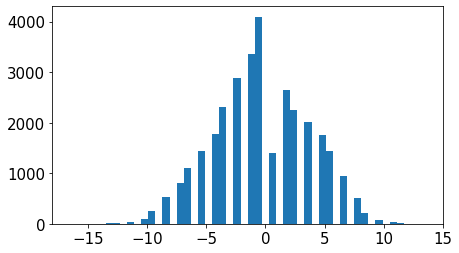

In [1199]:
plt.figure(figsize=(7,4))
plt.hist(actual_outputs.flatten(), 50);

In [1200]:
slope = np.zeros(W.shape[1])
intercept = np.zeros(W.shape[1])
error = np.zeros(W.shape[1])
for c in range(W.shape[1]):
    p, res, _, _, _ = np.polyfit(expected_outputs[:, c], actual_outputs[:, c], 1, full=True)
    slope[c] = p[0]
    intercept[c] = p[1]
    actual_outputs[:, c] = (actual_outputs[:, c] - p[1]) / p[0]
    error[c] = np.sqrt(res[0]) / p[0]
print(error.mean())
print(intercept.mean())

2.4421093876715525
0.7357115754107912


In [1193]:
# expected_outputs = inputs_scale.dot(W)
expected_outputs_all = expected_outputs
actual_outputs_all = actual_outputs

In [181]:
expected_outputs = expected_outputs_all
actual_outputs = actual_outputs_all

(0, 0.06578553652863664)
(1, 0.049162563263098945)
(2, 0.0718680944771815)
(3, 0.04275385606721582)
(4, 0.036986882173501254)
(5, 0.053768005621791314)
(6, 0.050244391497369076)
(7, 0.05697926986969133)
(8, 0.041320670254483556)
(9, 0.05577090859797049)
(10, 0.04966698129550794)
(11, 0.056239671615400964)
(12, 0.056256933035402204)
(13, 0.07831683305688358)
(14, 0.06680724313666231)
(15, 0.05195211049078724)


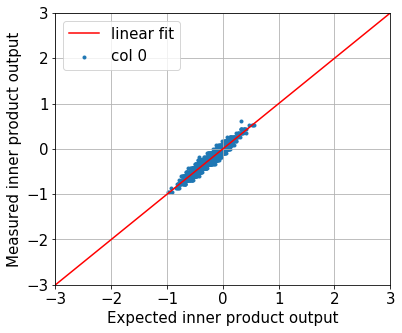

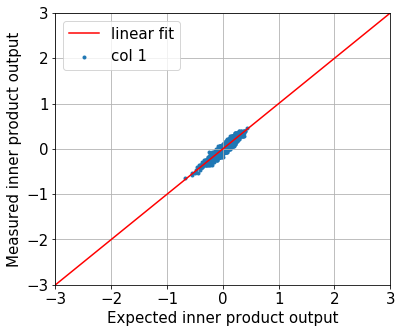

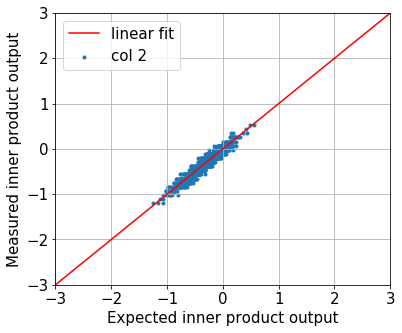

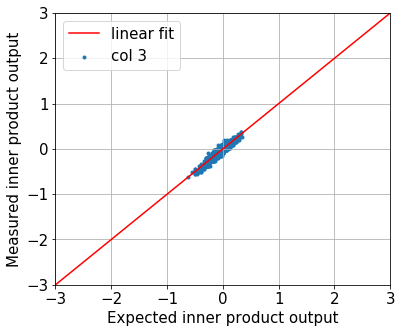

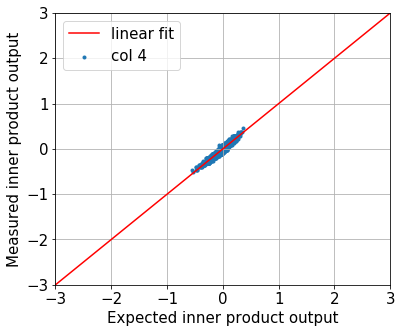

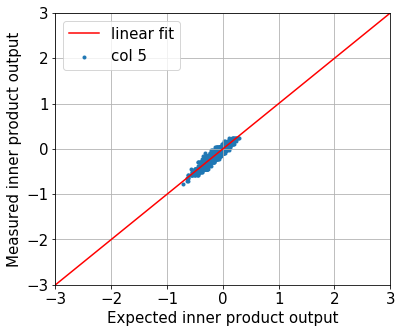

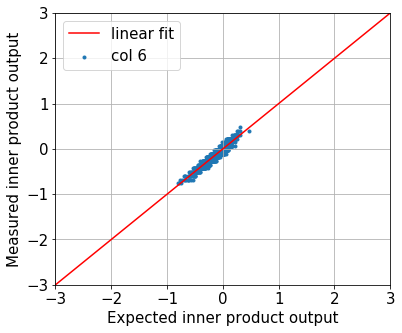

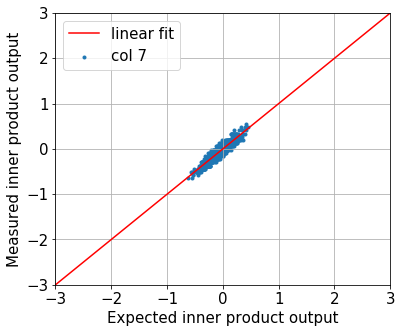

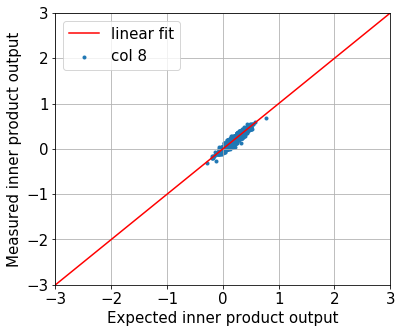

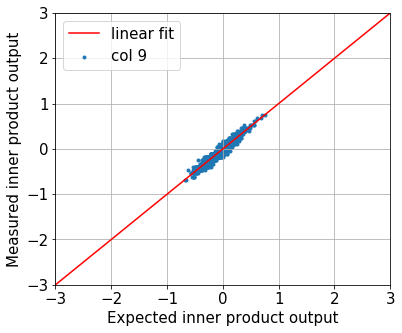

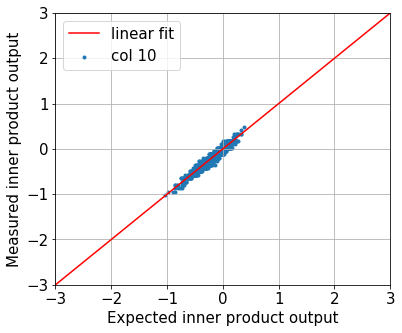

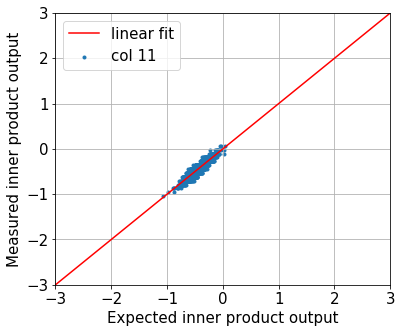

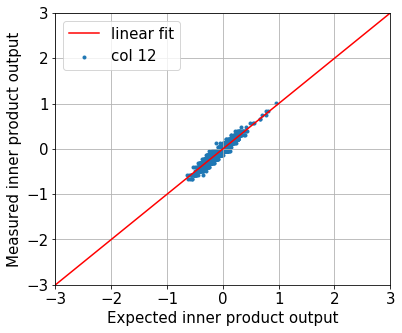

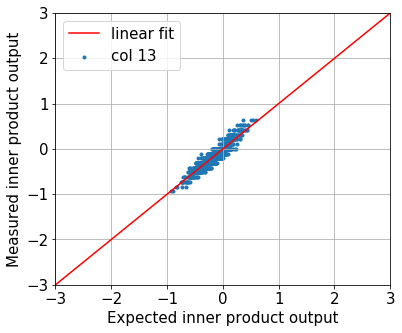

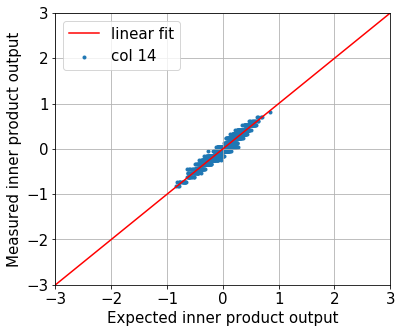

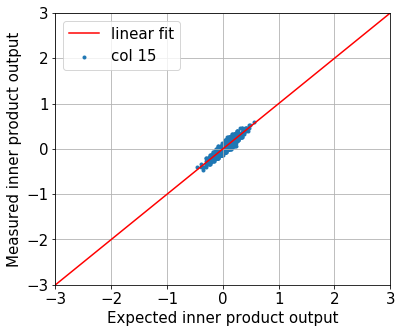

In [1194]:
for c in range(W.shape[1]):
    expected_outputs = expected_outputs_all[:, c]
    actual_outputs = actual_outputs_all[:, c]

#     expected_outputs = expected_outputs / np.linalg.norm(expected_outputs) * np.sqrt(expected_outputs.size)
    p, res, _, _, _ = np.polyfit(expected_outputs.flatten(), actual_outputs.flatten(), 1, full=True)
    y_fit = np.poly1d(p)
    std = np.sqrt(res/(expected_outputs.size-1))
    x = np.arange(-40, 40, 0.1)

    plt.rcParams.update({'font.size': 15})
    plt.figure(figsize=(6,5))
    plt.scatter(expected_outputs, actual_outputs/p[0], label='col %d' % c, marker='.')
    plt.plot(x, y_fit(x)/p[0], 'r', label='linear fit')
    plt.grid()
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.xlabel('Expected inner product output')
    plt.ylabel('Measured inner product output')
    plt.legend()


#     print(p[0])
    print((c, std[0]/p[0]))

# Multi-core parallel MVM

In [878]:
ITERATION = 1000
BATCH = 2
INPUT_NUM_BITS = 3
inputs = input_sample[:ITERATION, 6:9, 6:9, :].reshape([ITERATION, -1])
bias = 7 * np.ones([ITERATION, num_bias])
inputs = np.hstack([inputs[:, 96:192], bias])
inputs_scale = nn_np.quantize_rescale(inputs, 3, relux)

In [1285]:
vpos = 0.78
vneg = 0.69
vreset_plus = 0.12
vreset_minus = 0.03
pulse_multiplier = 5
matmul.dac_setup(dev, vpos, vneg, vreset_plus=vreset_plus, vreset_minus=vreset_minus, vcomp_offset=0.015)
spi.enable_single_col(dev, core_col, first_half=True, second_half=True)

actual_outputs_0 = np.zeros([ITERATION, len(cols)])
actual_outputs_1 = np.zeros([ITERATION, len(cols)])
actual_outputs_2 = np.zeros([ITERATION, len(cols)])
actual_outputs_3 = np.zeros([ITERATION, len(cols)])
actual_outputs_4 = np.zeros([ITERATION, len(cols)])
actual_outputs_5 = np.zeros([ITERATION, len(cols)])
expected_outputs_0 = inputs_scale.dot(W_list[0])
expected_outputs_1 = inputs_scale.dot(W_list[1])
expected_outputs_2 = inputs_scale.dot(W_list[2])
expected_outputs_3 = inputs_scale.dot(W_list[3])
expected_outputs_4 = inputs_scale.dot(W_list[4])
expected_outputs_5 = inputs_scale.dot(W_list[5])
start = time.time()

for i in range(ITERATION//BATCH):
    input_batch = inputs[BATCH*i:BATCH*(i+1), :]
    out_tmp = matmul.matmul_unsigned(
        dev, [[input_batch], [input_batch], [input_batch], [input_batch], [input_batch], [input_batch]],
        rows_list[0:6], cols_list[0:6], [[False], [False], [False], [False], [False], [False]],
        core_row_list.tolist(), True, INPUT_NUM_BITS, [core_col], pulse_multiplier=pulse_multiplier, prep=(i==0))
    actual_outputs_2[BATCH*i:BATCH*(i+1), :] = out_tmp[0][0]
    actual_outputs_3[BATCH*i:BATCH*(i+1), :] = out_tmp[1][0]
    actual_outputs_4[BATCH*i:BATCH*(i+1), :] = out_tmp[2][0]
    actual_outputs_0[BATCH*i:BATCH*(i+1), :] = out_tmp[3][0]
    actual_outputs_5[BATCH*i:BATCH*(i+1), :] = out_tmp[4][0]
    actual_outputs_1[BATCH*i:BATCH*(i+1), :] = out_tmp[5][0]

end = time.time()
print(end-start)
matmul.disable_inference(dev)

2.2203145027160645


In [1286]:
expected_outputs_list = [expected_outputs_2, expected_outputs_3, expected_outputs_4,
                         expected_outputs_0, expected_outputs_5, expected_outputs_1]
actual_outputs_list = [actual_outputs_2, actual_outputs_3, actual_outputs_4,
                       actual_outputs_0, actual_outputs_5, actual_outputs_1]

In [1287]:
error_list = []
intercept_list = []
for expected_outputs, actual_outputs in zip(expected_outputs_list, actual_outputs_list):
    slope = np.zeros(W.shape[1])
    intercept = np.zeros(W.shape[1])
    error = np.zeros(W.shape[1])
    for c in range(W.shape[1]):
        p, res, _, _, _ = np.polyfit(expected_outputs[:, c], actual_outputs[:, c], 1, full=True)
        slope[c] = p[0]
        intercept[c] = p[1]
#         actual_outputs[:, c] = (actual_outputs[:, c] - p[1]) / p[0]
        error[c] = np.sqrt(res[0]) / p[0]
    error_list.append(error.mean())
    intercept_list.append(intercept.mean())
print(error_list)
print(np.mean(error_list))
print(intercept_list)

[5.043599693789778, 5.369847260521688, 9.653729306082262, 15.439925073930013, 20.35563711157429, 27.954825453563597]
13.969593983243605
[15.011947915751744, -0.9198646234728255, -13.684489201786876, -19.004520477424894, -15.120952805691834, -13.57164441081504]


In [1280]:
expected_outputs = expected_outputs_list[5]
actual_outputs = actual_outputs_list[5]

In [1288]:
# Inference Multi-core
# vpos = 0.80
# vneg = 0.70
# pulse_multiplier = 8

start = time.time()

matmul.dac_setup(dev, vpos, vneg, vreset_plus=vreset_plus, vreset_minus=vreset_minus, vcomp_offset=0.015)

group_size = 100
num_steps = input_sample.shape[0] // group_size
out_chip = np.zeros([6, 1, input_sample.shape[0], 8, 8, 64], dtype=np.float16)
spi.enable_single_col(dev, core_col, first_half=True, second_half=True)
for s in range(num_steps):
    out_chip[:, :, (s)*group_size : (s+1)*group_size, :, :, :] = nn.conv_unsigned(
        dev, input_sample[s*group_size : (s+1)*group_size], rows_list[0:6], cols_list[0:6], core_row_list.tolist(), [core_col], 3, 3, INPUT_NUM_BITS, 
        segment_index=[[np.arange(96*2, 96*3)], [np.arange(96*3, 96*4)], [np.arange(96*4, 96*5)], [np.arange(96*0, 96*1)], [np.arange(96*5, 96*6)], [np.arange(96*1, 96*2)]], stride=1, pad=(1,1),
        bias=[[num_bias], [num_bias], [num_bias], [num_bias], [num_bias], [num_bias]], batch_size=10, pulse_multiplier=pulse_multiplier, verbose=True)
    print('Finished group %d' % s)
    
end = time.time()
print(end-start)

Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 0
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 1
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 2
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 3
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 4
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch

Finished batch 7
Finished batch 8
Finished batch 9
Finished group 43
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 44
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 45
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 46
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 47
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished 

Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 87
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 88
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 89
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 90
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 91
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished 

# Inference

In [ ]:
# vpos = 0.32
# vneg = 0.31
# vreset_plus = 0.12
# vreset_minus = 0.04
# pulse_multiplier = 2

# w_index = 1
start = time.time()

matmul.dac_setup(dev, vpos, vneg, vreset_plus=vreset_plus, vreset_minus=vreset_minus, vcomp_offset=0.015)
spi.enable_single_core(dev, core_row, core_col)

group_size = 100
num_steps = input_sample.shape[0] // group_size
out_chip = np.zeros([input_sample.shape[0], 32, 32, 16], dtype=np.float16)
for s in range(num_steps):
    out_chip[s*group_size : (s+1)*group_size] = nn.conv_unsigned(dev, input_sample[s*group_size : (s+1)*group_size], rows, cols, core_row, core_col,
                                                                 3, 3, INPUT_NUM_BITS, segment_index=np.arange(72*w_index, 72*(w_index+1)), stride=1, pad=(1,1),
                                                                 bias=num_bias, batch_size=10, pulse_multiplier=pulse_multiplier, verbose=True)
    print('Finished group %d' % s)

# out_chip = nn.conv_unsigned(dev, input_sample, rows, cols, core_row, core_col, 3, 3, INPUT_NUM_BITS, segment_index=np.arange(72), stride=1, pad=(1,1), bias=num_bias, batch_size=10, pulse_multiplier=pulse_multiplier, verbose=True)


# out_chip = nn.dense_unsigned(dev, input_sample, rows, cols, core_row, core_col, INPUT_NUM_BITS, bias=num_bias, batch_size=10, pulse_multiplier=pulse_multiplier, verbose=True)
# out_chip = quantize_rescale(out_chip, 3, relux1)
end = time.time()
print(end-start)

Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 0
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 1
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 2
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 3
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 4
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch

Finished batch 7
Finished batch 8
Finished batch 9
Finished group 43
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 44
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 45
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 46
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 47
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished 

Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 87
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 88
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 89
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 90
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished group 91
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished 

In [ ]:
DATA_PATH = 'C:\\Users\\Weier Wan\\Documents\\neurram_data\\forward_finetune\\'
# DATA_PATH = 'E:\\neurram_data\\forward_finetune\\'
np.save(DATA_PATH + 'out_chip_%s_%d_transfer' % (layer, w_index), out_chip)

In [1304]:
DATA_PATH = 'C:\\Users\\Weier Wan\\Documents\\neurram_data\\forward_finetune\\'
out_chip = np.load(DATA_PATH + 'out_chip_%s_0_transfer.npy' % layer)

In [1318]:
w_index = 1
intermediate_output = nn_np.conv(nn_np.quantize_rescale(input_sample, 3, relux), conv_W, conv_b/2, stride=1, pad=(1,1),
                                 segment_index=np.arange(w_index*72, (w_index+1)*72), bias=True)
# intermediate_output = nn_np.dense(nn_np.quantize_rescale(input_sample[:10000], 3, relux), conv_W, conv_b, segment_index=None)

NameError: name 'input_sample' is not defined

In [1311]:
fit_sample = np.hstack([np.arange(500), np.arange(4500, 5000), np.arange(9500, 10000)])
slope = np.zeros(W.shape[1], dtype=np.float32)
intercept = np.zeros(W.shape[1], dtype=np.float32)
error = np.zeros(W.shape[1], dtype=np.float32)
out_chip_shift = np.copy(out_chip[:]).astype(np.float32)
for c in range(W.shape[1]):
    p, res, _, _, _ = np.polyfit(intermediate_output[fit_sample, :, :, c].flatten().astype(np.float32), out_chip_shift[fit_sample, :, :, c].flatten().astype(np.float32), 1, full=True)
    std = np.sqrt(res/(intermediate_output[fit_sample, :, :, c].size-1))
    print('col %d' % c)
    print(p[0])
    print(p[1])
    print(std[0]/p[0])
    slope[c] = p[0]
    intercept[c] = p[1]
    error[c] = std[0]/p[0]
    out_chip_shift[:, :, :, c] = (out_chip_shift[:, :, :, c] - p[1]) / p[0]
print(error.mean())

col 0
5.144142108913386
1.5675770188103535
0.12798703667723516
col 1
8.411512741074763
3.800327750311491
0.11623019396273686
col 2
4.660859663819608
0.29002260401125146
0.1548667484010926
col 3
7.941023791178751
7.398085561893478
0.11835461479221561
col 4
7.799912835285638
0.5279462154660155
0.11700790742044033
col 5
6.043249309907868
3.6658286597071403
0.12179718991318499
col 6
6.257631513120318
-0.8553682492462017
0.18205872304475612
col 7
5.337416458730584
-5.516585221283575
0.1278066805447229
col 8
7.7204742467564405
-2.5194065379624786
0.11259137467759806
col 9
4.467708885981364
-3.591587630401653
0.16933409148327808
col 10
6.196584416805986
-1.8511416672775816
0.13261003024639784
col 11
4.187699414807827
-3.7919419866353907
0.1762442015450848
col 12
4.742006819869141
-3.9898969878978883
0.12964165922639467
col 13
5.301919227731552
-1.1697416052350285
0.13760499261265102
col 14
4.664956432158363
3.529605119300213
0.1340066468057388
col 15
6.114089936822305
-5.594063285026255
0.149

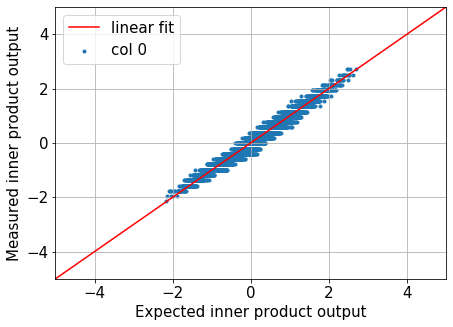

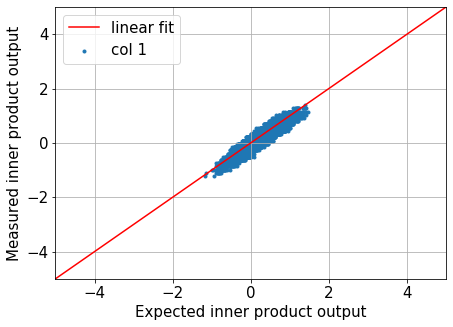

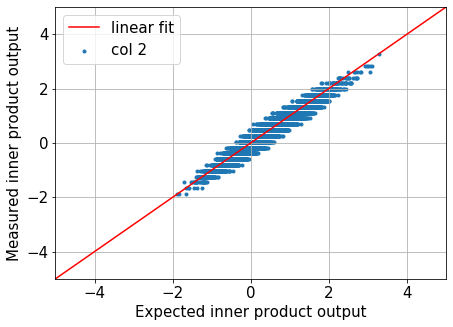

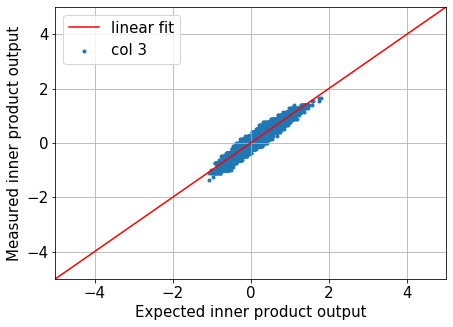

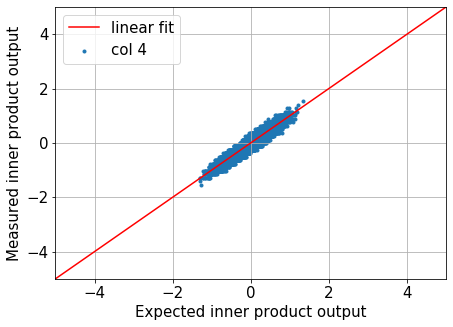

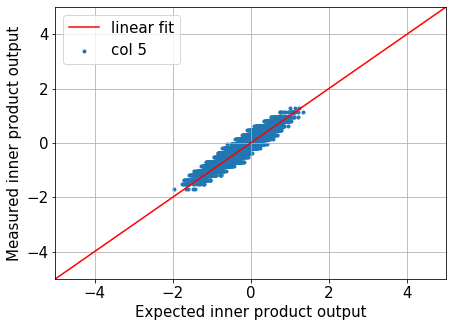

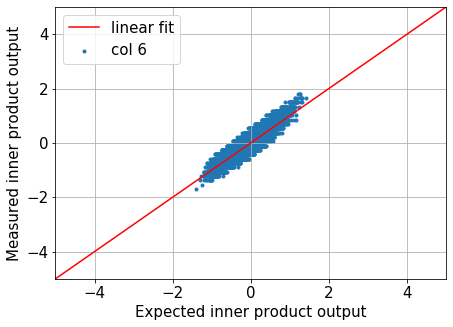

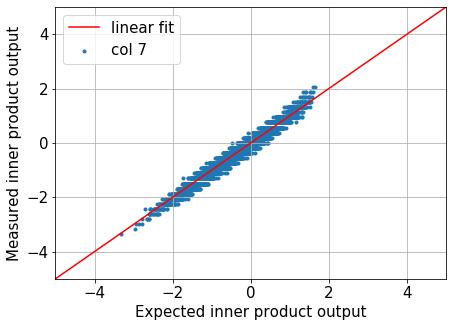

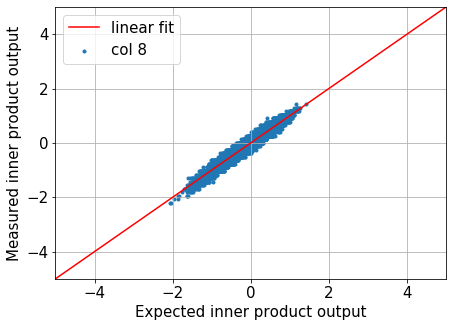

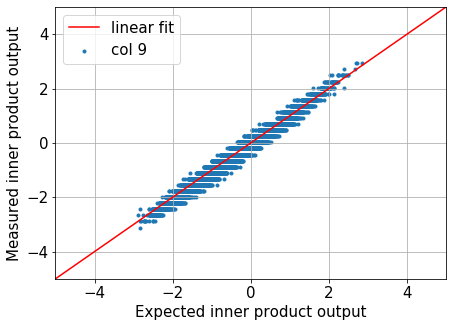

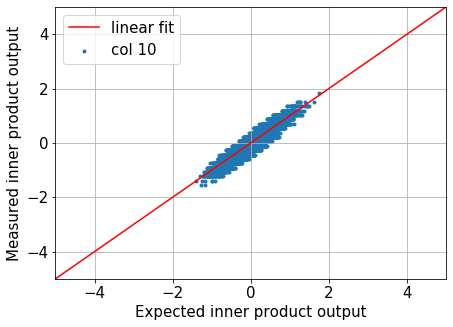

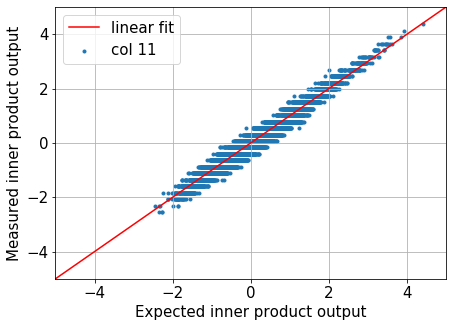

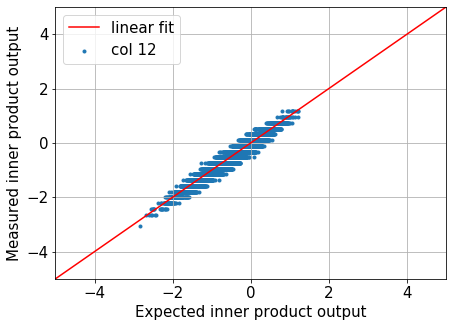

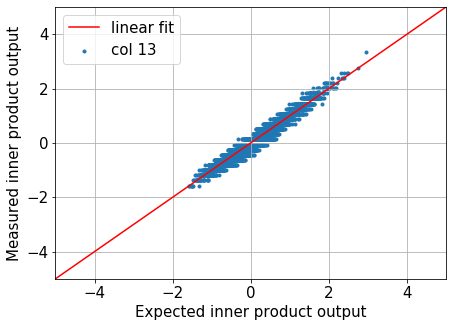

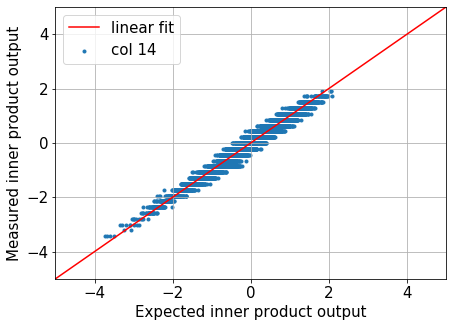

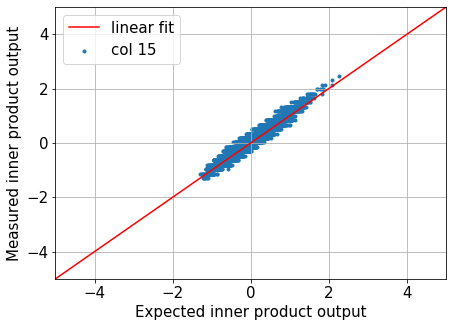

In [1312]:
scatter_sample = np.hstack([np.arange(10), np.arange(4000, 4010), np.arange(9990, 10000)])
for c in range(W.shape[1]):
#     p, res, _, _, _ = np.polyfit(intermediate_output[scatter_sample, :, :, c].flatten().astype(np.float32), out_chip_shift_2[10000+scatter_sample, :, :, c].flatten().astype(np.float32), 1, full=True)
    y_fit = np.poly1d([1,0])
#     std = np.sqrt(res/(intermediate_output[:, :, :, c].size-1))
    x = np.arange(-100, 100, 1)

    plt.figure(figsize=(7,5))
    plt.rcParams.update({'font.size': 15})
    ax = plt.subplot(111)
    plt.scatter(intermediate_output[scatter_sample, :, :, c], out_chip_shift[scatter_sample, :, :, c], label='col %d' % c, marker='.')
    plt.plot(x, y_fit(x), 'r', label='linear fit')
    plt.grid()
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    plt.xlabel('Expected inner product output')
    plt.ylabel('Measured inner product output')
    plt.legend()

#     print(p[0]) # This is the output scaling factor
#     print(std[0]/p[0])

In [1297]:
out_chip_shift_1 = out_chip_shift

In [1459]:
np.mean(np.argmax(out_chip_shift[:10000], axis=1) == np.argmax(y_test, axis=1))

0.8511

In [1321]:
# slope_0 = slope
# intercept_0 = intercept
out_chip_shift_1 = (out_chip - intercept) / slope

In [1298]:
out_chip_shift = out_chip_shift_0[:10000] + out_chip_shift_1[:10000] #+ out_chip_shift_2[:10000] + out_chip_shift_3[:10000] + out_chip_shift_4[:10000] + out_chip_shift_5[:10000]#+ intermediate_output

In [504]:
# DATA_PATH = 'C:\\Users\\Weier Wan\\Box\\neurram_data\\cifar10_resnet20\\'
DATA_PATH = 'C:\\Users\\Weier Wan\\Documents\\neurram_data\\forward_finetune\\'
np.savez(DATA_PATH + '%s_%d_train' % (layer, w_index), out_chip=out_chip[w_index, 0, 10000:, :, :, :], slope=slope, intercept=intercept, vpos=vpos, vneg=vneg, pulse_multiplier=pulse_multiplier)
np.savez(DATA_PATH + '%s_%d_test' % (layer, w_index), out_chip=out_chip[w_index, 0, :10000, :, :, :], slope=slope, intercept=intercept, vpos=vpos, vneg=vneg, pulse_multiplier=pulse_multiplier)

In [1303]:
DATA_PATH = 'C:\\Users\\Weier Wan\\Documents\\neurram_data\\forward_finetune\\'
# out_chip_shift = out_chip_shift_0 + out_chip_shift_1 + out_chip_shift_2 + out_chip_shift_3 + out_chip_shift_4 + out_chip_shift_5
# np.save(DATA_PATH + '%s_train_pact' % layer, out_chip_shift[10000:])
np.save(DATA_PATH + '%s_test_pact_transfer' % layer, out_chip_shift[:10000])

In [15]:
DATA_PATH = 'C:\\Users\\Weier Wan\\Documents\\neurram_data\\forward_finetune\\'
tmp = np.load(DATA_PATH + '%s_tmp.npz' % layer)
out_chip = tmp['out_chip']
slope_0, slope_1, slope_2 = tmp['slopes']
intercept_0, intercept_1, intercept_2 = tmp['intercepts']

In [98]:
layer = 'conv2d_noise_5'
w_index = 1
tmp = np.load(DATA_PATH + '%s_%d_train_0.npz' % (layer, w_index))
out_chip_train_1 = tmp['out_chip']
# vpos = tmp['vpos']
# vneg = tmp['vneg']
# pulse_multiplier = tmp['pulse_multiplier']
# slope_1 = tmp['slope']
# intercept_1 = tmp['intercept']

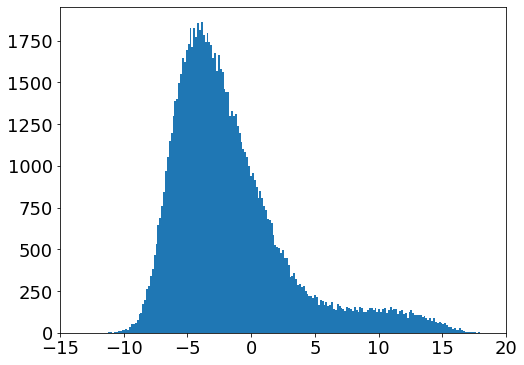

In [338]:
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(figsize=(8, 6))
plt.hist(intermediate_output.flatten(), 200);
plt.xlim(-15, 20)
ax.ticklabel_format(style='sci',scilimits=(-3,4),axis='both')

In [ ]:
steps = input_sample.shape[0] // 5000
slope = np.zeros([steps, W.shape[1]])
intercept = np.zeros([steps, W.shape[1]])
error = np.zeros([steps, W.shape[1]])
means = np.zeros([steps])
stds = np.zeros([steps])
w_index = 0
for i in range(steps):
    intermediate_output = nn_np.conv(nn_np.quantize_rescale(input_sample[5000*i:5000*(i+1)], 3, relux), conv_W, conv_b/3, stride=1, pad=(1,1),
                                     segment_index=np.arange(w_index*96, (w_index+1)*96), bias=True)
    means[i] = intermediate_output.mean()
    stds[i] = intermediate_output.std()
    for c in range(W.shape[1]):
        p, res, _, _, _ = np.polyfit(intermediate_output[:, :, :, c].flatten().astype(np.float32), out_chip[5000*i:5000*(i+1), :, :, c].flatten().astype(np.float32), 1, full=True)
        slope[i, c] = p[0]
        intercept[i, c] = p[1]
        error[i, c] = std[0]/p[0]
    print(error[i].mean())

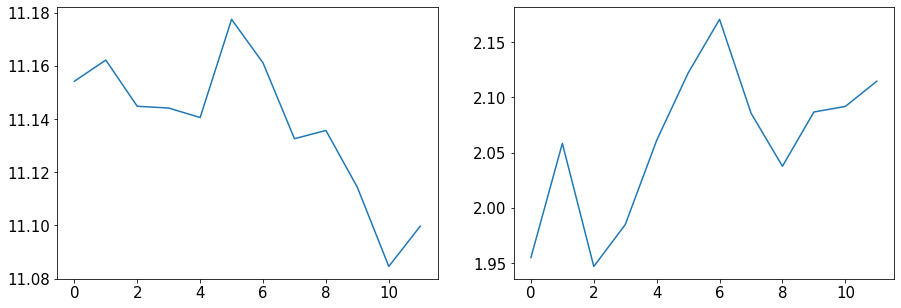

In [1190]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(slope.mean(axis=1))
plt.subplot(122)
plt.plot(intercept.mean(axis=1))

In [2795]:
input_mean = np.zeros([steps])
input_std = np.zeros([steps])
for i in range(steps):
    input_quant = nn_np.quantize_rescale(input_sample[5000*i:5000*(i+1)], 3, relux)
    input_mean[i] = input_quant.mean()
    input_std[i] = input_quant.std()

# Evaluate inference accuracy

In [1271]:
def resnet20_finetune(activation_bits, weight_noise_train, weight_noise_test):
    # Build model for finetuning

    layer_input_0 = Input(shape=(32, 32, 16)) # a new input tensor to be able to feed the desired layer
    layer_input_1 = Input(shape=(32, 32, 16))

    # create the new nodes for each layer in the path

#     y = conv2d_noise(16, strides=1, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise')(layer_input_0)
#     y = BatchNormalization(name='batch_normalization')(y)
#     y = activation_quant(num_bits=activation_bits, max_value=3, name='activation_quant')(layer_input_0)

    # Stack 1, block 1
#     x = conv2d_noise(16, strides=1, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise_1')(y)
#     x = BatchNormalization(name='batch_normalization_1')(x)
#     x = activation_quant(num_bits=activation_bits, max_value=3, name='activation_quant_1')(layer_input_1)
#     x = conv2d_noise(16, strides=1, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise_2')(x)
#     x = BatchNormalization(name='batch_normalization_2')(x)
#     y = keras.layers.add([y, layer_input_1])
#     y = activation_quant(num_bits=activation_bits, max_value=3, name='activation_quant_2')(y)

    # Stack 1, block 2
#     x = conv2d_noise(16, strides=1, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise_3')(layer_input_0)
#     x = BatchNormalization(name='batch_normalization_3')(x)
#     x = activation_quant(num_bits=activation_bits, max_value=3, name='activation_quant_3')(layer_input_1)
#     x = conv2d_noise(16, strides=1, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise_4')(x)
#     x = BatchNormalization(name='batch_normalization_4')(x)
    y = keras.layers.add([layer_input_0, layer_input_1])
    y = activation_quant(num_bits=activation_bits, max_value=3, name='activation_quant_4')(y)

    # Stack 1, block 3
    x = conv2d_noise(16, strides=1, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise_5')(y)
    x = BatchNormalization(name='batch_normalization_5')(x)
    x = activation_quant(num_bits=activation_bits, max_value=3, name='activation_quant_5')(x)
    x = conv2d_noise(16, strides=1, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise_6')(x)
    x = BatchNormalization(name='batch_normalization_6')(x)
    y = keras.layers.add([y, x])
    y = activation_quant(num_bits=activation_bits, max_value=3, name='activation_quant_6')(y)

    # Stack 2, block 1
    x = conv2d_noise(32, strides=2, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise_7')(y)
    x = BatchNormalization(name='batch_normalization_7')(x)
    x = activation_quant(num_bits=activation_bits, max_value=3, name='activation_quant_7')(x)
    x = conv2d_noise(32, strides=1, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise_8')(x)
    y = conv2d_noise(32, kernel_size=1, strides=2, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise_9')(y)
    x = BatchNormalization(name='batch_normalization_8')(x)
    y = keras.layers.add([y, x])
    y = activation_quant(num_bits=activation_bits, max_value=3, name='activation_quant_8')(y)

    # Stack 2, block 2
    x = conv2d_noise(32, strides=1, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise_10')(y)
    x = BatchNormalization(name='batch_normalization_9')(x)
    x = activation_quant(num_bits=activation_bits, max_value=3, name='activation_quant_9')(x)
    x = conv2d_noise(32, strides=1, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise_11')(x)
    x = BatchNormalization(name='batch_normalization_10')(x)
    y = keras.layers.add([y, x])
    y = activation_quant(num_bits=activation_bits, max_value=3, name='activation_quant_10')(y)

    # Stack 2, block 3
    x = conv2d_noise(32, strides=1, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise_12')(y)
    x = BatchNormalization(name='batch_normalization_11')(x)
    x = activation_quant(num_bits=activation_bits, max_value=3, name='activation_quant_11')(x)
    x = conv2d_noise(32, strides=1, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise_13')(x)
    x = BatchNormalization(name='batch_normalization_12')(x)
    y = keras.layers.add([y, x])
    y = activation_quant(num_bits=activation_bits, max_value=3, name='activation_quant_12')(y)

    # Stack 3, block 1
    x = conv2d_noise(64, strides=2, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise_14')(y)
    x = BatchNormalization(name='batch_normalization_13')(x)
    x = activation_quant(num_bits=activation_bits, max_value=3, name='activation_quant_13')(x)
    x = conv2d_noise(64, strides=1, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise_15')(x)
    y = conv2d_noise(64, kernel_size=1, strides=2, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise_16')(y)
    x = BatchNormalization(name='batch_normalization_14')(x)
    y = keras.layers.add([y, x])
    y = activation_quant(num_bits=activation_bits, max_value=3, name='activation_quant_14')(y)

    # Stack 3, block 2
    x = conv2d_noise(64, strides=1, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise_17')(y)
    x = BatchNormalization(name='batch_normalization_15')(x)
    x = activation_quant(num_bits=activation_bits, max_value=3, name='activation_quant_15')(x)
    x = conv2d_noise(64, strides=1, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise_18')(x)
    x = BatchNormalization(name='batch_normalization_16')(x)
    y = keras.layers.add([y, x])
    y = activation_quant(num_bits=activation_bits, max_value=3, name='activation_quant_16')(y)

    # Stack 3, block 3
    x = conv2d_noise(64, strides=1, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise_19')(y)
    x = BatchNormalization(name='batch_normalization_17')(x)
    x = activation_quant(num_bits=activation_bits, max_value=3, name='activation_quant_17')(x)
    x = conv2d_noise(64, strides=1, padding='same', noise_train=weight_noise_train, noise_test=weight_noise_test, name='conv2d_noise_20')(x)
    x = BatchNormalization(name='batch_normalization_18')(x)
    y = keras.layers.add([y, x])

    y = AveragePooling2D(pool_size=8)(y)
    y = Flatten()(y)
    y = activation_quant(num_bits=activation_bits, max_value=3, name='activation_quant_18')(y)

    outputs = dense_noise(10, activation='softmax', noise_train=weight_noise_train, noise_test=weight_noise_test, name='dense_noise')(y)

    # create the model
    model = Model([layer_input_0, layer_input_1], outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(1e-4),
                  metrics=['accuracy'])
    model.summary()
    return model


def build_model(activation_bits, weight_noise_train, weight_noise_test, weights_map):
    K.clear_session()
    model = resnet20_finetune(activation_bits, weight_noise_train, weight_noise_test)
    for klayer in model.layers:
        if klayer.name in weights_map:
            klayer.set_weights(weights_map[klayer.name])
    return model

In [1340]:
new_model = build_model(3, 0.0, 0.0, weights)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 16)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 32, 32, 16)] 0                                            
__________________________________________________________________________________________________
add (Add)                       (None, 32, 32, 16)   0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
activation_quant_4 (activation_ (None, 32, 32, 16)   1           add[0][0]                    

In [1327]:
DATA_PATH = 'C:\\Users\\Weier Wan\\Documents\\neurram_data\\forward_finetune\\'
# DATA_PATH = 'E:\\neurram_data\\forward_finetune\\'


# tmp = np.load(DATA_PATH + '%s.npz' % 'activation_quant_12')
# test_previous_layer = tmp['input_sample_test']
# relux = tmp['relux']
# test_previous_layer = nn_np.quantize_rescale(test_previous_layer, 3, relux)
# input_sample_train = tmp['input_sample_train']

# test_previous_layer = np.load(DATA_PATH + '%s_test_transfer.npy' % 'activation_quant_14')
# train_previous_layer = np.load(DATA_PATH + '%s_train_pact.npy' % 'flatten')
test_current_layer = np.load(DATA_PATH + '%s_test_pact_transfer.npy' % 'conv2d_noise_4')
# train_current_layer = np.load(DATA_PATH + '%s_train_pact.npy' % 'conv2d_noise_19')

In [1036]:
BOX_PATH = 'C:\\Users\\Weier Wan\\Box\\neurram_data\\forward_finetune_val\\'
tmp = np.load(BOX_PATH + 'conv2d_noise_3_0_test.npz')

In [141]:
test_current_layer = (tmp['out_chip'] - tmp['intercept']) / tmp['slope']

In [1329]:
p, res, _, _, _ = np.polyfit(intermediate_output[:5000, :, :, :].flatten().astype(np.float32), out_chip_shift[:5000, :, :, :].flatten().astype(np.float32), 1, full=True)
std = np.sqrt(res/(intermediate_output[:5000].size-1))
print(std)

[1.51978034]


Text(0, 0.5, 'Measured conv_20 layer output')

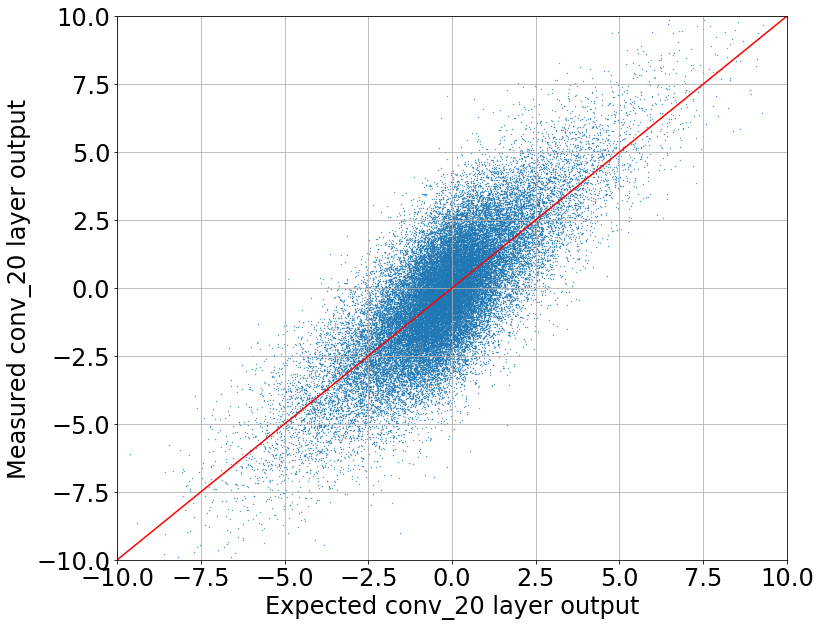

In [1328]:
RANGE = 10
x = np.arange(-RANGE, RANGE + 0.1, 0.1)
plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(12,10))
plt.scatter(intermediate_output[500:510, :, :, :].flatten(), out_chip_shift[500:510, :, :, :].flatten(), marker='.', s=0.5)
plt.plot(x, x, 'r')
plt.grid()
plt.xlim(-RANGE, RANGE)
plt.ylim(-RANGE, RANGE)
plt.xlabel('Expected conv_20 layer output')
plt.ylabel('Measured conv_20 layer output')
# plt.legend()


In [447]:
input_sample_test = np.load(DATA_PATH + '%s_test_pact_input.npy' % 'activation_quant_12')
input_sample_train = np.load(DATA_PATH + '%s_train_pact_input.npy' % 'activation_quant_12')

In [1333]:
# Score intermediate input model.
scores = new_model.evaluate([test_previous_layer, test_current_layer], y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 27s 3ms/sample - loss: 0.4172 - accuracy: 0.8678
Test loss: 0.4172378159046173
Test accuracy: 0.8678


In [763]:
np.mean(np.argmax(out_chip_shift[:10000], axis=1) == np.argmax(y_test, axis=1))

C:\Users\Weier Wan\.conda\envs\py36\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


0.0

In [1339]:
accuracy = np.zeros(10)
for i in range(10):
    accuracy[i] = new_model.evaluate([test_previous_layer, test_current_layer], y_test, verbose=1)[1]
print(accuracy.mean())

10000/10000 [==============================] - 19s 2ms/sample - loss: 0.4721 - accuracy: 0.8504
0.852510005235672


In [1341]:
intermediate_layer_model = keras.Model(inputs=new_model.input,
                                 outputs=new_model.get_layer('activation_quant_4').output)
test_previous_layer = intermediate_layer_model.predict([test_previous_layer, test_current_layer])
# train_previous_layer = intermediate_layer_model.predict([train_previous_layer, train_current_layer])

0.40982187


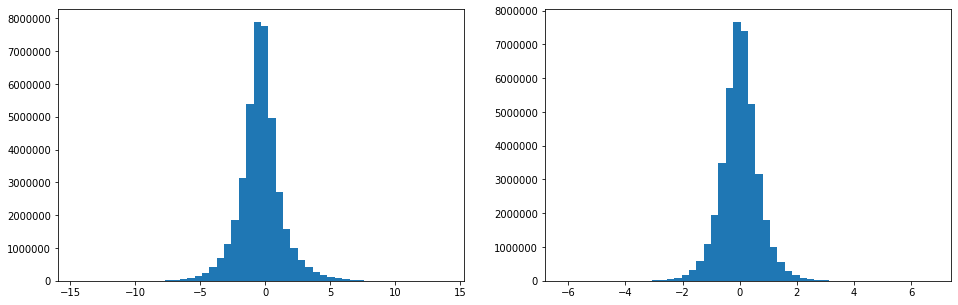

In [117]:
plt.figure(figsize=(16, 5))
plt.subplot(121)
plt.hist(original.flatten(), 50);
diff = original-noisy
plt.subplot(122)
plt.hist(diff.flatten(), 50);

print(diff.std() / original.std())

In [17]:
del test_current_layer
del train_current_layer

In [577]:
np.savez(DATA_PATH + 'activation_quant_4.npz', input_sample_train=input_sample_train, input_sample_test=input_sample_test, relux=relux)

In [1342]:
# np.save(DATA_PATH + 'activation_quant_14_train', train_previous_layer)
np.save(DATA_PATH + 'activation_quant_4_test_transfer', test_previous_layer)